# 训练思路

Logic：仅预测撂荒地上光伏建设概率即可，加入多时序可以丰富样本信息、学习到增量样本表示

数据流：


输入：
1、训练样本（划分训练集、测试集合）：美国光伏正样本；
2、预测样本：美国光伏用地；

输出：得到

数据操作：

（先用QQ图观察各个数据的分布特征）对于符合正态分布特征可以直接进入聚类；

1、样本标准化；
2、


后期数据补齐（后期模型优化需要注意的point）
1、Y数据源统一的问题；
2、R语言包问题解决；d
3、提取光伏Y=1正标签对应的landcover序列

# Load Data

In [2]:
from function import *
import pandas as pd
import pandas as pd
import geopandas as gpd
from typing import Sequence



abandon_2d_variable = [
    "current_abandonment",
    "recultivation", 
    "abandonment_duration",
    "abandonment_year"
]
fea_3d_variable = [
    'GDPpc',
    'GDPtot',
    'GURdist',
    'Population',
    'gdmp',
    'rsds',
    'tas',
    'wind'
]
fea_2d_variable = [
    'DEM',
    'Powerdist',
    'PrimaryRoad',
    'SecondaryRoad',
    'Slope',
    'TertiaryRoad'
]
PATHS = {
    'abandonment': r"D:\xarray\merged_chunk_2\*.nc",
    'feature':     "D:/xarray/aligned2/Feature_all/*.nc",
    'csv':         "aligned_for_training0519.csv",
    'prediction':  "",
    'prediction_us': "",
    'test_output': "positive_samples_test_500.csv",
    'output':      "positive_samples_full_with_features.csv",
    'CN_sheng': r'data\sheng2022.shp',
    'World_shp': r'data\main_ADM_0.shp', 
    'us_abandon': r'data\us_abandon_clean.csv',
    'us_pv_embedding': r'data\training_embedding.csv'
}

ZERO_COLS = [
     'GDPpc', 'GDPtot', 'GURdist', 'Population',
    'PrimaryRoad', 'SecondaryRoad', 'TertiaryRoad', 'gdmp'
]
YEARS = [2018, 2020]

NUMERIC_FEATURES = [
    'lat','lon','GDPpc', 'GDPtot', 'GURdist', 'DEM','Slope',
    'Population','Powerdist','PrimaryRoad','SecondaryRoad','TertiaryRoad',
    'gdmp','rsds','tas','wind'
]
CAT_COLS = ['landcover']

ABANDON_COLS = ['abandonment_year','abandonment_duration', 'current_abandonment']

NONE_ABANDON_COLS = ['recultivation']

time=['2018-01-01','2020-01-01']





gogogo


# GMM模块：基于数据密度驱动的环境相似性建模

## GMM模块

In [24]:
# -*- coding: utf-8 -*-
"""
整合版本的GMM+深度学习训练管道
- 统一的GMM训练和深度学习流程
- 解决数据泄露：预处理器在Pipeline中
- 完整的负样本采样和模型评估
- 简化的API设计

Author: you + ChatGPT 
"""
from __future__ import annotations

import os
import warnings
from typing import List, Tuple, Dict, Any, Optional, Sequence

from sklearn.pipeline import Pipeline as SkPipeline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV, train_test_split, learning_curve, StratifiedKFold
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    OrdinalEncoder,
    QuantileTransformer,
    RobustScaler,
    StandardScaler,
    PowerTransformer,
    FunctionTransformer,
    OneHotEncoder,
)
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc, mean_squared_error, mean_absolute_error,
    roc_auc_score
)
from tqdm.auto import tqdm
from typing import Dict, List, Optional, Tuple


SkPipeline = Pipeline

# 深度学习库
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers
    TENSORFLOW_AVAILABLE = True
    print("✅ TensorFlow available")
except ImportError:
    TENSORFLOW_AVAILABLE = False
    print("❌ TensorFlow not available")

try:
    from scikeras.wrappers import KerasClassifier
    SCIKERAS_AVAILABLE = True
    print("✅ scikeras available")
except ImportError:
    SCIKERAS_AVAILABLE = False
    print("❌ scikeras not available (pip install scikeras)")

# SHAP（可选）
try:
    import shap
    SHAP_AVAILABLE = True
    print("✅ SHAP available")
except ImportError:
    SHAP_AVAILABLE = False
    print("❌ SHAP not available")

# 可视化设置
plt.style.use('default')
plt.rcParams['font.size'] = 10
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

# ------------------------------
# 修复：组合预处理器（解决数据泄露）
# ------------------------------


class CombinedPreprocessor(BaseEstimator, TransformerMixin):
    """
    组合预处理器：数值 + 类别（One-Hot），确保特征维度一致性
    """
    def __init__(self, numeric_features: List[str], categorical_features: List[str]):
        self.numeric_features = numeric_features
        self.categorical_features = categorical_features
        self.numeric_preprocessor = None
        self.categorical_preprocessor = None
        self.feature_names_out_ = None
        
        # ✅ 关键修复：预定义landcover的所有可能类别
        self.known_landcover_categories = [1, 2, 3, 4, 5, 6, 7, 8, 9]  # 固定1-9类别
        
        # 数值特征预处理器
        if self.numeric_features:
            self.numeric_preprocessor = Pipeline([
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())
            ])
        
        # ✅ 类别特征预处理器 - 固定类别
        if self.categorical_features:
            self.categorical_preprocessor = OneHotEncoder(
                categories=[self.known_landcover_categories],  # 固定类别
                sparse_output=False, 
                handle_unknown='ignore',  # 忽略未知类别
                drop=None  # 保留所有类别
            )

    def fit(self, X, y=None):
        """拟合预处理器"""
        # 确保输入是DataFrame并且列存在
        if not isinstance(X, pd.DataFrame):
            raise ValueError("输入必须是pandas DataFrame")
        
        # 检查特征列是否存在
        missing_features = [f for f in (self.numeric_features + self.categorical_features) if f not in X.columns]
        if missing_features:
            raise ValueError(f"以下特征列在输入数据中不存在: {missing_features}")
        
        # 拟合数值特征预处理器
        if self.numeric_features:
            self.numeric_preprocessor.fit(X[self.numeric_features])
        
        # 拟合类别特征预处理器
        if self.categorical_features:
            # ✅ 确保landcover列是整数类型
            X_cat = X[self.categorical_features].copy()
            for col in self.categorical_features:
                if col == 'landcover':
                    X_cat[col] = X_cat[col].astype(int)
            
            self.categorical_preprocessor.fit(X_cat)
        
        # ✅ 生成固定的特征名称
        self._generate_feature_names()
        return self

    def transform(self, X):
        """转换数据"""
        if not isinstance(X, pd.DataFrame):
            raise ValueError("输入必须是pandas DataFrame")
        
        # 检查是否已拟合
        if ((self.numeric_features and self.numeric_preprocessor is None) or 
            (self.categorical_features and self.categorical_preprocessor is None)):
            raise ValueError("必须先调用fit方法")
        
        results = []
        
        # 转换数值特征
        if self.numeric_features:
            X_num_transformed = self.numeric_preprocessor.transform(X[self.numeric_features])
            results.append(X_num_transformed)
        
        # 转换类别特征
        if self.categorical_features:
            X_cat = X[self.categorical_features].copy()
            for col in self.categorical_features:
                if col == 'landcover':
                    X_cat[col] = X_cat[col].astype(int)
            
            X_cat_transformed = self.categorical_preprocessor.transform(X_cat)
            results.append(X_cat_transformed)
        
        # 合并结果
        if results:
            return np.hstack(results)
        else:
            return np.array([]).reshape(X.shape[0], 0)

    def _generate_feature_names(self):
        """生成特征名称"""
        feature_names = []
        
        # 数值特征名称
        if self.numeric_features:
            feature_names.extend(self.numeric_features)
        
        # ✅ 类别特征名称 - 固定生成
        if self.categorical_features:
            for col in self.categorical_features:
                if col == 'landcover':
                    # 为每个landcover类别生成固定的特征名
                    for category in self.known_landcover_categories:
                        feature_names.append(f"landcover_{category}")
                else:
                    # 其他类别特征的处理
                    cat_names = self.categorical_preprocessor.get_feature_names_out([col])
                    feature_names.extend(cat_names)
        
        self.feature_names_out_ = np.array(feature_names)

    def get_feature_names_out(self, input_features=None):
        """获取输出特征名称"""
        if self.feature_names_out_ is None:
            raise ValueError("必须先调用fit方法")
        return self.feature_names_out_

    def get_params(self, deep=True):
        """获取参数"""
        return {
            'numeric_features': self.numeric_features,
            'categorical_features': self.categorical_features
        }

    def set_params(self, **params):
        """设置参数"""
        for key, value in params.items():
            setattr(self, key, value)
        return self


#---------------------------
# Top-level, picklable transformers (no lambdas!)
# ------------------------------
class ReplaceInfWithNaN(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = np.asarray(X, dtype=float)
        X[~np.isfinite(X)] = np.nan
        return X

class SafeLog1p(BaseEstimator, TransformerMixin):
    def __init__(self, lower_bound: float = -1 + 1e-6):
        self.lower_bound = lower_bound
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = np.asarray(X, dtype=float)
        X = np.where(X <= self.lower_bound, self.lower_bound, X)
        return np.log1p(X)

# ------------------------------
# Utilities
# ------------------------------
def get_adaptive_n_quantiles(n_samples: int) -> int:
    """Adaptive n_quantiles for QuantileTransformer: 10..1000 and ≤ n_samples."""
    return int(max(10, min(1000, n_samples)))

# ------------------------------
# Light-weight quality check helpers
# ------------------------------
def _cov_condition_number(X: np.ndarray) -> Dict[str, float]:
    X = np.asarray(X, dtype=float)
    C = np.cov(X, rowvar=False)
    C += np.eye(C.shape[0]) * 1e-12
    try:
        w = np.linalg.eigvalsh(C)
        w = np.clip(w, 0.0, None)
        w_min = float(np.min(w))
        w_max = float(np.max(w))
        cond = float(w_max / (w_min + 1e-18))
        return {"min_eig": w_min, "max_eig": w_max, "condition_number": cond, "eigen_ratio": cond}
    except np.linalg.LinAlgError:
        return {"min_eig": np.nan, "max_eig": np.nan, "condition_number": np.inf, "eigen_ratio": np.inf}

def comprehensive_data_quality_check(
    X: np.ndarray, feature_names: List[str] | None = None, verbose: bool = True
) -> Tuple[Dict[str, Any], List[Dict[str, Any]]]:
    X = np.asarray(X)
    n, d = X.shape
    var = np.nanvar(X, axis=0)
    zero_thr = 1e-12
    low_thr = 1e-4

    report: Dict[str, Any] = {
        "shape": (n, d),
        "nan_count": int(np.isnan(X).sum()),
        "inf_count": int(np.isinf(X).sum()),
        "zero_count": int((X == 0).sum()),
        "variance_range": (float(np.nanmin(var)), float(np.nanmax(var))),
        "zero_variance_count": int(np.sum(var <= zero_thr)),
        "low_variance_count": int(np.sum(var <= low_thr)),
    }
    cov_info = _cov_condition_number(X)
    report["covariance_analysis"] = cov_info

    if verbose:
        print("数据形状:", report["shape"])
        print("NaN值数量:", report["nan_count"])
        print("Inf值数量:", report["inf_count"])
        print("零值数量:", report["zero_count"])
        print("方差范围:", "[%.2e, %.2e]" % report["variance_range"])
        print("零方差特征数:", report["zero_variance_count"], "；低方差特征数:", report["low_variance_count"])
        print("协方差矩阵条件数: %.2e" % cov_info["condition_number"])
        print("最小/最大特征值: %.2e / %.2e" % (cov_info["min_eig"], cov_info["max_eig"]))

    recs: List[Dict[str, Any]] = []
    return report, recs

# ------------------------------
# Plot helper
# ------------------------------
def plot_loglik_vs_components(grid_results: Dict[str, Any], best_params: Dict[str, Any]) -> None:
    df = pd.DataFrame(grid_results)
    if "param_gmm__n_components" not in df.columns:
        warnings.warn("Grid results do not contain 'param_gmm__n_components'. Skipping plot.")
        return
    series = df.groupby("param_gmm__n_components")["mean_test_score"].mean()
    plt.figure(figsize=(10, 6))
    plt.plot(series.index, series.values, marker="o")
    plt.axvline(x=best_params["gmm__n_components"], linestyle="--", label=f"Best: {best_params['gmm__n_components']}")
    plt.xlabel("n_components")
    plt.ylabel("CV mean log-likelihood (higher is better)")
    plt.title("Log-likelihood vs n_components (CV)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ------------------------------
# 修复：主API
# ------------------------------
def select_and_train_gmm(df_pos: pd.DataFrame, bandwidths=None):
    """
    修复版本的GMM训练函数（升级版）：
    - 解决数据泄露（预处理器进Pipeline）；
    - 搜索 n_init 与 reg_covar；
    - 打印单组合排行榜；
    - 分类型绘图并带误差条。
    """
    print(f"输入数据形状: {df_pos.shape}")

    if "landcover" in df_pos.columns:
        landcover_values = df_pos["landcover"].value_counts().sort_index()
        print("\n检查 landcover 分布:")
        print(f"唯一值: {sorted(df_pos['landcover'].unique())}")
        print(f"分布: {dict(landcover_values)}")

    LOG = ['GDPpc', 'GDPtot', 'Population', 'Powerdist']
    DEM_SLOPE = ['DEM', 'Slope']
    DIST = ['GURdist', 'PrimaryRoad', 'SecondaryRoad', 'TertiaryRoad']
    NORMAL = ['tas', 'gdmp', 'rsds', 'wind']
    CAT = ['landcover']

    all_numeric_features = LOG + DEM_SLOPE + DIST + NORMAL
    available_numeric = [f for f in all_numeric_features if f in df_pos.columns]
    available_categorical = [f for f in CAT if f in df_pos.columns]
    if not available_numeric and not available_categorical:
        raise ValueError("没有找到任何可用的特征列")

    # 预处理器
    print("\n 创建组合预处理器...")
    combined_preprocessor = CombinedPreprocessor(available_numeric, available_categorical)

    # 预处理探查
    print("测试预处理器...")
    X_test = combined_preprocessor.fit_transform(df_pos)
    print(f"预处理后特征形状: {X_test.shape}")

    # 质量检查
    quality_report, _ = comprehensive_data_quality_check(
        X_test, feature_names=[f"f{i}" for i in range(X_test.shape[1])], verbose=True
    )
    # print("\n数据质量概要：")
    # print(f"NaN: {quality_report['nan_count']}  |  Inf: {quality_report['inf_count']}")
    # print("方差范围: [%.2e, %.2e]" % quality_report["variance_range"])

    cond = quality_report["covariance_analysis"]["condition_number"]
    if cond > 1e12:
        # print("⚠️ 数值较不稳定，使用保守参数")
        gmm_params = dict(n_components=1, covariance_type="diag", reg_covar=1e-3, random_state=0)
    else:
        print("✅ 数值稳定，使用标准参数")
        gmm_params = dict(n_components=1, covariance_type="full", reg_covar=1e-6, random_state=0)

    # 完整Pipeline
    print("\n构建完整Pipeline（包含预处理器）...")
    full_pipe = Pipeline([
        ("preprocessor", combined_preprocessor),
        ("gmm", GaussianMixture(**gmm_params)),
    ])

    # 参数网格（新增 n_init 与 reg_covar）
    if bandwidths is not None and np.size(bandwidths) > 0:
        comps = sorted({int(max(1, round(float(b)))) for b in np.ravel(bandwidths)})
    else:
        comps = list(range(25, 45, 1))  # [25,27,29,31,33,35,37,39,41,43]


    cov_types = ["diag", "full"]
    n_init_list = [10, 15, 20]
    reg_list =[1e-7, 1e-6, 5e-6]

    param_grid = {
        "gmm__n_components": comps,
        "gmm__covariance_type": cov_types,
        "gmm__n_init": n_init_list,
        "gmm__reg_covar": reg_list,
    }

    print("\n开始网格搜索 (5折交叉验证)...")


    grid = GridSearchCV(
        estimator=full_pipe,
        param_grid=param_grid,
        cv=5,
        n_jobs=-1,
        refit=True,
        verbose=1,
        error_score="raise"
    )

    # 进度条（按网格规模粗略估计）
    total_iters = len(comps) * len(cov_types) * len(n_init_list) * len(reg_list)
    print("\n开始训练...")
    with tqdm(total=total_iters, desc="GMM训练") as pbar:
        grid.fit(df_pos)
        pbar.update(total_iters)

    # 结果
    best_params = grid.best_params_
    best_score  = grid.best_score_
    best_pipe   = grid.best_estimator_

    print("\n" + "=" * 60)
    print("训练完成！最佳参数:")
    print("=" * 60)
    print(f"n_components   : {best_params['gmm__n_components']}")
    print(f"covariance_type: {best_params['gmm__covariance_type']}")
    print(f"n_init         : {best_params['gmm__n_init']}")
    print(f"reg_covar      : {best_params['gmm__reg_covar']:.1e}")
    print(f"最佳CV均值对数似然: {best_score:.6f}")

    # --- 打印排行榜（单组合粒度） ---
    res = pd.DataFrame(grid.cv_results_)
    cols = [
        "param_gmm__n_components",
        "param_gmm__covariance_type",
        "param_gmm__n_init",
        "param_gmm__reg_covar",
        "mean_test_score",
        "std_test_score",
        "rank_test_score",
    ]
    leaderboard = res[cols].sort_values("mean_test_score", ascending=False)
    print("\nTop-15 单组合排行榜（越高越好）:")
    print(leaderboard.head(15).to_string(index=False))

    # --- 两条曲线 + 误差条（每个 cov、K 选取该组最佳组合的 std） ---
    try:
        plot_cv_by_covariance_with_errorbars(grid.cv_results_, best_params)
    except Exception as e:
        print(f"⚠️ 分类型误差条绘图失败: {e}")

    # 经典的（跨类型平均）的总览图（可选）
    try:
        plot_loglik_vs_components(grid.cv_results_, best_params)
    except Exception as e:
        print(f"⚠️ 总览图绘制失败: {e}")

    # 边界提醒
    if (best_params["gmm__n_components"] == max(comps)
        and best_params["gmm__covariance_type"] == "full"):
        print("\n💡 提示：最佳模型在 K 上触到上界，后续可扩大 K 或继续细化 reg_covar 网格。")

    # 保存Pipeline
    model_filename = f"gmm_model_{best_params['gmm__n_components']}c_fixed.pkl"
    try:
        joblib.dump(best_pipe, model_filename)
        print(f"\n✅ 完整Pipeline已保存到: {model_filename}")
    except Exception as e:
        print(f"⚠️ 模型保存失败: {e}")

    return best_pipe


# ------------------------------
# 修复：评分API（提升便捷性）
# ------------------------------
def score_env(
    gmm_pipeline: Pipeline,
    df_query: pd.DataFrame,
    method: str = 'sigmoid',
    sigmoid_alpha: float = 1.0,
    reference_stats: Dict | None = None,
    return_logdens: bool = False,
):
    """
    一致性评分函数（支持固定标定）：
    - 优先使用 gmm_pipeline.calibration_（若存在），否则用 reference_stats，
      再否则退回当前批次自适应。
    - 支持 method ∈ {'sigmoid','minmax','zscore'}。
    - 可返回 logdens 以便后续分析。

    reference_stats 可包含的键：
      - 对 sigmoid/zscore：'mu' 或 'mean'，以及可选 'std'
      - 对 minmax：'min','max'
    """
    # 1) 预处理 + GMM打分（log域更稳定）
    Xp = gmm_pipeline.named_steps['preprocessor'].transform(df_query)
    gmm: GaussianMixture = gmm_pipeline.named_steps['gmm']
    logdens = gmm.score_samples(Xp)
    dens = np.exp(logdens)

    # 2) 选择标定参数来源：pipeline.calibration_ > reference_stats > 当前批次
    calib = getattr(gmm_pipeline, "calibration_", None)
    ref = reference_stats or {}
    # 统一取值
    def pick(keys, default=None):
        for k in keys:
            if calib and k in calib:
                return calib[k]
            if k in ref:
                return ref[k]
        return default

    mu  = pick(['mu', 'mean'], float(logdens.mean()))
    std = pick(['std'], float(logdens.std()))
    vmin = pick(['min'], float(logdens.min()))
    vmax = pick(['max'], float(logdens.max()))

    # 3) 计算分数（带数值保护）
    if method == 'sigmoid':
        # 数值裁剪，避免 exp 溢出
        x = np.clip(sigmoid_alpha * (logdens - mu), -50.0, 50.0)
        scores = 1.0 / (1.0 + np.exp(-x))
    elif method == 'minmax':
        rng = max(vmax - vmin, 1e-12)
        scores = (logdens - vmin) / rng
        # 防止轻微越界
        scores = np.clip(scores, 0.0, 1.0)
    elif method == 'zscore':
        s = std if std and std > 1e-12 else 1.0
        scores = (logdens - mu) / s
    else:
        raise ValueError(f"Unknown method: {method}")

    # 4) 输出统计（用当前批次的，用于日志/回写）
    stats_out = {
        'mean': float(logdens.mean()),
        'mu': float(mu),
        'std': float(std),
        'min': float(logdens.min()),
        'max': float(logdens.max()),
    }

    if return_logdens:
        return dens, scores, stats_out, logdens
    else:
        return dens, scores, stats_out





def split_pos_for_calibration(df_pos: pd.DataFrame, calib_frac: float = 0.2, random_state: int = 42):
    """把正样本拆成训练(1-calib_frac)与标定(calib_frac)。返回 df_train, df_calib。"""
    idx = np.arange(len(df_pos))
    rs = np.random.RandomState(random_state)
    rs.shuffle(idx)
    cut = int(len(idx) * (1 - calib_frac))
    return df_pos.iloc[idx[:cut]].copy(), df_pos.iloc[idx[cut:]].copy()



def attach_env_calibration(gmm_pipeline: Pipeline, df_calib: pd.DataFrame, robust: bool = True):
    """
    在独立的标定集上估计 log-density 的统计量并挂到 pipeline.calibration_。
    robust=True 用 median/MAD，重尾更稳。
    """
    Xp = gmm_pipeline.named_steps['preprocessor'].transform(df_calib)
    gmm: GaussianMixture = gmm_pipeline.named_steps['gmm']
    logp = gmm.score_samples(Xp)
    if robust:
        med = float(np.median(logp))
        mad = float(np.median(np.abs(logp - med)) + 1e-12)
        std = 1.4826 * mad  # 把 MAD 转成近似标准差
        mu = med
    else:
        mu = float(np.mean(logp))
        std = float(np.std(logp) + 1e-12)
    gmm_pipeline.calibration_ = {
        "mu": mu, "std": std,
        "min": float(np.min(logp)),
        "max": float(np.max(logp))
    }
    return gmm_pipeline



def logdensity_reference_stats(gmm_pipeline: Pipeline, df_ref: pd.DataFrame, qs=(0.01, 0.05, 0.10)):
    Xp = gmm_pipeline.named_steps['preprocessor'].transform(df_ref)
    gmm: GaussianMixture = gmm_pipeline.named_steps['gmm']
    logp = gmm.score_samples(Xp)
    stats = {
        "mu": float(np.mean(logp)),
        "std": float(np.std(logp) + 1e-12),
        "quantiles": {f"Q{int(q*100)}": float(np.quantile(logp, q)) for q in qs}
    }
    return stats, logp

def assess_similarity_by_logdensity(gmm_pipeline: Pipeline,
                                    df_ref_pos: pd.DataFrame,
                                    df_query: pd.DataFrame,
                                    q_cut: float = 0.05):
    """
    返回：每个查询样本是否“相似”（logp >= 参考集 q_cut 分位阈值）、其 z-score 与 logp。
    """
    ref_stats, ref_logp = logdensity_reference_stats(gmm_pipeline, df_ref_pos, qs=(q_cut,))
    Xq = gmm_pipeline.named_steps['preprocessor'].transform(df_query)
    gmm: GaussianMixture = gmm_pipeline.named_steps['gmm']
    logp_q = gmm.score_samples(Xq)
    z = (logp_q - ref_stats["mu"]) / ref_stats["std"]
    thr = list(ref_stats["quantiles"].values())[0]
    is_similar = logp_q >= thr
    return {
        "threshold": thr,
        "ref_mu": ref_stats["mu"], "ref_std": ref_stats["std"],
        "similar_mask": is_similar,
        "logp_query": logp_q,
        "z_query": z
    }



def plot_loglik_vs_components(grid_results: Dict[str, Any], best_params: Dict[str, Any]) -> None:
    """绘制对数似然vs组件数（风格仿 Figure5）"""
    import matplotlib as mpl
    mpl.rcParams['font.family'] = 'Arial'
    mpl.rcParams['axes.titlesize'] = 16
    mpl.rcParams['axes.labelsize'] = 14
    mpl.rcParams['xtick.labelsize'] = 12
    mpl.rcParams['ytick.labelsize'] = 12
    mpl.rcParams['legend.fontsize'] = 12

    df = pd.DataFrame(grid_results)
    if "param_gmm__n_components" not in df.columns:
        warnings.warn("Grid results do not contain 'param_gmm__n_components'. Skipping plot.")
        return
    series = df.groupby("param_gmm__n_components")["mean_test_score"].mean()
    plt.figure(figsize=(10, 6))
    plt.plot(series.index, series.values, marker="o", color='#1F78B4', linewidth=2)
    plt.axvline(x=best_params["gmm__n_components"], linestyle="--", color='#E31A1C', linewidth=2, label=f"Best: {best_params['gmm__n_components']}")
    plt.xlabel("n_components")
    plt.ylabel("CV mean log-likelihood (higher is better)")
    plt.title("Log-likelihood vs n_components (CV)")
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.legend(frameon=False)
    plt.tight_layout()
    plt.show()



def plot_cv_by_covariance_with_errorbars(cv_results: Dict[str, Any], best_params: Dict[str, Any]) -> None:
    """按协方差类型分组绘制CV结果（风格仿 Figure5）"""
    import matplotlib as mpl
    mpl.rcParams['font.family'] = 'Arial'
    mpl.rcParams['axes.titlesize'] = 16
    mpl.rcParams['axes.labelsize'] = 14
    mpl.rcParams['xtick.labelsize'] = 12
    mpl.rcParams['ytick.labelsize'] = 12
    mpl.rcParams['legend.fontsize'] = 12

    df = pd.DataFrame(cv_results)
    need_cols = [
        "param_gmm__n_components",
        "param_gmm__covariance_type",
        "param_gmm__n_init",
        "param_gmm__reg_covar",
        "mean_test_score",
        "std_test_score",
    ]
    for c in need_cols:
        if c not in df.columns:
            warnings.warn(f"cv_results_ 缺少列: {c}，跳过分类型误差图")
            return
    idx = df.groupby(["param_gmm__covariance_type", "param_gmm__n_components"])["mean_test_score"].idxmax()
    best_per_k_cov = df.loc[idx].sort_values(["param_gmm__covariance_type", "param_gmm__n_components"])
    fig, ax = plt.subplots(figsize=(9, 5))
    color_map = {
        'full': '#1F78B4',
        'tied': '#33A02C',
        'diag': '#E31A1C',
        'spherical': '#FDBF6F'
    }
    for cov, sub in best_per_k_cov.groupby("param_gmm__covariance_type"):
        color = color_map.get(cov, None)
        ax.errorbar(
            sub["param_gmm__n_components"],
            sub["mean_test_score"],
            yerr=sub["std_test_score"],
            marker="o",
            capsize=3,
            label=f"{cov}",
            color=color,
            linewidth=2
        )
    ax.axvline(best_params["gmm__n_components"], linestyle="--", color='#E31A1C', linewidth=2, label=f"Best K={best_params['gmm__n_components']}")
    ax.set_xlabel("n_components (K)")
    ax.set_ylabel("CV mean log-likelihood (↑)")
    ax.set_title("CV score by K (split by covariance_type) with error bars")
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(frameon=False)
    plt.tight_layout()
    plt.show()


✅ TensorFlow available
✅ scikeras available
✅ SHAP available


## 相似性识别模块

In [25]:
def _ecdf(values: np.ndarray):
    v = np.sort(values)
    y = np.linspace(0, 1, len(v), endpoint=False)
    return v, y

def _hist_bins_clip(x: np.ndarray, pct_lo=0.5, pct_hi=99.5, max_bins=60):
    lo, hi = np.percentile(x, [pct_lo, pct_hi])
    xs = np.clip(x, lo, hi)
    return xs, max_bins, (lo, hi)

def _get_component_covs(gmm: GaussianMixture):
    """返回每个组件的协方差矩阵列表（full/diag/tied 统一为 full 矩阵）"""
    cov_type = gmm.covariance_type
    n_comp = gmm.n_components
    covs = []
    if cov_type == "full":
        covs = [gmm.covariances_[k] for k in range(n_comp)]
    elif cov_type == "diag":
        for k in range(n_comp):
            covs.append(np.diag(gmm.covariances_[k]))
    elif cov_type == "tied":
        covs = [gmm.covariances_ for _ in range(n_comp)]
    else:
        # 兜底：按 diag 处理
        for k in range(n_comp):
            covs.append(np.diag(gmm.covariances_[k]))
    return covs

def _mahalanobis2_per_sample(Xp: np.ndarray, gmm: GaussianMixture):
    """对每个样本：选责任度最大的组件，计算该组件下的马氏距离平方（全维）"""
    resp = gmm.predict_proba(Xp)           # (n, K)
    assign = resp.argmax(axis=1)           # (n,)
    means = gmm.means_                     # (K, d)
    covs = _get_component_covs(gmm)        # list of (d,d)

    md2 = np.empty(len(Xp), dtype=float)
    eps = 1e-9
    for i in range(len(Xp)):
        k = assign[i]
        delta = Xp[i] - means[k]
        C = covs[k] + np.eye(covs[k].shape[0]) * eps
        # 用solve比显式逆更稳
        md2[i] = float(delta @ np.linalg.solve(C, delta))
    return md2, assign




def visualize_similarity_diagnostics(gmm_pipeline: Pipeline,
                                     df_ref_pos: pd.DataFrame,
                                     df_query: pd.DataFrame,
                                     q_cut: float = 0.05,
                                     max_points_pca: int = 8000,
                                     random_state: int = 42):
    """
    增强版相似性诊断函数 - 包含详细的统计分析
    新增功能：
    1. 5个相似性层级的详细统计
    2. PIT均匀性测试和分布偏重分析
    3. 马氏距离的多个分位数统计
    4. 综合相似性评分系统
    5. 实际应用意义的解释
    6. PIT分布的上下四分位数和均值稳健性估计（attach_env）
    """
    from sklearn.decomposition import PCA

    pre = gmm_pipeline.named_steps['preprocessor']
    gmm: GaussianMixture = gmm_pipeline.named_steps['gmm']

    # ----- 1) 计算 log-density -----
    Xr = pre.transform(df_ref_pos)
    Xq = pre.transform(df_query)
    logp_ref = gmm.score_samples(Xr)
    logp_q = gmm.score_samples(Xq)

    # 参考分布的阈值（默认5%）
    thr = float(np.quantile(logp_ref, q_cut))
    mu, std = float(np.mean(logp_ref)), float(np.std(logp_ref) + 1e-12)
    z_q = (logp_q - mu) / std

    # ----- 2) 画图 -----
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    ax1, ax2, ax3, ax4 = axes.ravel()

    # (a) log-density 重叠直方图
    ref_clip, bins_ref, _ = _hist_bins_clip(logp_ref)
    q_clip,   bins_q,   _ = _hist_bins_clip(logp_q)
    bins = max(bins_ref, bins_q)
    ax1.hist(ref_clip, bins=bins, alpha=0.6, label=f"Ref pos (n={len(logp_ref)})")
    ax1.hist(q_clip,   bins=bins, alpha=0.6, label=f"Query (n={len(logp_q)})")
    ax1.axvline(thr, color="red", linestyle="--", label=f"{int(q_cut*100)}% threshold")
    ax1.set_title("Log-density overlap (clipped to [0.5%, 99.5%])")
    ax1.set_xlabel("log p(x)  (transformed feature space)")
    ax1.set_ylabel("count")
    ax1.legend(frameon=False)

    # (b) PIT/分位直方图：q 的 logp 在 ref 的 ECDF 中的百分位
    v_ref, y_ref = _ecdf(logp_ref)
    ranks = np.searchsorted(v_ref, logp_q, side="left")
    pit = ranks / max(1, len(v_ref))  # ∈[0,1)
    ax2.hist(pit, bins=20, range=(0, 1), alpha=0.85)
    ax2.set_title("PIT of query w.r.t ref (Uniform≈well-matched; Left-heavy≈OOD)")
    ax2.set_xlabel("percentile")
    ax2.set_ylabel("count")

    # (c) PCA-2D + GMM 椭圆（95% 等概率轮廓）
    rs = np.random.RandomState(random_state)
    idx_r = np.arange(len(Xr))
    idx_q = np.arange(len(Xq))
    if len(idx_r) > max_points_pca:
        idx_r = rs.choice(idx_r, size=max_points_pca, replace=False)
    if len(idx_q) > max_points_pca:
        idx_q = rs.choice(idx_q, size=max_points_pca, replace=False)
    Xr_s = Xr[idx_r]
    Xq_s = Xq[idx_q]

    pca = PCA(n_components=2, random_state=random_state)
    Zr = pca.fit_transform(Xr_s)
    Zq = pca.transform(Xq_s)

    ax3.scatter(Zr[:,0], Zr[:,1], s=6, alpha=0.25, label="Ref pos (PCA2)")
    ax3.scatter(Zq[:,0], Zq[:,1], s=8, alpha=0.5, label="Query (PCA2)")

    # 画 GMM 组件在 PCA-2D 下的95%椭圆
    comps = pca.components_[:2]
    means = gmm.means_
    covs = _get_component_covs(gmm)
    chi2_95 = 5.991
    for k in range(gmm.n_components):
        m_full = means[k][None, :]
        m_2d = pca.transform(m_full)[0]
        C = covs[k]
        C2 = comps @ C @ comps.T
        w, V = np.linalg.eigh(C2)
        w = np.maximum(w, 1e-12)
        width, height = 2*np.sqrt(chi2_95*w)
        angle = np.degrees(np.arctan2(V[1,0], V[0,0]))
        from matplotlib.patches import Ellipse
        ell = Ellipse(xy=m_2d, width=width, height=height, angle=angle,
                      edgecolor='k', facecolor='none', lw=1.5, alpha=0.8)
        ax3.add_patch(ell)

    ax3.set_title("PCA-2D with GMM 95% ellipses (for intuition only)")
    ax3.set_xlabel("PC1"); ax3.set_ylabel("PC2")
    ax3.legend(frameon=False)

    # (d) 马氏距离（全维、按责任度最近簇）
    md2_ref, _ = _mahalanobis2_per_sample(Xr, gmm)
    md2_q,   _ = _mahalanobis2_per_sample(Xq, gmm)
    thr_md2 = float(np.quantile(md2_ref, 0.95))
    xr_clip, _, _ = _hist_bins_clip(md2_ref)
    xq_clip, _, _ = _hist_bins_clip(md2_q)
    ax4.hist(xr_clip, bins=60, alpha=0.6, label="Ref pos")
    ax4.hist(xq_clip, bins=60, alpha=0.6, label="Query")
    ax4.axvline(thr_md2, color='red', linestyle='--', label="Ref 95% MD²")
    ax4.set_title("Mahalanobis distance² by assigned component (full-dim)")
    ax4.set_xlabel("MD²"); ax4.set_ylabel("count")
    ax4.legend(frameon=False)

    plt.tight_layout()
    plt.show()

    # =====================================================
    # 计算详细的相似性统计指标
    # =====================================================

    # 1. 基于 log-density 的相似性分析
    # 5%分位数以下（极度相似）
    below_5pct = np.sum(logp_q >= thr)
    pct_below_5 = 100 * below_5pct / len(logp_q)

    # 不同相似性层次的划分
    ref_quantiles = np.percentile(logp_ref, [5, 25, 50, 75, 95])
    q5, q25, q50, q75, q95 = ref_quantiles

    # 查询样本在不同层次的分布
    extremely_similar = np.sum(logp_q >= q95)  # 前5%
    highly_similar = np.sum((logp_q >= q75) & (logp_q < q95))  # 75%-95%
    moderately_similar = np.sum((logp_q >= q25) & (logp_q < q75))  # 25%-75%
    poorly_similar = np.sum((logp_q >= q5) & (logp_q < q25))  # 5%-25%
    outliers = np.sum(logp_q < q5)  # 后5%

    similarity_levels = {
        'extremely_similar': (extremely_similar, 100 * extremely_similar / len(logp_q)),
        'highly_similar': (highly_similar, 100 * highly_similar / len(logp_q)),
        'moderately_similar': (moderately_similar, 100 * moderately_similar / len(logp_q)),
        'poorly_similar': (poorly_similar, 100 * poorly_similar / len(logp_q)),
        'outliers': (outliers, 100 * outliers / len(logp_q))
    }

    # 2. PIT 分析（概率积分变换）
    pit_uniform_test = np.abs(np.histogram(pit, bins=10, range=(0,1))[0] - len(pit)/10).mean()
    pit_left_heavy = np.sum(pit < 0.2) / len(pit)  # 左偏重（OOD指标）
    pit_right_heavy = np.sum(pit > 0.8) / len(pit)  # 右偏重

    # ==== PIT分布的上下四分位数、均值及其稳健性估计 ====
    def attach_env(arr):
        arr = np.asarray(arr)
        q25, q50, q75 = np.percentile(arr, [25, 50, 75])
        mean = np.mean(arr)
        std = np.std(arr, ddof=1)
        n = len(arr)
        sem = std / np.sqrt(n)
        # 四分位数的标准误估计（IQR/1.349/sqrt(n) 近似，适用于大样本）
        iqr = q75 - q25
        q25_sem = iqr / 1.349 / np.sqrt(n)
        q75_sem = iqr / 1.349 / np.sqrt(n)
        q25_ci95 = (q25 - 1.96*q25_sem, q25 + 1.96*q25_sem)
        q75_ci95 = (q75 - 1.96*q75_sem, q75 + 1.96*q75_sem)
        median_sem = 1.253 * sem  # 正态近似下中位数标准误
        median_ci95 = (q50 - 1.96*median_sem, q50 + 1.96*median_sem)
        return {
            "q25": q25,
            "q25_sem": q25_sem,
            "q25_ci95": q25_ci95,
            "median": q50,
            "median_sem": median_sem,
            "median_ci95": median_ci95,
            "q75": q75,
            "q75_sem": q75_sem,
            "q75_ci95": q75_ci95,
            "mean": mean,
            "mean_sem": sem,
            "mean_ci95": (mean - 1.96*sem, mean + 1.96*sem)
        }
    pit_env = attach_env(pit)

    # 3. 马氏距离分析
    md2_ref_quantiles = np.percentile(md2_ref, [50, 90, 95, 99])
    md2_q50, md2_q90, md2_q95, md2_q99 = md2_ref_quantiles

    md2_within_median = np.sum(md2_q <= md2_q50) / len(md2_q)
    md2_within_90pct = np.sum(md2_q <= md2_q90) / len(md2_q)
    md2_within_95pct = np.sum(md2_q <= md2_q95) / len(md2_q)
    md2_outliers = np.sum(md2_q > md2_q99) / len(md2_q)

    # 4. 综合相似性评分（0-100分）
    from scipy import stats
    logp_score = 100 * (1 - stats.percentileofscore(logp_ref, np.median(logp_q), kind='weak') / 100)
    pit_score = 100 * (1 - pit_uniform_test / (len(pit)/10))  # 越接近均匀分布越好
    md2_score = 100 * md2_within_90pct  # 90%以内的比例

    overall_similarity = (logp_score * 0.4 + pit_score * 0.3 + md2_score * 0.3)

    # =====================================================
    # 打印详细统计报告
    # =====================================================
    print("\n" + "="*80)
    print("                    相似性诊断详细报告")
    print("="*80)

    print(f"\n📊 数据概览:")
    print(f"  参考正样本: {len(logp_ref):,} 个")
    print(f"  查询样本: {len(logp_q):,} 个")

    print(f"\n🎯 基于Log-Density的相似性分层:")
    for level, (count, pct) in similarity_levels.items():
        level_names = {
            'extremely_similar': '极度相似 (>95%分位)',
            'highly_similar': '高度相似 (75%-95%)',
            'moderately_similar': '中等相似 (25%-75%)',
            'poorly_similar': '低度相似 (5%-25%)',
            'outliers': '异常值 (<5%分位)'
        }
        emoji = "🔥" if level == 'extremely_similar' else "✨" if level == 'highly_similar' else "📈" if level == 'moderately_similar' else "⚠️" if level == 'poorly_similar' else "❌"
        print(f"  {emoji} {level_names[level]}: {count:,} 个 ({pct:.1f}%)")

    print(f"\n🎲 概率积分变换(PIT)分析:")
    print(f"  均匀性偏离度: {pit_uniform_test:.3f} (越小越好, <{len(pit)/20:.1f}为良好)")
    print(f"  左偏重比例: {pit_left_heavy:.1%} (高值表示查询样本偏离参考分布)")
    print(f"  右偏重比例: {pit_right_heavy:.1%}")
    print(f"  PIT分布上下四分位数: Q1={pit_env['q25']:.3f} ± {pit_env['q25_sem']:.3f} (95%CI: {pit_env['q25_ci95'][0]:.3f} ~ {pit_env['q25_ci95'][1]:.3f})")
    print(f"                      Q2/中位数={pit_env['median']:.3f} ± {pit_env['median_sem']:.3f} (95%CI: {pit_env['median_ci95'][0]:.3f} ~ {pit_env['median_ci95'][1]:.3f})")
    print(f"                      Q3={pit_env['q75']:.3f} ± {pit_env['q75_sem']:.3f} (95%CI: {pit_env['q75_ci95'][0]:.3f} ~ {pit_env['q75_ci95'][1]:.3f})")
    print(f"  PIT均值: {pit_env['mean']:.3f} ± {pit_env['mean_sem']:.3f} (95%CI: {pit_env['mean_ci95'][0]:.3f} ~ {pit_env['mean_ci95'][1]:.3f})")

    print(f"\n📏 马氏距离统计:")
    print(f"  中位数以内: {md2_within_median:.1%}")
    print(f"  90%分位以内: {md2_within_90pct:.1%}")
    print(f"  95%分位以内: {md2_within_95pct:.1%}")
    print(f"  异常值(>99%): {md2_outliers:.1%}")

    print(f"\n🏆 综合相似性评分:")
    print(f"  Log-density得分: {logp_score:.1f}/100")
    print(f"  PIT均匀性得分: {pit_score:.1f}/100") 
    print(f"  马氏距离得分: {md2_score:.1f}/100")
    print(f"  ⭐ 总体相似性: {overall_similarity:.1f}/100")

    # 解释评分意义
    if overall_similarity >= 80:
        interpretation = "🟢 优秀 - 查询样本与参考分布高度一致"
    elif overall_similarity >= 60:
        interpretation = "🟡 良好 - 查询样本与参考分布较为一致"
    elif overall_similarity >= 40:
        interpretation = "🟠 一般 - 查询样本与参考分布存在一定差异"
    else:
        interpretation = "🔴 较差 - 查询样本明显偏离参考分布"

    print(f"  📝 解释: {interpretation}")

    print(f"\n💡 实际应用意义:")
    if pct_below_5 >= 30:
        print(f"  ✅ {pct_below_5:.1f}%的撂荒地具有与已建光伏高度相似的环境特征")
    elif pct_below_5 >= 15:
        print(f"  ⚠️ {pct_below_5:.1f}%的撂荒地具有相似特征，建议进一步筛选")
    else:
        print(f"  ❌ 仅{pct_below_5:.1f}%的撂荒地相似，可能需要调整选址策略")

    extreme_count = similarity_levels['extremely_similar'][0]
    high_count = similarity_levels['highly_similar'][0]
    print(f"  🎯 建议优先开发: {extreme_count:,}个极度相似 + {high_count:,}个高度相似地点")

    print("="*80)

    # 返回详细的统计数据
    return {
        # 原有数据
        "logp_ref_mean": mu, "logp_ref_std": std,
        "logp_threshold_q": q_cut, "logp_threshold_value": thr,
        "z_query": z_q,
        "pit_histogram": np.histogram(pit, bins=20, range=(0,1))[0],
        "md2_ref_q95": thr_md2,

        # 新增详细统计
        "similarity_levels": similarity_levels,
        "logp_quantiles": ref_quantiles,
        "pit_uniformity_deviation": pit_uniform_test,
        "pit_left_heavy_ratio": pit_left_heavy,
        "pit_right_heavy_ratio": pit_right_heavy,
        "pit_env": pit_env,
        "md2_quantiles": md2_ref_quantiles,
        "md2_within_ratios": {
            "median": md2_within_median,
            "90pct": md2_within_90pct, 
            "95pct": md2_within_95pct,
            "outliers": md2_outliers
        },
        "scores": {
            "logp_score": logp_score,
            "pit_score": pit_score,
            "md2_score": md2_score,
            "overall_similarity": overall_similarity,
            "interpretation": interpretation
        }
    }



# Deeplearning: 深度学习模块

## 辅助函数

In [26]:
# ------------------------------
# 11. 辅助函数
# ------------------------------

def _apply_gmm_preproc(X, gmm_preprocessor, features_no_coords):
    """辅助函数：应用已训练的GMM预处理器"""
    if isinstance(X, pd.DataFrame):
        return gmm_preprocessor.transform(X[features_no_coords])
    else:
        # 如果是numpy数组，转换为DataFrame
        df_temp = pd.DataFrame(X, columns=features_no_coords)
        return gmm_preprocessor.transform(df_temp)



def visualize_sampling_results_pit(logp_pool, pit_pool, env_scores_pool, 
                                   df_negative_samples, pit_bins, layer_info):
    """
    Visualize sampling results based on PIT (Probability Integral Transform).

    Note: If the output is truncated, please adjust the output settings in Jupyter (e.g., increase cell output height, use scrollbars, etc.),
    or save the figure to a file and view it locally to avoid output cropping.
    """
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    import numpy as np

    # Set font to avoid missing glyph warnings for non-English characters
    mpl.rcParams['font.family'] = ['Arial', 'sans-serif']
    mpl.rcParams['axes.titlesize'] = 14
    mpl.rcParams['axes.labelsize'] = 12
    mpl.rcParams['xtick.labelsize'] = 10
    mpl.rcParams['ytick.labelsize'] = 10
    mpl.rcParams['legend.fontsize'] = 10

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # 1. Log-density distribution
    ax1 = axes[0, 0]
    ax1.hist(logp_pool, bins=50, alpha=0.7, color='lightblue', 
             label=f'Prediction Pool (n={len(logp_pool):,})', density=True)
    if 'gmm_logp' in df_negative_samples.columns:
        ax1.hist(df_negative_samples['gmm_logp'], bins=30, alpha=0.8, 
                 color='red', label=f'Negative Samples (n={len(df_negative_samples):,})', density=True)
    ax1.set_xlabel('Log-density')
    ax1.set_ylabel('Density')
    ax1.set_title('Log-density Distribution Comparison')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. PIT distribution
    ax2 = axes[0, 1]
    ax2.hist(pit_pool, bins=50, alpha=0.7, color='lightgreen', 
             label=f'Prediction Pool PIT (n={len(pit_pool):,})')
    if 'gmm_pit' in df_negative_samples.columns:
        ax2.hist(df_negative_samples['gmm_pit'], bins=30, alpha=0.8, 
                 color='orange', label=f'Negative Samples PIT (n={len(df_negative_samples):,})')

    # Add PIT stratification boundaries
    for i, boundary in enumerate(pit_bins[1:-1], 1):
        ax2.axvline(boundary, color='red', linestyle='--', alpha=0.7, 
                   label=f'Boundary {i}' if i == 1 else '')

    ax2.set_xlabel('PIT Value')
    ax2.set_ylabel('Count')
    ax2.set_title('PIT Distribution and Stratification Boundaries')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # 3. Stratified sampling statistics
    ax3 = axes[1, 0]
    layer_names = [info['layer_name'] for info in layer_info]
    candidates = [info['n_candidates'] for info in layer_info]
    sampled = [info['n_sampled'] for info in layer_info]

    x = np.arange(len(layer_names))
    width = 0.35

    ax3.bar(x - width/2, candidates, width, label='Candidates', alpha=0.7, color='skyblue')
    ax3.bar(x + width/2, sampled, width, label='Sampled', alpha=0.7, color='orange')

    ax3.set_xlabel('Difficulty Level')
    ax3.set_ylabel('Number of Samples')
    ax3.set_title('Sampling Statistics by Level')
    ax3.set_xticks(x)
    ax3.set_xticklabels(layer_names)
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # 4. Sigmoid score distribution (for reference)
    ax4 = axes[1, 1]
    ax4.hist(env_scores_pool, bins=50, alpha=0.7, color='lightcoral', 
             label=f'Prediction Pool Sigmoid Score (n={len(env_scores_pool):,})', density=True)
    if 'gmm_score' in df_negative_samples.columns:
        ax4.hist(df_negative_samples['gmm_score'], bins=30, alpha=0.8, 
                 color='purple', label=f'Negative Samples Sigmoid Score (n={len(df_negative_samples):,})', density=True)
    ax4.set_xlabel('Sigmoid Score')
    ax4.set_ylabel('Density')
    ax4.set_title('Sigmoid Score Distribution (Reference)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.suptitle('Stratified Sampling Results Based on PIT', fontsize=16, y=0.98)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()



def learning_curve_with_pipeline(pipeline_fn, X, y, train_sizes, cv, scoring, random_state):
    """
    自定义学习曲线函数，确保每个CV折都重新构建和拟合完整Pipeline
    
    这对于PU学习特别重要，因为：
    1. 预处理器需要在每个训练折上重新拟合
    2. 避免负采样偏差传播到验证集
    """
    from sklearn.metrics import get_scorer
    import numpy as np
    
    scorer = get_scorer(scoring)
    n_samples = len(X)
    
    # 计算实际的训练集大小
    train_sizes_abs = [int(n_samples * size) for size in train_sizes]
    
    train_scores = []
    val_scores = []
    
    for train_size in train_sizes_abs:
        print(f"  训练集大小: {train_size}")
        
        fold_train_scores = []
        fold_val_scores = []
        
        for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X, y)):
            print(f"    CV折 {fold_idx + 1}/{cv.n_splits}")
            
            # 从训练索引中采样指定数量的样本
            if len(train_idx) > train_size:
                train_subset_idx = np.random.choice(
                    train_idx, size=train_size, replace=False
                )
            else:
                train_subset_idx = train_idx
            
            # 准备数据
            X_train_fold = X.iloc[train_subset_idx]
            y_train_fold = y[train_subset_idx]
            X_val_fold = X.iloc[val_idx]
            y_val_fold = y[val_idx]
            
            # ✅ 每个折都创建新的Pipeline实例
            pipeline = pipeline_fn()
            
            # 训练
            pipeline.fit(X_train_fold, y_train_fold)
            
            # 评估
            train_score = scorer(pipeline, X_train_fold, y_train_fold)
            val_score = scorer(pipeline, X_val_fold, y_val_fold)
            
            fold_train_scores.append(train_score)
            fold_val_scores.append(val_score)
        
        train_scores.append(fold_train_scores)
        val_scores.append(fold_val_scores)
    
    return np.array(train_sizes_abs), np.array(train_scores), np.array(val_scores)



def plot_learning_curve_nn(
    build_model_fn,
    X_raw: pd.DataFrame,
    y: np.ndarray,
    features_no_coords: list,
    preprocessor_class=None,
    preprocessor_instance=None,
    train_sizes=np.linspace(0.2, 1.0, 5),
    cv_splits: int = 5,
    epochs: int = 30,
    batch_size: int = 64,
    learning_rate: float = 0.001,
    hidden_layers=[128, 64, 32],
    dropout_rate: float = 0.3,
    scoring: str = "f1",
    random_state: int = 42
):
    """
    生成神经网络学习曲线（完全无泄露版本 + 详细过拟合分析）
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    from sklearn.model_selection import StratifiedKFold
    from sklearn.base import clone
    from sklearn.pipeline import Pipeline as SkPipeline
    from sklearn.model_selection import learning_curve

    # 检查必要的库
    try:
        from scikeras.wrappers import KerasClassifier
        SCIKERAS_AVAILABLE = True
    except ImportError:
        print("❌ scikeras 未安装，请安装 pip install scikeras 后再运行学习曲线")
        return None

    # 设置matplotlib样式，避免中文字体警告
    import matplotlib as mpl
    mpl.rcParams['font.family'] = 'Arial'
    mpl.rcParams['axes.titlesize'] = 14
    mpl.rcParams['axes.labelsize'] = 12
    mpl.rcParams['xtick.labelsize'] = 10
    mpl.rcParams['ytick.labelsize'] = 10
    mpl.rcParams['legend.fontsize'] = 10

    print("=" * 60)
    print("生成神经网络学习曲线（增强版：含过拟合分析）")
    print("=" * 60)

    # 验证输入
    if preprocessor_class is None and preprocessor_instance is None:
        raise ValueError("必须提供预处理器类或实例")

    if len(X_raw) != len(y):
        raise ValueError("X_raw 和 y 的长度不匹配")

    # 检查正样本比例
    pos_ratio = y.mean()
    if pos_ratio < 0.1 or pos_ratio > 0.9:
        print(f"⚠️ 正样本比例异常: {pos_ratio:.3f}，可能影响学习曲线分析")

    # ✅ 修复：提前推断正确的输入维度
    print("推断预处理后的特征维度...")
    if preprocessor_instance is not None:
        temp_preprocessor = clone(preprocessor_instance)
    else:
        temp_preprocessor = preprocessor_class()
    
    # ✅ 使用全部数据来拟合预处理器，确保包含所有类别
    temp_preprocessor.fit(X_raw[features_no_coords])
    X_sample = temp_preprocessor.transform(X_raw[features_no_coords].head(100))
    input_dim = X_sample.shape[1]
    
    print(f"✅ 推断的输入维度: {input_dim}")
    print(f"✅ 预期特征构成: 14个数值特征 + 9个landcover One-Hot = 23个总特征")
    
    # ✅ 验证维度是否符合预期
    expected_dim = 14 + 9  # 14个数值特征 + 9个landcover类别
    if input_dim != expected_dim:
        print(f"⚠️ 警告：推断维度({input_dim})与预期({expected_dim})不符")
        
    def make_complete_pipeline():
        """创建包含预处理和模型的完整管道"""

        def make_model():
            return build_model_fn(
                input_dim=input_dim,  # ✅ 使用正确推断的维度
                hidden_layers=hidden_layers,
                dropout_rate=dropout_rate,
                learning_rate=learning_rate
            )

        # KerasClassifier
        clf = KerasClassifier(
            model=make_model,
            epochs=epochs,
            batch_size=batch_size,
            verbose=0,
            random_state=random_state
        )

        # 完整Pipeline：预处理器会在每个CV折中重新拟合
        if preprocessor_instance is not None:
            # 使用克隆的预处理器实例
            pipeline = SkPipeline([
                ("preprocessor", clone(preprocessor_instance)),
                ("classifier", clf)
            ])
        else:
            # 使用预处理器类
            pipeline = SkPipeline([
                ("preprocessor", preprocessor_class()),
                ("classifier", clf)
            ])

        return pipeline

    # 运行学习曲线
    try:
        print(f"开始学习曲线分析...")
        print(f"  数据集大小: {len(X_raw)}")
        print(f"  CV折数: {cv_splits}")
        print(f"  训练大小: {train_sizes}")
        print(f"  输入特征维度: {input_dim}")
        
        # 创建分层K折交叉验证
        cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
        
        # 学习曲线
        train_sizes_abs, train_scores, val_scores = learning_curve(
            estimator=make_complete_pipeline(),
            X=X_raw[features_no_coords],
            y=y,
            train_sizes=train_sizes,
            cv=cv,
            scoring=scoring,
            n_jobs=1,  # 避免并行问题
            random_state=random_state,
            shuffle=True
        )
        
        # 计算均值和标准差
        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        val_mean = np.mean(val_scores, axis=1)
        val_std = np.std(val_scores, axis=1)
        
        # ✅ 详细的过拟合分析
        def analyze_overfitting(train_scores, val_scores, train_sizes):
            """详细分析过拟合情况"""
            analysis = {}
            
            # 1. 训练-验证分数差异分析
            score_gaps = train_mean - val_mean
            final_gap = score_gaps[-1]
            max_gap = np.max(score_gaps)
            gap_trend = np.diff(score_gaps)  # 差异变化趋势
            
            # 2. 过拟合严重程度分类
            if final_gap <= 0.02:
                overfitting_level = "无过拟合"
                overfitting_color = "green"
            elif final_gap <= 0.05:
                overfitting_level = "轻微过拟合"
                overfitting_color = "yellow"
            elif final_gap <= 0.10:
                overfitting_level = "中度过拟合"
                overfitting_color = "orange"
            else:
                overfitting_level = "严重过拟合"
                overfitting_color = "red"
            
            # 3. 验证曲线趋势分析
            val_trend = np.diff(val_mean)
            val_improving = np.sum(val_trend > 0) > np.sum(val_trend < 0)
            val_stable = np.abs(val_trend[-2:]).mean() < 0.01 if len(val_trend) >= 2 else False
            
            # 4. 方差分析
            train_variance = np.mean(train_std)
            val_variance = np.mean(val_std)
            high_variance = train_variance > 0.05 or val_variance > 0.05
            
            # 5. 学习效率分析
            initial_gap = score_gaps[0]
            learning_efficiency = (initial_gap - final_gap) / initial_gap if initial_gap > 0 else 0
            
            analysis.update({
                'final_gap': final_gap,
                'max_gap': max_gap,
                'gap_trend': gap_trend,
                'overfitting_level': overfitting_level,
                'overfitting_color': overfitting_color,
                'overfitting_detected': final_gap > 0.05,
                'val_improving': val_improving,
                'val_stable': val_stable,
                'high_variance': high_variance,
                'train_variance': train_variance,
                'val_variance': val_variance,
                'learning_efficiency': learning_efficiency,
                'recommendations': []
            })
            
            # 6. 生成建议
            if final_gap > 0.10:
                analysis['recommendations'].extend([
                    "增加Dropout率 (当前: {:.2f})".format(dropout_rate),
                    "减少模型复杂度 (减少隐藏层节点)",
                    "增加正则化 (L1/L2)",
                    "收集更多训练数据"
                ])
            elif final_gap > 0.05:
                analysis['recommendations'].extend([
                    "适当增加Dropout率",
                    "考虑早停策略",
                    "增加训练数据量"
                ])
            
            if high_variance:
                analysis['recommendations'].append("增加训练数据以降低方差")
            
            if not val_improving and len(val_trend) >= 2:
                analysis['recommendations'].append("验证性能已饱和，考虑调整模型架构")
            
            return analysis
        
        # 执行过拟合分析
        overfitting_analysis = analyze_overfitting(train_scores, val_scores, train_sizes_abs)
        
        # ✅ 创建增强版学习曲线图（2x2布局）
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # 1. Main Learning Curve
        ax1 = axes[0, 0]
        ax1.plot(train_sizes_abs, train_mean, 'o-', color='blue', label='Training Score', linewidth=2)
        ax1.fill_between(train_sizes_abs, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
        ax1.plot(train_sizes_abs, val_mean, 'o-', color='red', label='Validation Score', linewidth=2)
        ax1.fill_between(train_sizes_abs, val_mean - val_std, val_mean + val_std, alpha=0.2, color='red')
        
        ax1.set_xlabel('Training Set Size')
        ax1.set_ylabel(f'{scoring.upper()} Score')
        ax1.set_title(f'Learning Curve - {scoring.upper()}')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Overfitting level annotation
        ax1.text(0.02, 0.98, f'Overfitting Level: {overfitting_analysis["overfitting_level"]}',
                transform=ax1.transAxes, fontsize=12, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor=overfitting_analysis["overfitting_color"], alpha=0.3))
        
        # 2. Train-Validation Score Gap Plot
        ax2 = axes[0, 1]
        score_gaps = train_mean - val_mean
        ax2.plot(train_sizes_abs, score_gaps, 'o-', color='purple', linewidth=2, label='Train-Val Gap')
        ax2.fill_between(train_sizes_abs, 0, score_gaps, alpha=0.3, color='purple')
        ax2.axhline(y=0.05, color='orange', linestyle='--', alpha=0.7, label='Mild Overfitting Threshold')
        ax2.axhline(y=0.10, color='red', linestyle='--', alpha=0.7, label='Severe Overfitting Threshold')
        
        ax2.set_xlabel('Training Set Size')
        ax2.set_ylabel('Training - Validation Score')
        ax2.set_title('Overfitting Analysis (Score Gap)')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # 3. Variance Analysis Plot
        ax3 = axes[1, 0]
        ax3.plot(train_sizes_abs, train_std, 'o-', color='blue', alpha=0.7, label='Training Variance')
        ax3.plot(train_sizes_abs, val_std, 'o-', color='red', alpha=0.7, label='Validation Variance')
        ax3.axhline(y=0.05, color='gray', linestyle='--', alpha=0.7, label='High Variance Threshold')
        
        ax3.set_xlabel('Training Set Size')
        ax3.set_ylabel('Score Standard Deviation')
        ax3.set_title('Variance Analysis')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # 4. Performance Improvement Trend
        ax4 = axes[1, 1]
        # Calculate improvement rates
        train_improvement = np.diff(train_mean)
        val_improvement = np.diff(val_mean)
        
        if len(train_improvement) > 0:
            ax4.plot(train_sizes_abs[1:], train_improvement, 'o-', color='blue', alpha=0.7, label='Training Improvement')
            ax4.plot(train_sizes_abs[1:], val_improvement, 'o-', color='red', alpha=0.7, label='Validation Improvement')
            ax4.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
            
            ax4.set_xlabel('Training Set Size')
            ax4.set_ylabel('Score Improvement')
            ax4.set_title('Performance Improvement Trend')
            ax4.legend()
            ax4.grid(True, alpha=0.3)
        else:
            ax4.text(0.5, 0.5, 'Not enough data points\nfor trend analysis', 
                    ha='center', va='center', transform=ax4.transAxes)
            ax4.set_title('Performance Improvement Trend')
        
        plt.tight_layout()
        plt.show()
        
        # ✅ Detailed Analysis Report (still in Chinese for console output)
        print(f"\n" + "=" * 60)
        print("📊 详细学习曲线分析报告")
        print("=" * 60)
        
        print(f"\n🎯 基本性能指标:")
        print(f"  最终训练分数: {train_mean[-1]:.4f} (±{train_std[-1]:.4f})")
        print(f"  最终验证分数: {val_mean[-1]:.4f} (±{val_std[-1]:.4f})")
        print(f"  训练-验证差异: {overfitting_analysis['final_gap']:.4f}")
        
        print(f"\n🔍 过拟合分析:")
        print(f"  过拟合程度: {overfitting_analysis['overfitting_level']}")
        print(f"  最大分数差异: {overfitting_analysis['max_gap']:.4f}")
        print(f"  学习效率: {overfitting_analysis['learning_efficiency']:.1%}")
        
        print(f"\n📈 趋势分析:")
        if overfitting_analysis['val_improving']:
            print("  ✅ 验证性能持续改善")
        else:
            print("  ⚠️ 验证性能提升放缓")
            
        if overfitting_analysis['val_stable']:
            print("  📊 验证性能趋于稳定")
        
        print(f"\n📊 方差分析:")
        print(f"  训练方差: {overfitting_analysis['train_variance']:.4f}")
        print(f"  验证方差: {overfitting_analysis['val_variance']:.4f}")
        if overfitting_analysis['high_variance']:
            print("  ⚠️ 检测到高方差，模型不够稳定")
        else:
            print("  ✅ 方差适中，模型相对稳定")
        
        # 建议
        if overfitting_analysis['recommendations']:
            print(f"\n💡 优化建议:")
            for i, rec in enumerate(overfitting_analysis['recommendations'], 1):
                print(f"  {i}. {rec}")
        else:
            print(f"\n✅ 模型表现良好，无需特殊调整")
        
        # 总结
        print(f"\n📋 总结:")
        if overfitting_analysis['overfitting_detected']:
            print("  ❌ 检测到过拟合，建议按上述建议调整模型")
        else:
            print("  ✅ 模型拟合程度良好")
            
        if overfitting_analysis['high_variance']:
            print("  ⚠️ 模型方差较高，建议增加训练数据或正则化")
        else:
            print("  ✅ 模型方差适中")
        
        # 返回完整分析结果
        result = {
            'train_sizes': train_sizes_abs,
            'train_scores_mean': train_mean,
            'train_scores_std': train_std,
            'val_scores_mean': val_mean,
            'val_scores_std': val_std,
            'input_dim': input_dim,
            'overfitting_analysis': overfitting_analysis,
            'final_performance': val_mean[-1],  # ✅ 添加最终性能指标
            'overfitting_detected': overfitting_analysis['overfitting_detected'],
            'high_variance': overfitting_analysis['high_variance']
        }
        
        print(f"\n✅ 增强版学习曲线分析完成！")
        return result
        
    except Exception as e:
        print(f"❌ 学习曲线生成失败: {e}")
        print("这可能是由于以下原因:")
        print("1. 数据集太小无法进行交叉验证")
        print("2. 模型参数配置问题")
        print("3. 预处理器配置问题")
        import traceback
        traceback.print_exc()
        return None





def plot_training_results(history, fpr, tpr, test_auc, y_test, y_test_pred):
    """绘制训练结果（修复版本 - 只显示基础训练指标）"""
    import matplotlib as mpl
    mpl.rcParams['font.family'] = 'Arial'
    mpl.rcParams['axes.titlesize'] = 16
    mpl.rcParams['axes.labelsize'] = 14
    mpl.rcParams['xtick.labelsize'] = 12
    mpl.rcParams['ytick.labelsize'] = 12
    mpl.rcParams['legend.fontsize'] = 12

    fig, axes = plt.subplots(2, 2, figsize=(12, 8), constrained_layout=True)
    epochs_range = range(1, len(history.history['loss']) + 1)
    
    # 1. Loss曲线
    axes[0, 0].plot(epochs_range, history.history['loss'], label='Train Loss', color='#1F78B4', linewidth=2)
    axes[0, 0].plot(epochs_range, history.history['val_loss'], label='Val Loss', color='#E31A1C', linewidth=2)
    axes[0, 0].legend(frameon=False)
    axes[0, 0].set_title('Training Loss')
    axes[0, 0].set_xlabel('Epochs')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].grid(True, alpha=0.3, linestyle='--')

    # 2. Accuracy曲线
    axes[0, 1].plot(epochs_range, history.history['accuracy'], label='Train Acc', color='#1F78B4', linewidth=2)
    axes[0, 1].plot(epochs_range, history.history['val_accuracy'], label='Val Acc', color='#E31A1C', linewidth=2)
    axes[0, 1].legend(frameon=False)
    axes[0, 1].set_title('Training Accuracy')
    axes[0, 1].set_xlabel('Epochs')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].grid(True, alpha=0.3, linestyle='--')

    # 3. ROC曲线
    axes[1, 0].plot(fpr, tpr, label=f'ROC (AUC={test_auc:.3f})', color='#33A02C', linewidth=2)
    axes[1, 0].plot([0, 1], [0, 1], 'k--', alpha=0.5)
    axes[1, 0].set_xlabel('False Positive Rate')
    axes[1, 0].set_ylabel('True Positive Rate')
    axes[1, 0].legend(frameon=False)
    axes[1, 0].set_title('ROC Curve')
    axes[1, 0].grid(True, alpha=0.3, linestyle='--')

    # 4. 预测概率分布
    axes[1, 1].hist(y_test_pred[y_test == 0], bins=30, alpha=0.7, label='Negative', color='#A6CEE3', edgecolor='black')
    axes[1, 1].hist(y_test_pred[y_test == 1], bins=30, alpha=0.7, label='Positive', color='#E31A1C', edgecolor='black')
    axes[1, 1].legend(frameon=False)
    axes[1, 1].set_title('Predicted Probability Distribution')
    axes[1, 1].set_xlabel('Predicted Probability')
    axes[1, 1].set_ylabel('Count')
    axes[1, 1].grid(True, alpha=0.3, linestyle='--')

    plt.suptitle('Model Training Results', fontsize=16, fontweight='bold', y=0.98)
    plt.show()


def evaluate_model_performance(model, X_test, y_test, df_abandon_full, 
                              features_no_coords, gmm_preprocessor, df_combined, 
                              df_embedding, df_abandon, threshold=0.5):
    """简化的模型性能评估"""
    try:
        print("=" * 60)
        print("Model Performance Evaluation")
        print("=" * 60)

        y_test_pred = model.predict(X_test, verbose=0).ravel()
        y_test_bin = (y_test_pred > threshold).astype(int)

        test_accuracy = accuracy_score(y_test, y_test_bin)
        test_precision = precision_score(y_test, y_test_bin)
        test_recall = recall_score(y_test, y_test_bin)
        test_f1 = f1_score(y_test, y_test_bin)
        fpr, tpr, _ = roc_curve(y_test, y_test_pred)
        test_auc = auc(fpr, tpr)

        print(f"Acc={test_accuracy:.4f} | P={test_precision:.4f} | R={test_recall:.4f} | F1={test_f1:.4f} | AUC={test_auc:.4f}")

        # 撂荒地预测
        print("\n2. New Data Prediction (Abandoned Land):")
        X_abandon_processed = gmm_preprocessor.transform(df_abandon[features_no_coords])
        abandon_pred = model.predict(X_abandon_processed, verbose=0).ravel()
        abandon_bin = (abandon_pred > threshold).astype(int)
        n_pos = int(abandon_bin.sum()); n_total = len(abandon_pred)
        pos_ratio = n_pos / n_total
        print(f"   Total: {n_total} | Positive: {n_pos} | Ratio: {pos_ratio:.4f}")

        test_metrics = {
            'accuracy': test_accuracy, 'precision': test_precision,
            'recall': test_recall, 'f1': test_f1, 'auc': test_auc
        }
        prediction_results = {
            'abandon_predictions': abandon_pred,
            'abandon_predictions_binary': abandon_bin,
            'n_positive_predictions': n_pos,
            'n_total': n_total,
            'positive_ratio': pos_ratio
        }
        print("\n✅ Model evaluation completed successfully!")
        return test_metrics, prediction_results

    except Exception as e:
        print(f"❌ Model evaluation failed: {e}")
        import traceback; traceback.print_exc()
        return None, None



# ------------------------------
# 12. 便捷函数
# ------------------------------
def load_gmm_pipeline(model_filename: str):
    """加载保存的GMM Pipeline"""
    try:
        gmm_pipeline = joblib.load(model_filename)
        print(f"✅ 成功加载GMM Pipeline: {model_filename}")
        if hasattr(gmm_pipeline, 'calibration_'):
            calib = gmm_pipeline.calibration_
            print(f"✅ 检测到标定参数: mu={calib['mu']:.6f}, std={calib['std']:.6f}")
        else:
            print("ℹ️ 该模型没有保存的标定参数，将使用自适应标定")
        return gmm_pipeline
    except Exception as e:
        print(f"⚠️ 加载失败: {e}")
        return None

def predict_with_saved_pipeline(df_new: pd.DataFrame, model_filename: str, 
                               method: str = 'sigmoid', sigmoid_alpha: float = 1.0,
                               return_stats: bool = False):
    """使用保存的Pipeline进行预测"""
    gmm_pipeline = load_gmm_pipeline(model_filename)
    if gmm_pipeline is None:
        if return_stats:
            return None, None, None
        else:
            return None, None
    dens, scores, stats = score_env(
        gmm_pipeline, 
        df_new,
        method=method,
        sigmoid_alpha=sigmoid_alpha,
        reference_stats=None,
        return_logdens=False
    )
    if return_stats:
        return dens, scores, stats
    else:
        return dens, scores

def predict_on_new_data(model, df_new_data, features_no_coords, gmm_preprocessor):
    """对新数据进行预测（风格仿 Figure5）"""
    import matplotlib as mpl
    mpl.rcParams['font.family'] = 'Arial'
    mpl.rcParams['axes.titlesize'] = 16
    mpl.rcParams['axes.labelsize'] = 14
    mpl.rcParams['xtick.labelsize'] = 12
    mpl.rcParams['ytick.labelsize'] = 12
    mpl.rcParams['legend.fontsize'] = 12

    print("=" * 60); print("对新数据进行预测"); print("=" * 60)
    try:
        X_new = gmm_preprocessor.transform(df_new_data[features_no_coords])
        X_new = np.asarray(X_new, dtype=np.float32)
        probs = model.predict(X_new, verbose=0).ravel()
        preds = (probs > 0.5).astype(int)

        print(f"样本: {len(probs)} | 平均概率: {probs.mean():.4f} | 正类数: {preds.sum()}")
        fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
        axes[0].hist(probs, bins=30, alpha=0.85, edgecolor='black', color='#A6CEE3')
        axes[0].axvline(0.5, color='#E31A1C', linestyle='--', linewidth=2, label='Threshold 0.5')
        axes[0].legend(frameon=False)
        axes[0].set_title('Predicted Probability Distribution')
        axes[0].set_xlabel('Predicted Probability')
        axes[0].set_ylabel('Count')
        axes[0].grid(True, alpha=0.3, linestyle='--')
        axes[1].boxplot(probs, patch_artist=True, boxprops=dict(facecolor='#A6CEE3', alpha=0.85))
        axes[1].set_title('Predicted Probability Boxplot')
        axes[1].grid(True, alpha=0.3, linestyle='--')
        plt.show()
        return probs, preds
    except Exception as e:
        print(f"❌ 预测失败: {e}")
        import traceback; traceback.print_exc()
        return None, None

def save_complete_model_pipeline(gmm_pipeline, dl_model, features, config, 
                                retrained_preprocessor, training_results, save_dir="models", 
                                model_name=None):
    """
    完整的模型保存功能 - 包含测试数据用于SHAP分析
    """
    import os
    from datetime import datetime
    import joblib
    import json
    import numpy as np
    
    os.makedirs(save_dir, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    if model_name is None:
        model_name = f"landuse_model_{timestamp}"
    
    # 1. 保存GMM Pipeline
    gmm_file = os.path.join(save_dir, f"{model_name}_gmm.pkl")
    joblib.dump(gmm_pipeline, gmm_file)
    
    # 2. 保存深度学习模型
    dl_file = os.path.join(save_dir, f"{model_name}_dl.h5")
    dl_model.save(dl_file)
    
    # 3. 保存预处理器
    preprocessor_file = os.path.join(save_dir, f"{model_name}_preprocessor.pkl")
    joblib.dump(retrained_preprocessor, preprocessor_file)
    
    # 4. ✅ 保存测试数据用于SHAP分析
    test_data_file = os.path.join(save_dir, f"{model_name}_test_data.npz")
    splits = training_results.get('splits', {})
    
    # 保存为压缩的numpy文件
    np.savez_compressed(test_data_file,
                       X_test=splits.get('X_test'),
                       y_test=splits.get('y_test'),
                       X_train=splits.get('X_train'),
                       y_train=splits.get('y_train'),
                       X_val=splits.get('X_val'),
                       y_val=splits.get('y_val'))
    
    # 5. 保存配置信息
    config_info = {
        'features': features,
        'model_config': config,
        'dl_architecture': {
            'input_shape': dl_model.input_shape,
            'output_shape': dl_model.output_shape,
            'layers': [layer.get_config() for layer in dl_model.layers]
        },
        'training_metrics': training_results.get('metrics', {}),
        'timestamp': timestamp,
        'version': '2.0'  # ✅ 更新版本号
    }
    
    config_file = os.path.join(save_dir, f"{model_name}_config.json")
    with open(config_file, 'w') as f:
        json.dump(config_info, f, indent=2, default=str)
    
    # 6. 创建主模型文件
    main_model = {
        'gmm_pipeline_path': gmm_file,
        'dl_model_path': dl_file,
        'preprocessor_path': preprocessor_file,
        'test_data_path': test_data_file,  # ✅ 新增测试数据路径
        'config_path': config_file,
        'features': features,
        'metadata': {
            'created_at': timestamp,
            'model_type': 'GMM+DeepLearning',
            'description': 'Landuse classification with GMM negative sampling + test data for SHAP',
            'version': '2.0'
        }
    }
    
    main_file = os.path.join(save_dir, f"{model_name}.pkl")
    joblib.dump(main_model, main_file)
    
    print(f"✅ 完整模型保存成功:")
    print(f"  - 主文件: {main_file}")
    print(f"  - GMM模型: {gmm_file}")
    print(f"  - 深度学习模型: {dl_file}")
    print(f"  - 预处理器: {preprocessor_file}")
    print(f"  - 测试数据: {test_data_file}")  # ✅ 新增
    print(f"  - 配置文件: {config_file}")
    
    return main_file


def load_complete_model_pipeline(main_model_file):
    """
    完整的模型加载功能
    """
    import joblib
    import json
    import numpy as np
    from tensorflow import keras
    
    try:
        # 加载主模型文件
        main_model = joblib.load(main_model_file)
        
        # 加载各个组件
        gmm_pipeline = joblib.load(main_model['gmm_pipeline_path'])
        dl_model = keras.models.load_model(main_model['dl_model_path'])
        preprocessor = joblib.load(main_model['preprocessor_path'])
        
        # ✅ 加载测试数据
        if 'test_data_path' in main_model:
            test_data = np.load(main_model['test_data_path'])
            test_data_dict = {
                'X_test': test_data.get('X_test'),
                'y_test': test_data.get('y_test'),
                'X_train': test_data.get('X_train'),
                'y_train': test_data.get('y_train'),
                'X_val': test_data.get('X_val'),
                'y_val': test_data.get('y_val')
            }
            print("✅ 测试数据加载成功")
        else:
            test_data_dict = None
            print("⚠️ 该模型没有保存测试数据")
        
        with open(main_model['config_path'], 'r') as f:
            config = json.load(f)
        
        print(f"✅ 模型加载成功:")
        print(f"  - 创建时间: {main_model['metadata']['created_at']}")
        print(f"  - 模型类型: {main_model['metadata']['model_type']}")
        print(f"  - 特征数量: {len(main_model['features'])}")
        print(f"  - 版本: {main_model['metadata'].get('version', '1.0')}")
        
        return {
            'gmm_pipeline': gmm_pipeline,
            'dl_model': dl_model,
            'preprocessor': preprocessor,
            'features': main_model['features'],
            'config': config,
            'metadata': main_model['metadata'],
            'test_data': test_data_dict  
        }
        
    except Exception as e:
        print(f"❌ 模型加载失败: {e}")
        import traceback
        traceback.print_exc()
        return None

## 负样本采样与训练

In [27]:


# ------------------------------
# 6. 负样本生成
# ------------------------------
def generate_negative_samples_from_abandon(df_positive, df_prediction_pool, features_no_coords, 
                                           gmm_pipeline, negative_ratio=0.1, random_state=42,
                                           sampling_strategy="mixed", difficulty_levels=3):
    """
    基于已训练GMM + 参考分位校准的负样本采样（PIT 分层）
    
    改进点：
    - 使用已训练的GMM，不重新训练
    - 基于参考集（正样本）计算log-density分位阈值
    - 使用PIT (percentile-in-training) 进行分层采样
    - 采样仅基于log-density/PIT，sigmoid分数仅用于可视化
    - 训练数据不包含任何GMM打分列，避免泄露
    
    Parameters:
    -----------
    df_positive : 正样本数据（作为参考集）
    df_prediction_pool : 预测样本池（从中抽取负样本）
    features_no_coords : 特征列表
    gmm_pipeline : 已训练好的GMM管道
    negative_ratio : 负样本比例
    random_state : 随机种子
    sampling_strategy : str, 采样策略 {"simple", "mixed", "hard"}
    difficulty_levels : int, 难度分层数（默认3层）
    
    Returns:
    --------
    df_negative_samples : 被选中的负样本
    df_remaining_prediction : 剩余的预测样本
    df_combined_training : 组合的训练数据（正样本+负样本）
    """
    print("=" * 60)
    print("基于已训练GMM + 参考分位校准的负样本采样（PIT 分层）")
    print("=" * 60)
    
    try:
        np.random.seed(random_state)
        rng = np.random.RandomState(random_state)
        
        # 0) Validate GMM pipeline
        if (gmm_pipeline is None or 
            not hasattr(gmm_pipeline, 'named_steps') or
            'preprocessor' not in gmm_pipeline.named_steps or 
            'gmm' not in gmm_pipeline.named_steps):
            raise ValueError("Invalid gmm_pipeline: must contain both 'preprocessor' and 'gmm' steps")

        pre = gmm_pipeline.named_steps['preprocessor']
        gmm = gmm_pipeline.named_steps['gmm']
        
        print(f"Using trained GMM model: {gmm.n_components} components, {gmm.covariance_type} covariance")
        
        # 1) Compute log-density for reference (positive) and prediction pool
        print("Computing log-density for reference set and prediction pool...")
        X_ref = pre.transform(df_positive[features_no_coords])
        logp_ref = gmm.score_samples(X_ref)
        
        X_pool = pre.transform(df_prediction_pool[features_no_coords])
        logp_pool = gmm.score_samples(X_pool)
        
        print(f"Reference set log-density: mean={np.mean(logp_ref):.3f}, std={np.std(logp_ref):.3f}")
        print(f"Prediction pool log-density: mean={np.mean(logp_pool):.3f}, std={np.std(logp_pool):.3f}")
        
        # 2) Compute PIT (Percentile-In-Training)
        # PIT(x) = P_ref(logp <= logp(x)), using sorted reference logp as empirical distribution
        print("Building reference empirical distribution and computing PIT...")
        ref_sorted = np.sort(logp_ref)
        
        def compute_pit(logp_values):
            """Compute PIT for given log-density values"""
            indices = np.searchsorted(ref_sorted, logp_values, side='right')
            return indices.astype(float) / len(ref_sorted)
        
        pit_pool = compute_pit(logp_pool)
        
        # 3) (Optional) Attach robust calibration parameters to pipeline
        try:
            gmm_pipeline = attach_env_calibration(
                gmm_pipeline, df_positive[features_no_coords], robust=True
            )
            print("✅ Robust calibration parameters attached to pipeline")
        except Exception as e:
            print(f"Calibration attachment failed (does not affect sampling): {e}")
        
        # 4) Compute sigmoid scores and density (for visualization/audit only, not for sampling)
        print("Computing sigmoid scores (for visualization only)...")
        dens_pool = np.exp(logp_pool)
        
        # Use unified scoring function to compute sigmoid scores
        _, env_scores_pool, stats_pool = score_env(
            gmm_pipeline,
            df_prediction_pool[features_no_coords],
            method='sigmoid', 
            sigmoid_alpha=0.2,
            return_logdens=False
        )
        
        # 5) Add all scoring info to prediction pool
        df_pool_scored = df_prediction_pool.copy()
        df_pool_scored['original_id'] = np.arange(len(df_pool_scored))
        df_pool_scored['gmm_logp'] = logp_pool
        df_pool_scored['gmm_pit'] = pit_pool
        df_pool_scored['gmm_density'] = dens_pool
        df_pool_scored['gmm_score'] = env_scores_pool  # for visualization only
        
        # 6) Diagnostic statistics
        ref_quantiles = np.percentile(logp_ref, [5, 20, 40, 60, 80, 95])
        pit_quantiles = np.percentile(pit_pool, [5, 10, 25, 50, 75, 90])
        
        print(f"Reference log-density quantiles: Q5={ref_quantiles[0]:.3f}, Q20={ref_quantiles[1]:.3f}, Q40={ref_quantiles[2]:.3f}")
        print(f"Prediction pool PIT quantiles: Q5={pit_quantiles[0]:.3f}, Q10={pit_quantiles[1]:.3f}, Q25={pit_quantiles[2]:.3f}, Q50={pit_quantiles[3]:.3f}, Q75={pit_quantiles[4]:.3f}")

        # 7) Define PIT bin boundaries and strategy weights
        # 以5%和25%分位数为主要负样本采样源头，5%最重要，25%次之，保留diffculty的动态判别接口
        if difficulty_levels == 3:
            # [0,5%)=最容易, [5%,25%)=次容易, [25%,60%)=难
            pit_bins = [0.0, 0.05, 0.25, 0.60]
        elif difficulty_levels == 2:
            # [0,5%)=最容易, [5%,30%)=难
            pit_bins = [0.0, 0.05, 0.30]
        else:
            # 动态分层，前5%和25%分位数为主，剩下均分
            # 先用5%和25%分位数，再均分剩余区间
            pit_bins = [0.0, 0.05, 0.25]
            if difficulty_levels > 2:
                # 剩余区间 [0.25, 0.6] 均分
                extra_bins = list(np.linspace(0.25, 0.6, difficulty_levels - 2 + 1))[1:]  
                pit_bins += extra_bins
        pit_bins = np.asarray(pit_bins, dtype=float)

        # Strategy weights definition
        # 主要权重分配给5%和25%分位数
        if difficulty_levels == 3:
            strategy_weights = {
                "simple": [1.0, 0.0, 0.0],      # 5%最多，25%次之
                "mixed":  [0.6, 0.3, 0.1],
                "hard":   [0.5, 0.4, 0.1]
            }
        elif difficulty_levels == 2:
            strategy_weights = {
                "simple": [0.8, 0.2],
                "mixed":  [0.6, 0.4],
                "hard":   [0.4, 0.6]
            }
        else:
            # 动态分配，前两个bin权重高，剩下均分
            def dynamic_weights(levels):
                w = np.ones(levels)
                w[0] = 0.5  # 5%分位数
                w[1] = 0.3  # 25%分位数
                if levels > 2:
                    w[2:] = 0.2 / (levels - 2)
                return w / w.sum()
            strategy_weights = {
                "simple": dynamic_weights(difficulty_levels),
                "mixed":  dynamic_weights(difficulty_levels),
                "hard":   dynamic_weights(difficulty_levels)
            }

        if sampling_strategy not in strategy_weights:
            print(f"⚠️ Unknown sampling strategy: {sampling_strategy}, using default: mixed")
            sampling_strategy = "mixed"

        base_weights = strategy_weights[sampling_strategy]
        layer_weights = np.asarray(base_weights[:difficulty_levels], dtype=float)
        layer_weights = layer_weights / layer_weights.sum()  # normalize
        
        # 8) Calculate required number of negative samples
        n_pos = len(df_positive)
        n_neg_total = int(max(1, round(n_pos * negative_ratio)))
        
        print(f"\nSampling configuration:")
        print(f"  Number of positive samples: {n_pos}")
        print(f"  Target negative samples: {n_neg_total} (ratio={negative_ratio:.2f})")
        print(f"  PIT bin boundaries: {pit_bins}")
        print(f"  Layer weights: {np.round(layer_weights, 3)}")
        print(f"  Sampling strategy: {sampling_strategy}")
        
        # 9) Perform PIT-based stratified sampling
        print("\nPerforming PIT stratified sampling...")
        layer_samples = []
        layer_info = []
        layer_names = ["Easy", "Medium", "Hard", "Very Hard", "Extremely Hard"]
        
        for i in range(difficulty_levels):
            lo, hi = pit_bins[i], pit_bins[i+1]
            layer_name = layer_names[i] if i < len(layer_names) else f"Layer {i+1}"
            
            # Define PIT range for current layer
            if i == difficulty_levels - 1:  # last layer uses closed interval
                mask = (df_pool_scored['gmm_pit'] >= lo) & (df_pool_scored['gmm_pit'] <= hi)
            else:
                mask = (df_pool_scored['gmm_pit'] >= lo) & (df_pool_scored['gmm_pit'] < hi)
            
            candidates = df_pool_scored[mask]
            need = int(round(n_neg_total * layer_weights[i]))
            
            print(f"  {layer_name} layer: PIT range [{lo:.3f},{hi:.3f}], candidates {len(candidates):,}, needed {need:,}")
            
            if len(candidates) == 0:
                print(f"    ⚠️ No candidates in {layer_name} layer, skipping")
                continue
            
            # Random sampling within this layer
            if need >= len(candidates):
                print(f"    ⚠️ Requested more than available in {layer_name} layer, using all")
                sampled = candidates
            else:
                sampled = candidates.sample(n=need, random_state=random_state + i)
            
            layer_samples.append(sampled)
            layer_info.append({
                'layer_name': layer_name,
                'pit_range': (float(lo), float(hi)),
                'n_candidates': int(len(candidates)),
                'n_sampled': int(len(sampled)),
                'weight': layer_weights[i],
                'mean_logp': float(sampled['gmm_logp'].mean()),
                'std_logp': float(sampled['gmm_logp'].std()),
                'mean_pit': float(sampled['gmm_pit'].mean()),
                'mean_score': float(sampled['gmm_score'].mean())  # for display only
            })
        
        # 10) Concatenate all sampled layers
        if not layer_samples:
            raise ValueError("No negative samples could be drawn from any layer. Please check bin boundaries or pool size.")
        
        df_negative_samples = pd.concat(layer_samples, ignore_index=True)
        
        # 11) Build remaining prediction pool
        picked_ids = set(df_negative_samples['original_id'])
        remaining_mask = ~df_pool_scored['original_id'].isin(picked_ids)
        df_remaining_prediction = df_pool_scored[remaining_mask].copy()
        
        # Data integrity check
        total_expected = len(df_prediction_pool)
        total_actual = len(df_negative_samples) + len(df_remaining_prediction)
        if total_actual != total_expected:
            print(f"❌ Data inconsistency: expected {total_expected}, got {total_actual}")
            raise ValueError("Data integrity check failed")
        
        print(f"\nSampling results:")
        print(f"  Total negative samples drawn: {len(df_negative_samples):,}")
        print(f"  Remaining prediction samples: {len(df_remaining_prediction):,}")
        print(f"  ✅ Data integrity check passed")
        
        # 12) Build training data (without any GMM scoring columns to avoid leakage)
        print("\nBuilding training dataset (no GMM scoring columns, to avoid leakage)...")
        
        df_pos_train = df_positive[features_no_coords].copy()
        df_pos_train['label'] = 1
        df_pos_train['sample_type'] = 'positive'
        
        df_neg_train = df_negative_samples[features_no_coords].copy()
        df_neg_train['label'] = 0
        df_neg_train['sample_type'] = 'negative_sample'
        
        df_combined_training = pd.concat([df_pos_train, df_neg_train], ignore_index=True)
        
        print(f"Training set built:")
        print(f"  Positives: {len(df_pos_train):,} | Negatives: {len(df_neg_train):,}")
        print(f"  Total: {len(df_combined_training):,} | Positive ratio: {df_combined_training['label'].mean():.3f}")
        
        # 13) Detailed stratified statistics
        print(f"\n📊 PIT stratified sampling statistics:")
        print("-" * 60)
        for info in layer_info:
            print(f"{info['layer_name']} layer:")
            print(f"  PIT range: [{info['pit_range'][0]:.3f}, {info['pit_range'][1]:.3f}]")
            print(f"  Candidates/Sampled: {info['n_candidates']:,} / {info['n_sampled']:,}")
            print(f"  Mean log-density: {info['mean_logp']:.3f} ± {info['std_logp']:.3f}")
            print(f"  Mean PIT: {info['mean_pit']:.3f}")
            print(f"  Mean sigmoid score: {info['mean_score']:.3f} (for reference only)")
        
        # 14) Quick quality validation
        print(f"\nValidating sampling quality...")
        try:
            from sklearn.model_selection import cross_val_score
            from sklearn.linear_model import LogisticRegression
            from sklearn.preprocessing import StandardScaler
            from sklearn.pipeline import Pipeline as SkPipeline
            
            # Prepare validation data (use training data, no GMM scores)
            X_pos = df_pos_train[features_no_coords]
            X_neg = df_neg_train[features_no_coords]
            X_combined = pd.concat([X_pos, X_neg], ignore_index=True)
            y_combined = np.concatenate([np.ones(len(X_pos)), np.zeros(len(X_neg))])
            
            # Simple validation pipeline
            val_pipeline = SkPipeline([
                ('scaler', StandardScaler()),
                ('lr', LogisticRegression(random_state=random_state, max_iter=1000))
            ])
            
            cv_scores = cross_val_score(val_pipeline, X_combined, y_combined, 
                                      cv=3, scoring='f1', n_jobs=-1)
            
            quality_score = np.mean(cv_scores)
            print(f"  Sampling quality (3-fold CV F1): {quality_score:.3f} ± {np.std(cv_scores):.3f}")
            
            if quality_score > 0.8:
                print("  ✅ Good sampling quality")
            elif quality_score > 0.6:
                print("  ⚠️ Moderate sampling quality, consider adjusting strategy")
            else:
                print("  ❌ Poor sampling quality, consider resampling")
                
        except Exception as e:
            print(f"  ⚠️ Quality validation failed: {e}")
        
        # 15) Visualize sampling results
        try:
            visualize_sampling_results_pit(
                logp_pool, pit_pool, env_scores_pool, 
                df_negative_samples, pit_bins, layer_info
            )
        except Exception as e:
            print(f"ℹ️ Sampling visualization failed (ignored): {e}")
        
        return df_negative_samples, df_remaining_prediction, df_combined_training
        
    except Exception as e:
        print(f"❌ Error in generate_negative_samples_from_abandon: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None


def train_and_evaluate_model(df_combined_training, features_no_coords, gmm_preprocessor, 
                             test_size=0.2, val_size=0.2, epochs=50, 
                             batch_size=32, random_state=42,
                             hidden_layers=[128,64,32], dropout_rate=0.3, learning_rate=0.001,
                             plot_learning_curve=True, learning_curve_epochs=30):
    """训练深度学习分类器"""
    
    print("=" * 60)
    print("训练深度学习分类器")
    print("=" * 60)
    
    try:
        # ✅ 在函数开头设置所有随机种子
        import numpy as np
        import tensorflow as tf
        from sklearn.base import clone
        
        # 设置随机种子确保可重复性
        np.random.seed(random_state)
        tf.random.set_seed(random_state)
        
        # 如果使用GPU，还需要设置这些
        try:
            tf.config.experimental.enable_op_determinism()
            print("✅ TensorFlow确定性模式已启用")
        except Exception:
            print("ℹ️ TensorFlow确定性模式设置跳过")
        
        # 检查 scikeras 可用性
        try:
            from scikeras.wrappers import KerasClassifier
            SCIKERAS_AVAILABLE = True
        except ImportError:
            SCIKERAS_AVAILABLE = False
        
        # 1. 准备原始数据
        print("准备原始数据...")
        X = df_combined_training[features_no_coords]
        y = df_combined_training['label'].values.astype(int)
        
        print(f"原始特征: {X.shape}")
        print(f"标签分布: 正样本={y.sum()}, 负样本={len(y)-y.sum()}, 正样本比例={y.mean():.3f}")
        
        # 2. 先划分原始数据（未预处理的）
        print("先划分原始数据...")
        
        # 第一次划分：分离测试集
        X_temp, X_test_raw, y_temp, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state, stratify=y
        )
        
        # 第二次划分：从剩余数据中分离验证集
        val_size_adjusted = val_size / (1 - test_size)
        X_train_raw, X_val_raw, y_train, y_val = train_test_split(
            X_temp, y_temp, test_size=val_size_adjusted, random_state=random_state, stratify=y_temp
        )
        
        print(f"原始数据划分完成:")
        print(f"  训练集: {X_train_raw.shape} (正样本比例: {y_train.mean():.3f})")
        print(f"  验证集: {X_val_raw.shape} (正样本比例: {y_val.mean():.3f})")
        print(f"  测试集: {X_test_raw.shape} (正样本比例: {y_test.mean():.3f})")
        
        # 3. 克隆预处理器并在训练集上重新拟合
        print("在训练集上重新拟合预处理器...")
        
        # 克隆GMM预处理器的结构
        train_preprocessor = clone(gmm_preprocessor)
        
        # 在训练集（正+负样本）上重新拟合
        train_preprocessor.fit(X_train_raw)
        
        print("✅ 预处理器已在训练集上重新拟合（避免正样本偏差）")
        
        # 4. 学习曲线分析
        lc_analysis = None  
        if plot_learning_curve:
            try:
                print("\n执行学习曲线分析（仅训练集，无泄露）...")
                if not SCIKERAS_AVAILABLE:
                    raise ImportError("scikeras not available")
                
             
                lc_analysis = plot_learning_curve_nn(
                    build_model_fn=build_deep_learning_model,
                    X_raw=X_train_raw,  
                    y=y_train,         
                    features_no_coords=features_no_coords,
                    preprocessor_instance=gmm_preprocessor,  
                    epochs=learning_curve_epochs,
                    cv_splits=5,
                    random_state=random_state,
                    hidden_layers=hidden_layers,
                    dropout_rate=dropout_rate,
                    learning_rate=learning_rate
                )
                
                if lc_analysis:
                    print("✅ 学习曲线分析完成")
                else:
                    print("⚠️ 学习曲线分析失败")
                    
            except Exception as e:
                print(f"⚠️ 学习曲线分析失败: {e}")
                lc_analysis = None
        
        # 5. 分别transform三个子集
        print("分别预处理三个数据集...")
        
        X_train = train_preprocessor.transform(X_train_raw)
        X_val = train_preprocessor.transform(X_val_raw)
        X_test = train_preprocessor.transform(X_test_raw)
        
        print(f"预处理后数据形状:")
        print(f"  训练集: {X_train.shape}")
        print(f"  验证集: {X_val.shape}")
        print(f"  测试集: {X_test.shape}")
        
        # 6. 构建模型（确保使用相同的随机种子）
        print("构建深度学习模型...")
        input_dim = X_train.shape[1]
        
        # 再次设置种子确保模型初始化的一致性
        tf.random.set_seed(random_state)
        
        model = build_deep_learning_model(input_dim, hidden_layers, dropout_rate, learning_rate)
        
        # 7. 训练模型
        print("开始模型训练...")
        
        # 再次确保随机种子
        tf.random.set_seed(random_state)
        
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs, 
            batch_size=batch_size, 
            verbose=1
        )
        
        # 8. 模型评估
        print("模型评估...")
        
        # 训练集评估
        y_train_pred = model.predict(X_train, verbose=0).ravel()
        y_train_bin = (y_train_pred > 0.5).astype(int)
        train_metrics = {
            'accuracy': accuracy_score(y_train, y_train_bin),
            'precision': precision_score(y_train, y_train_bin),
            'recall': recall_score(y_train, y_train_bin),
            'f1': f1_score(y_train, y_train_bin)
        }
        
        # 验证集评估
        y_val_pred = model.predict(X_val, verbose=0).ravel()
        y_val_bin = (y_val_pred > 0.5).astype(int)
        val_metrics = {
            'accuracy': accuracy_score(y_val, y_val_bin),
            'precision': precision_score(y_val, y_val_bin),
            'recall': recall_score(y_val, y_val_bin),
            'f1': f1_score(y_val, y_val_bin)
        }
        
        # 测试集评估
        y_test_pred = model.predict(X_test, verbose=0).ravel()
        y_test_bin = (y_test_pred > 0.5).astype(int)
        fpr, tpr, _ = roc_curve(y_test, y_test_pred)
        test_auc = auc(fpr, tpr)
        
        test_metrics = {
            'accuracy': accuracy_score(y_test, y_test_bin),
            'precision': precision_score(y_test, y_test_bin),
            'recall': recall_score(y_test, y_test_bin),
            'f1': f1_score(y_test, y_test_bin),
            'auc': test_auc
        }
        
        # 打印结果
        print(f"训练集性能: Acc={train_metrics['accuracy']:.4f} | P={train_metrics['precision']:.4f} | R={train_metrics['recall']:.4f} | F1={train_metrics['f1']:.4f}")
        print(f"验证集性能: Acc={val_metrics['accuracy']:.4f} | P={val_metrics['precision']:.4f} | R={val_metrics['recall']:.4f} | F1={val_metrics['f1']:.4f}")
        print(f"测试集性能: Acc={test_metrics['accuracy']:.4f} | P={test_metrics['precision']:.4f} | R={test_metrics['recall']:.4f} | F1={test_metrics['f1']:.4f} | AUC={test_metrics['auc']:.4f}")
        
        # 绘制训练结果
        plot_training_results(history, fpr, tpr, test_auc, y_test, y_test_pred)
        
        # 概率预测评估
        mse = mean_squared_error(y_test, y_test_pred)
        mae = mean_absolute_error(y_test, y_test_pred)
        rmse = np.sqrt(mse)
        brier_score = np.mean((y_test - y_test_pred) ** 2)
        prob_metrics = {'mse': mse, 'mae': mae, 'rmse': rmse, 'brier_score': brier_score}
        
        results = {
            'model': model,
            'history': history,
            'splits': {
                'X_train': X_train, 'y_train': y_train,
                'X_val': X_val, 'y_val': y_val,
                'X_test': X_test, 'y_test': y_test
            },
            'preprocessor': train_preprocessor,  # 使用重新训练的预处理器
            'original_preprocessor': gmm_preprocessor,  # 保留原始GMM预处理器
            'metrics': {
                'train': train_metrics,
                'val': val_metrics,
                'test': test_metrics
            },
            'test_auc': test_auc,
            'probability_metrics': prob_metrics,
            'learning_curve_results': lc_analysis  # 添加学习曲线结果
        }
        
        print("✅ 训练完成！已修复预处理偏差和随机种子问题")
        return results
        
    except Exception as e:
        print(f"❌ Error in train_and_evaluate_model: {e}")
        import traceback; traceback.print_exc()
        return None
# ------------------------------
# 7. 深度学习模型
# ------------------------------
def build_deep_learning_model(input_dim, hidden_layers=[128, 64, 32],
                              dropout_rate=0.3, learning_rate=0.001):
    """构建深度学习模型"""
    if not TENSORFLOW_AVAILABLE:
        raise ImportError("TensorFlow not available, cannot build deep learning model")

    print("Building deep learning model...")
    
    # ✅ 确保模型构建的随机性一致
    import tensorflow as tf
    
    inputs = keras.Input(shape=(input_dim,))
    x = layers.BatchNormalization()(inputs)
    for units in hidden_layers:
        x = layers.Dense(units, activation='relu',
                         kernel_regularizer=keras.regularizers.l2(1e-2))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=[keras.metrics.AUC(name='auc'),
                 keras.metrics.Precision(name='precision'),
                 keras.metrics.Recall(name='recall'),
                 'accuracy']
    )
    print(f"Input dim: {input_dim} | Hidden: {hidden_layers} | Params: {model.count_params():,}")
    return model

# ------------------------------
# 训练管道
# ------------------------------
def run_correct_training_pipeline(df_positive, df_prediction_pool, features_no_coords,
                                  negative_ratio=0.3, test_size=0.2, val_size=0.2,
                                  epochs=50, batch_size=32, random_state=42,
                                  hidden_layers=[128, 64, 32], dropout_rate=0.3, learning_rate=0.001,
                                  run_shap=False, plot_learning_curve=True, learning_curve_epochs=30,
                                  sampling_strategy="mixed", difficulty_levels=3):
    """
    运行完整的正确训练管道（分层负样本采样）
    支持从已保存的GMM模型文件加载
    """
    print("=" * 80)
    print("正确的训练管道：分层负样本采样的完整流程")
    print("=" * 80)
    
    try:
        # 步骤1: 尝试加载已训练的GMM模型，否则重新训练
        print("\n步骤1: 加载或训练GMM模型用于环境相似度评估")
        
        # 检查是否存在已保存的GMM模型文件，只保留最新的文件
        gmm_model_files = []
        gmm_model_candidates = []
        for filename in os.listdir('.'):
            if filename.startswith('gmm_model_') and filename.endswith('c_fixed.pkl'):
                gmm_model_candidates.append(filename)
        if gmm_model_candidates:
            # 按修改时间排序，选择最新的文件
            gmm_model_candidates.sort(key=lambda x: os.path.getmtime(x), reverse=True)
            gmm_model_files = [gmm_model_candidates[0]]
        
        gmm_pipeline = None
        
        if gmm_model_files:
            # 按文件名排序，选择最新的或最优的模型
            gmm_model_files.sort()
            latest_model_file = gmm_model_files[-1]  # 选择最后一个文件
            
            try:
                print(f"🔍 发现已保存的GMM模型文件: {latest_model_file}")
                print(f"📂 尝试加载模型...")
                
                gmm_pipeline = joblib.load(latest_model_file)
                
                # 验证加载的模型结构
                if (hasattr(gmm_pipeline, 'named_steps') and 
                    'preprocessor' in gmm_pipeline.named_steps and 
                    'gmm' in gmm_pipeline.named_steps):
                    
                    # 快速验证模型是否能正常工作
                    test_sample = df_positive[features_no_coords].iloc[:5]
                    _ = gmm_pipeline.named_steps['preprocessor'].transform(test_sample)
                    
                    print(f"✅ 成功加载GMM模型: {latest_model_file}")
                    print(f"   模型组件数: {gmm_pipeline.named_steps['gmm'].n_components}")
                    print(f"   协方差类型: {gmm_pipeline.named_steps['gmm'].covariance_type}")
                    
                else:
                    raise ValueError("模型结构不完整")
                    
            except Exception as e:
                print(f"⚠️ 加载模型失败: {e}")
                print("🔄 将重新训练GMM模型...")
                gmm_pipeline = None
        
        # 如果加载失败或没有找到模型文件，则重新训练
        if gmm_pipeline is None:
            print("🚀 开始训练新的GMM模型...")
            gmm_pipeline = select_and_train_gmm(df_positive[features_no_coords])
            
            if gmm_pipeline is None:
                raise ValueError("GMM模型训练失败")
        
        # 提取预处理器
        if hasattr(gmm_pipeline, 'named_steps') and 'preprocessor' in gmm_pipeline.named_steps:
            gmm_preprocessor = gmm_pipeline.named_steps['preprocessor']
        else:
            gmm_preprocessor = gmm_pipeline
        
        # 步骤2: 分层负样本采样
        print("\n步骤2: 分层负样本采样")
        df_negative_samples, df_remaining_prediction, df_combined_training = generate_negative_samples_from_abandon(
            df_positive, df_prediction_pool, features_no_coords, gmm_pipeline,
            negative_ratio=negative_ratio, random_state=random_state,
            sampling_strategy=sampling_strategy, difficulty_levels=difficulty_levels
        )
        
        if df_combined_training is None:
            raise ValueError("负样本生成失败")
        
        # 步骤3: 训练深度学习模型
        print("\n步骤3: 训练深度学习分类模型")
        training_results = train_and_evaluate_model(
            df_combined_training, features_no_coords, gmm_preprocessor,
            test_size=test_size, val_size=val_size, epochs=epochs,
            batch_size=batch_size, random_state=random_state,
            hidden_layers=hidden_layers, dropout_rate=dropout_rate, learning_rate=learning_rate,
            plot_learning_curve=plot_learning_curve, learning_curve_epochs=learning_curve_epochs
        )
        
        if training_results is None:
            raise ValueError("模型训练失败")
        
        model = training_results['model']
        retrained_preprocessor = training_results['preprocessor']
        
        # 步骤4: 对剩余预测样本进行预测
        print("\n步骤4: 对剩余预测样本进行预测")
        X_remaining_processed = retrained_preprocessor.transform(df_remaining_prediction[features_no_coords])
        remaining_pred_prob = model.predict(X_remaining_processed, verbose=0).ravel()
        remaining_pred_binary = (remaining_pred_prob > 0.5).astype(int)
        
        print(f"剩余样本预测完成: {len(remaining_pred_prob)} 个样本")
        print(f"预测为正类的数量: {remaining_pred_binary.sum()}")
        print(f"预测为正类的比例: {remaining_pred_binary.mean():.3f}")
        print(f"平均预测概率: {remaining_pred_prob.mean():.3f}")
        
        # 步骤5: 合并负样本和预测结果
        print("\n步骤5: 合并负样本和预测结果")
        
        # ✅ 修复：确保GMM评分列保留在结果中
        negative_results = df_negative_samples.copy()
        negative_results['predicted_label'] = 0
        negative_results['predicted_prob'] = 0.0
        negative_results['sample_type'] = 'negative_sample'
        
        # 准备预测结果（保留GMM评分）
        prediction_results = df_remaining_prediction.copy()
        prediction_results['predicted_label'] = remaining_pred_binary
        prediction_results['predicted_prob'] = remaining_pred_prob
        prediction_results['sample_type'] = 'prediction'
        
        # 合并所有结果
        final_results = pd.concat([negative_results, prediction_results], ignore_index=True)
        
        # ✅ 验证GMM评分列是否存在
        print(f"\n检查GMM评分列:")
        print(f"  negative_results有gmm_score列: {'gmm_score' in negative_results.columns}")
        print(f"  prediction_results有gmm_score列: {'gmm_score' in prediction_results.columns}")
        print(f"  final_results有gmm_score列: {'gmm_score' in final_results.columns}")
        
        print(f"最终结果合并完成:")
        print(f"  负样本数量: {len(negative_results)} (标签=0)")
        print(f"  预测样本数量: {len(prediction_results)}")
        print(f"  总样本数量: {len(final_results)}")
        print(f"  最终预测为正类的总数: {final_results['predicted_label'].sum()}")
        print(f"  最终预测为正类的比例: {final_results['predicted_label'].mean():.3f}")
        
        # SHAP分析（可选）
        shap_results = None
        if run_shap:
            print("\n步骤6: SHAP特征重要性分析")
            shap_results = shap_analysis(
                model=model, 
                X_test=training_results['splits']['X_test'], 
                y_test=training_results['splits']['y_test'],
                feature_names=features_no_coords, 
                sample_size=min(3000, len(training_results['splits']['X_test']))
            )

        # 绘制完整的分析图表
        plot_complete_pipeline_results(
            training_results, final_results, negative_results, prediction_results
        )
        
        # 整合所有结果
        complete_results = {
            'gmm_pipeline': gmm_pipeline,
            'training_results': training_results,
            'final_results': final_results,
            'negative_samples': negative_results,
            'prediction_results': prediction_results,
            'training_data': df_combined_training,
            'learning_curve_analysis': training_results.get('learning_curve_results'),
            'config': {
                'negative_ratio': negative_ratio,
                'sampling_strategy': sampling_strategy,
                'difficulty_levels': difficulty_levels,
                'test_size': test_size,
                'val_size': val_size,
                'plot_learning_curve': plot_learning_curve,
                'learning_curve_epochs': learning_curve_epochs,
                'model_params': {
                    'hidden_layers': hidden_layers,
                    'dropout_rate': dropout_rate,
                    'learning_rate': learning_rate,
                    'epochs': epochs,
                    'batch_size': batch_size
                }
            },
            'shap_analysis': shap_results
        }
        
        # 打印学习曲线分析总结
        lc_analysis = training_results.get('learning_curve_results')  
        if plot_learning_curve and lc_analysis:
            print("\n" + "=" * 60)
            print("学习曲线分析总结:")
            print("=" * 60)
            
            # 检查过拟合
            if lc_analysis.get('overfitting_detected', False):
                print("⚠️ 检测到过拟合")
            else:
                print("✅ 模型拟合程度良好")
            
            # 检查方差
            if lc_analysis.get('high_variance', False):
                print("⚠️ 模型方差较高，建议增加训练数据或正则化")
            else:
                print("✅ 模型方差适中")
            
            # ✅ 修复最终性能的格式化问题
            final_perf = lc_analysis.get('final_performance', 'N/A')
            if isinstance(final_perf, (int, float)) and final_perf != 'N/A':
                print(f"最终性能: {final_perf:.4f}")
            else:
                print(f"最终性能: {final_perf}")
        
        print("\n" + "=" * 80)
        print("✅ 分层负样本采样的训练管道执行完成！")
        print("=" * 80)


        splits = training_results.get('splits', {})

        return {
            'model': model,
            'gmm_pipeline': gmm_pipeline,
            'training_results': training_results,
            'final_results': final_results,
            'negative_samples': negative_results,
            'prediction_results': prediction_results,
            'training_data': df_combined_training,
            'learning_curve_analysis': lc_analysis,
            'shap_analysis': shap_results,
            # ✅ 添加完整的config信息
            'config': {
                'negative_ratio': negative_ratio,
                'sampling_strategy': sampling_strategy,
                'difficulty_levels': difficulty_levels,
                'test_size': test_size,
                'val_size': val_size,
                'plot_learning_curve': plot_learning_curve,
                'learning_curve_epochs': learning_curve_epochs,
                'random_state': random_state,
                'model_params': {
                    'hidden_layers': hidden_layers,
                    'dropout_rate': dropout_rate,
                    'learning_rate': learning_rate,
                    'epochs': epochs,
                    'batch_size': batch_size
                }
            },
            
            'X_train': splits.get('X_train'),
            'y_train': splits.get('y_train'),
            'X_val': splits.get('X_val'),
            'y_val': splits.get('y_val'),
            'X_test': splits.get('X_test'),
            'y_test': splits.get('y_test')
        }
        
    except Exception as e:
        print(f"❌ 训练管道执行失败: {e}")
        import traceback
        traceback.print_exc()
        return None
# ------------------------------
# 新增：绘制完整管道结果的函数
# ------------------------------
def plot_complete_pipeline_results(training_results, final_results, negative_results, prediction_results):
    """绘制完整管道的分析结果（配色、风格、字体仿 cross_target_analysis/percentile_small_multiples）"""
    import matplotlib as mpl
    mpl.rcParams['font.family'] = 'Arial'
    mpl.rcParams['axes.titlesize'] = 16
    mpl.rcParams['axes.labelsize'] = 14
    mpl.rcParams['xtick.labelsize'] = 12
    mpl.rcParams['ytick.labelsize'] = 12
    mpl.rcParams['legend.fontsize'] = 12

    # 统一配色
    base_colors = ['#D81B60', '#1E88E5', '#F9A825', '#00695C', '#A6CEE3', '#E31A1C', '#33A02C', '#FB9A99']
    # 训练/验证/测试配色
    metric_colors = [base_colors[0], base_colors[1], base_colors[2]]
    # 负样本/预测样本配色
    neg_color = base_colors[5]
    pred_color = base_colors[1]
    # 概率分布配色
    prob_color = base_colors[3]

    fig, axes = plt.subplots(2, 3, figsize=(18, 12), constrained_layout=True)

    # 1. 训练历史 Loss
    history = training_results['history']
    epochs = range(1, len(history.history['loss']) + 1)
    axes[0, 0].plot(epochs, history.history['loss'], color=metric_colors[0], lw=2.5, label='Training Loss')
    axes[0, 0].plot(epochs, history.history['val_loss'], color=metric_colors[1], lw=2.5, label='Validation Loss')
    axes[0, 0].set_title('Training History - Loss')
    axes[0, 0].set_xlabel('Epochs')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend(frameon=False)
    axes[0, 0].grid(True, alpha=0.3, linestyle='-')
    axes[0, 0].spines['top'].set_visible(False)

    # 2. 训练准确率
    axes[0, 1].plot(epochs, history.history['accuracy'], color=metric_colors[0], lw=2.5, label='Training Accuracy')
    axes[0, 1].plot(epochs, history.history['val_accuracy'], color=metric_colors[1], lw=2.5, label='Validation Accuracy')
    axes[0, 1].set_title('Training History - Accuracy')
    axes[0, 1].set_xlabel('Epochs')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend(frameon=False)
    axes[0, 1].grid(True, alpha=0.3, linestyle='-')
    axes[0, 1].spines['top'].set_visible(False)

    # 3. 性能指标对比
    metrics_names = ['accuracy', 'precision', 'recall', 'f1']
    train_values = [training_results['metrics']['train'][m] for m in metrics_names]
    val_values = [training_results['metrics']['val'][m] for m in metrics_names]
    test_values = [training_results['metrics']['test'][m] for m in metrics_names]
    x = np.arange(len(metrics_names))
    width = 0.25

    axes[0, 2].bar(x - width, train_values, width, label='Train', alpha=0.85, color=metric_colors[0], edgecolor='black')
    axes[0, 2].bar(x, val_values, width, label='Validation', alpha=0.85, color=metric_colors[1], edgecolor='black')
    axes[0, 2].bar(x + width, test_values, width, label='Test', alpha=0.85, color=metric_colors[2], edgecolor='black')
    axes[0, 2].set_title('Performance Metrics Comparison')
    axes[0, 2].set_ylabel('Score')
    axes[0, 2].set_xticks(x)
    axes[0, 2].set_xticklabels([n.capitalize() for n in metrics_names])
    axes[0, 2].legend(frameon=False)
    axes[0, 2].grid(True, alpha=0.3, linestyle='-')
    axes[0, 2].spines['top'].set_visible(False)

    # 4. GMM评分分布对比
    axes[1, 0].hist(prediction_results['gmm_score'], bins=50, alpha=0.7, 
                    label=f'Prediction Samples (n={len(prediction_results):,})', 
                    color=pred_color, edgecolor='black', density=True)
    if 'gmm_score' in negative_results.columns:
        axes[1, 0].hist(negative_results['gmm_score'], bins=30, alpha=0.8, 
                        label=f'Negative Samples (n={len(negative_results):,})', 
                        color=neg_color, edgecolor='black', density=True)
    axes[1, 0].set_xlabel('GMM Environmental Score')
    axes[1, 0].set_ylabel('Density')
    axes[1, 0].set_title('GMM Score Distribution')
    axes[1, 0].legend(frameon=False)
    axes[1, 0].grid(True, alpha=0.3, linestyle='--')
    axes[1, 0].spines['top'].set_visible(False)

    # 5. 最终预测结果分布
    pred_counts = final_results['predicted_label'].value_counts().sort_index()
    bar_labels = ['Negative (0)', 'Positive (1)']
    bar_colors = [neg_color, pred_color]
    bars = axes[1, 1].bar(bar_labels, pred_counts.values, color=bar_colors, alpha=0.85, edgecolor='black')
    axes[1, 1].set_title('Final Prediction Distribution')
    axes[1, 1].set_ylabel('Count')
    for i, v in enumerate(pred_counts.values):
        axes[1, 1].text(i, v + max(pred_counts.values) * 0.01, 
                        f'{v:,}\n({v/len(final_results):.1%})', 
                        ha='center', va='bottom', fontsize=12)
    axes[1, 1].grid(True, alpha=0.3, linestyle='-')
    axes[1, 1].spines['top'].set_visible(False)

    # 6. 预测概率分布
    prediction_probs = prediction_results['predicted_prob']
    axes[1, 2].hist(prediction_probs, bins=30, alpha=0.8, color=prob_color, edgecolor='black')
    axes[1, 2].axvline(x=0.5, color=base_colors[5], linestyle='--', linewidth=2, label='Threshold 0.5')
    axes[1, 2].axvline(x=prediction_probs.mean(), color=base_colors[2], linestyle='-', linewidth=2, 
                       label=f'Mean: {prediction_probs.mean():.3f}')
    axes[1, 2].set_title('Prediction Probability Distribution')
    axes[1, 2].set_xlabel('Predicted Probability')
    axes[1, 2].set_ylabel('Count')
    axes[1, 2].legend(frameon=False)
    axes[1, 2].grid(True, alpha=0.3, linestyle='-')
    axes[1, 2].spines['top'].set_visible(False)

    # 总标题
    plt.suptitle('Complete Pipeline Analysis Results', fontsize=18, weight='bold', y=0.98)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()



def pu_eval_from_results(complete_results, thresholds=np.linspace(0.05, 0.95, 19), 
                        pi=None, max_f1_prime=float('inf'), min_detection_rate=0.001,
                        negative_ratio=None, cost_fp=1.0, cost_fn=1.0):
    """
    增强的PU学习评估 - 考虑正负样本融合、采样比例和错分类代价
    
    Parameters:
    -----------
    complete_results : dict, 完整的训练结果
    thresholds : array, 阈值范围
    pi : float, 正类先验概率（可选）
    max_f1_prime : float, F1'最大值限制，防止数值爆炸
    min_detection_rate : float, 最小检测率，低于此值标记为不可靠
    negative_ratio : float, 训练时使用的负样本比例（用于采样偏差修正）
    cost_fp : float, False Positive的代价权重
    cost_fn : float, False Negative的代价权重
    
    Returns:
    --------
    dict : 包含完整评估表格、最佳结果和建议
    """
    y_test = complete_results["training_results"]["splits"]["y_test"]
    X_test = complete_results["training_results"]["splits"]["X_test"]
    model = complete_results["training_results"]["model"]
    
    # 获取训练配置
    if negative_ratio is None:
        negative_ratio = complete_results.get("config", {}).get("negative_ratio", 0.3)
    
    # 计算训练时的样本比例
    training_pos_ratio = 1 / (1 + negative_ratio)
    
    # 使用完整未标注数据计算D，避免负样本偏差
    p_test = model.predict(X_test, verbose=0).ravel()
    p_unl = complete_results["prediction_results"]["predicted_prob"].values
    
    print(f"📊 增强PU评估 - 考虑采样偏差和错分类代价:")
    print(f"   - 训练时负样本比例: {negative_ratio:.1f} (正样本比例: {training_pos_ratio:.1%})")
    print(f"   - 测试集正样本: {(y_test==1).sum()}")
    print(f"   - 测试集负样本: {(y_test==0).sum()}")
    print(f"   - 未标注样本: {len(p_unl)}")
    print(f"   - 错分类代价比 (FP:FN): {cost_fp}:{cost_fn}")

    out = []
    pos_mask = (y_test == 1)
    neg_mask = (y_test == 0)
    
    for t in thresholds:
        # ✅ 完整的混淆矩阵分析
        TP = (p_test[pos_mask] >= t).sum()
        FN = (p_test[pos_mask] < t).sum()
        FP = (p_test[neg_mask] >= t).sum()
        TN = (p_test[neg_mask] < t).sum()
        
        # ✅ 基础指标
        R = TP / (TP + FN) if (TP + FN) > 0 else 0.0              # Recall
        P_biased = TP / (TP + FP) if (TP + FP) > 0 else 0.0       # Precision (biased by sampling)
        FPR = FP / (FP + TN) if (FP + TN) > 0 else 0.0            # False Positive Rate
        
        # ✅ PU学习核心指标
        D = (p_unl >= t).mean()                                    # Detection rate on unlabeled
        D_safe = max(D, min_detection_rate)
        
        # ✅ 采样比例修正的精确度
        if pi is not None:
            # 贝叶斯校正：考虑真实先验概率
            P_corrected = (R * pi) / (R * pi + FPR * (1 - pi)) if (R * pi + FPR * (1 - pi)) > 0 else 0.0
        else:
            P_corrected = P_biased
        
        # ✅ 多种F1分数计算
        # 1. 标准F1（可能有偏差）
        F1_standard = 2 * P_biased * R / (P_biased + R) if (P_biased + R) > 0 else 0.0
        
        # 2. 代价敏感F1
        if (cost_fp + cost_fn) > 0:
            weighted_precision = P_biased * cost_fp / (cost_fp + cost_fn)
            weighted_recall = R * cost_fn / (cost_fp + cost_fn)
            F1_cost_sensitive = 2 * weighted_precision * weighted_recall / (weighted_precision + weighted_recall) if (weighted_precision + weighted_recall) > 0 else 0.0
        else:
            F1_cost_sensitive = F1_standard
        
        # 3. PU-F1 (原版)
        F1p_raw = (R * R) / D_safe
        F1_prime_original = min(F1p_raw, max_f1_prime)
        
        # 4. 增强PU-F1：轻微惩罚False Positive Rate
        F1_prime_enhanced = (R * R) / max(D_safe + FPR * 0.1, min_detection_rate)
        F1_prime_enhanced = min(F1_prime_enhanced, max_f1_prime)
        
        # 5. 采样偏差修正F1
        sampling_bias_factor = abs(training_pos_ratio - 0.5) * 2  # 0-1之间
        F1_sampling_corrected = F1_standard * (1 - sampling_bias_factor * 0.2)
        
        # ✅ 可靠性评估（考虑多个因素）
        if D >= 0.01 and FPR < 0.5:
            reliability = "High"
        elif D >= 0.001 and FPR < 0.7: 
            reliability = "Medium"
        else:
            reliability = "Low"
        
        row = {
            "thr": float(t),
            # 混淆矩阵
            "TP": int(TP), "FN": int(FN), "FP": int(FP), "TN": int(TN),
            # 基础指标
            "R": float(R), "P_biased": float(P_biased), "FPR": float(FPR),
            "P_corrected": float(P_corrected) if pi else None,
            # PU指标
            "D": float(D),
            # 多种F1分数
            "F1_standard": float(F1_standard),
            "F1_cost_sensitive": float(F1_cost_sensitive),
            "F1_prime": float(F1_prime_original),  # 保持原名称兼容性
            "F1_prime_enhanced": float(F1_prime_enhanced),
            "F1_sampling_corrected": float(F1_sampling_corrected),
            # 质量评估
            "F1_prime_raw": float(F1p_raw),
            "reliability": reliability,
            "is_stable": D >= min_detection_rate,
            "sampling_bias_factor": float(sampling_bias_factor)
        }
        
        # PU-Learning指标（如果提供先验概率）
        if pi is not None:
            alpha = 0.7
            constraint_met = D >= alpha * pi
            
            prec_pu = (R * pi) / D_safe
            f1_pu = 2 * prec_pu * R / max(prec_pu + R, 1e-12)
            
            row.update({
                "Prec_PU": float(prec_pu), 
                "F1_PU": float(f1_pu),
                "constraint_D_ge_alpha_pi": constraint_met,
                "alpha_pi": alpha * pi
            })
            
        out.append(row)

    # ✅ 智能阈值选择策略（支持多种F1）
    best_result = select_optimal_threshold(out, pi, cost_fp, cost_fn)
    recommendation = get_threshold_recommendation(out, best_result, pi, negative_ratio)
    
    return {
        "table": out, 
        "best": best_result,
        "reliable_count": len([r for r in out if r["reliability"] != "Low"]),
        "recommendation": recommendation,
        "summary": generate_pu_summary(out, best_result, pi, negative_ratio),
        "config": {
            "negative_ratio": negative_ratio,
            "training_pos_ratio": training_pos_ratio,
            "cost_fp": cost_fp,
            "cost_fn": cost_fn,
            "sampling_bias_factor": best_result.get("sampling_bias_factor", 0)
        }
    }


def select_optimal_threshold(results, pi=None, cost_fp=1.0, cost_fn=1.0):
    """
    智能阈值选择策略 - 支持多种评估标准
    """
    # 筛选可靠结果
    reliable_results = [r for r in results if r["reliability"] != "Low"]
    
    if not reliable_results:
        print("⚠️ 所有阈值的检测率都过低，选择检测率最高的")
        return max(results, key=lambda r: r["D"])
    
    # 选择最优F1标准
    if pi is not None:
        # 有先验概率：优先PU-F1
        constraint_satisfied = [r for r in reliable_results 
                              if r.get("constraint_D_ge_alpha_pi", True)]
        if constraint_satisfied:
            print("✅ 基于满足约束的PU-F1选择最佳阈值")
            return max(constraint_satisfied, key=lambda r: r["F1_PU"])
        else:
            print("⚠️ 无阈值满足约束，使用最优F1_PU")
            return max(reliable_results, key=lambda r: r.get("F1_PU", 0))
    elif cost_fp != cost_fn:
        # 有代价差异：使用代价敏感F1
        print(f"✅ 基于代价敏感F1选择最佳阈值 (FP代价:{cost_fp}, FN代价:{cost_fn})")
        return max(reliable_results, key=lambda r: r["F1_cost_sensitive"])
    else:
        # 默认：使用增强F1'
        print("✅ 基于增强F1'选择最佳阈值")
        return max(reliable_results, key=lambda r: r["F1_prime_enhanced"])


def get_threshold_recommendation(results, best_result, pi=None, negative_ratio=None):
    """增强的阈值建议 - 考虑采样偏差"""
    best_d = best_result["D"]
    best_thresh = best_result["thr"]
    best_r = best_result["R"]
    best_fpr = best_result["FPR"]
    
    # 基础建议
    if best_d >= 0.05:
        base_msg = f"✅ 推荐阈值 {best_thresh:.3f} (覆盖率 {best_d:.1%}，召回率 {best_r:.1%})"
    elif best_d >= 0.01:
        base_msg = f"⚠️ 阈值 {best_thresh:.3f} 可用但保守 (覆盖率 {best_d:.1%}，召回率 {best_r:.1%})"
    else:
        base_msg = f"❌ 阈值 {best_thresh:.3f} 过于保守 (覆盖率仅 {best_d:.1%})"
    
    # 误报率警告
    if best_fpr > 0.3:
        fpr_msg = f" | ⚠️ 误报率较高 ({best_fpr:.1%})"
    elif best_fpr > 0.1:
        fpr_msg = f" | ⚠️ 误报率中等 ({best_fpr:.1%})"
    else:
        fpr_msg = f" | ✅ 误报率较低 ({best_fpr:.1%})"
    
    # 采样偏差提醒
    if negative_ratio is not None:
        training_pos_ratio = 1 / (1 + negative_ratio)
        if abs(training_pos_ratio - 0.5) > 0.2:
            bias_msg = f" | ⚠️ 训练样本比例偏差较大 (正样本{training_pos_ratio:.1%})"
        else:
            bias_msg = f" | ✅ 训练样本比例适中 (正样本{training_pos_ratio:.1%})"
    else:
        bias_msg = ""
    
    return base_msg + fpr_msg + bias_msg


def generate_pu_summary(results, best_result, pi=None, negative_ratio=None):
    """生成增强的PU学习评估摘要"""
    reliable_count = len([r for r in results if r["reliability"] != "Low"])
    total_count = len(results)
    
    summary = {
        "total_thresholds": total_count,
        "reliable_thresholds": reliable_count,
        "reliability_ratio": reliable_count / total_count,
        "best_threshold": best_result["thr"],
        "best_recall": best_result["R"],
        "best_detection_rate": best_result["D"],
        "best_fpr": best_result["FPR"],
        "best_f1_prime": best_result["F1_prime"],
        "best_f1_enhanced": best_result["F1_prime_enhanced"],
        "best_f1_cost_sensitive": best_result["F1_cost_sensitive"]
    }
    
    if pi is not None:
        summary.update({
            "prior_probability": pi,
            "best_f1_pu": best_result.get("F1_PU", None),
            "constraint_satisfied": best_result.get("constraint_D_ge_alpha_pi", None)
        })
        
    if negative_ratio is not None:
        training_pos_ratio = 1 / (1 + negative_ratio)
        summary.update({
            "negative_ratio": negative_ratio,
            "training_pos_ratio": training_pos_ratio,
            "sampling_bias_factor": best_result.get("sampling_bias_factor", 0)
        })
    
    return summary


def plot_pu_metrics_enhanced(pu_results, pi=None):
    """增强的PU指标可视化 - 显示多种F1分数和混淆矩阵信息"""
    import matplotlib.pyplot as plt
    import pandas as pd
    
    # 设置字体
    plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
    plt.rcParams['axes.unicode_minus'] = False
    
    df = pd.DataFrame(pu_results["table"])
    best_result = pu_results["best"]
    config = pu_results.get("config", {})
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. 核心PU指标
    ax1 = axes[0, 0]
    ax1.plot(df['thr'], df['R'], 'o-', label='R (Recall)', color='#1F78B4', linewidth=2)
    ax1.plot(df['thr'], df['D'], 's-', label='D (Detection Rate)', color='#33A02C', linewidth=2)
    ax1.plot(df['thr'], df['FPR'], '^-', label='FPR (False Positive Rate)', color='#FF7F00', linewidth=2)
    
    ax1.axvline(best_result['thr'], color='red', linestyle='--', alpha=0.7, 
                label=f"Best: {best_result['thr']:.3f}")
    ax1.set_xlabel('Threshold')
    ax1.set_ylabel('Rate')
    ax1.set_title('Core PU Learning Metrics')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 1.1)
    
    # 2. 多种F1分数对比
    ax2 = axes[0, 1]
    f1_display_original = np.clip(df['F1_prime'], 0, 10)
    f1_display_enhanced = np.clip(df['F1_prime_enhanced'], 0, 10)
    
    ax2.plot(df['thr'], f1_display_original, '^-', label="F1' Original", color='#E31A1C', linewidth=2)
    ax2.plot(df['thr'], f1_display_enhanced, 's-', label="F1' Enhanced", color='#6A3D9A', linewidth=2)
    ax2.plot(df['thr'], df['F1_cost_sensitive'], 'o-', label="F1 Cost-Sensitive", color='#FF7F00', linewidth=2)
    
    if pi is not None and 'F1_PU' in df.columns:
        ax2.plot(df['thr'], df['F1_PU'], 'd-', label="F1-PU", color='#1F78B4', linewidth=2)
    
    ax2.axvline(best_result['thr'], color='red', linestyle='--', alpha=0.7)
    ax2.set_xlabel('Threshold')
    ax2.set_ylabel('F1 Score')
    ax2.set_title('F1 Score Variants')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 10)
    
    # 3. 可靠性和偏差分析
    ax3 = axes[1, 0]
    
    # 标记可靠性
    reliable_mask = df['reliability'] == 'High'
    medium_mask = df['reliability'] == 'Medium'
    low_mask = df['reliability'] == 'Low'
    
    if reliable_mask.any():
        ax3.scatter(df.loc[reliable_mask, 'thr'], df.loc[reliable_mask, 'F1_prime_enhanced'], 
                   color='green', s=60, label='High Reliability', alpha=0.7)
    if medium_mask.any():
        ax3.scatter(df.loc[medium_mask, 'thr'], df.loc[medium_mask, 'F1_prime_enhanced'], 
                   color='orange', s=60, label='Medium Reliability', alpha=0.7)
    if low_mask.any():
        ax3.scatter(df.loc[low_mask, 'thr'], df.loc[low_mask, 'F1_prime_enhanced'], 
                   color='red', s=60, label='Low Reliability', alpha=0.7)
    
    ax3.axvline(best_result['thr'], color='red', linestyle='--', alpha=0.7)
    ax3.set_xlabel('Threshold')
    ax3.set_ylabel("F1' Enhanced Score")
    ax3.set_title('Reliability Analysis')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.set_ylim(0, 10)
    
    # 4. 采样偏差和代价信息
    ax4 = axes[1, 1]
    
    # 绘制采样偏差因子
    ax4.plot(df['thr'], df['sampling_bias_factor'], 'o-', 
             label=f"Sampling Bias Factor", color='#B15928', linewidth=2)
    ax4.plot(df['thr'], df['F1_sampling_corrected'], 's-', 
             label="F1 Sampling Corrected", color='#6A3D9A', linewidth=2)
    
    ax4.axvline(best_result['thr'], color='red', linestyle='--', alpha=0.7)
    ax4.set_xlabel('Threshold')
    ax4.set_ylabel('Score / Factor')
    ax4.set_title('Sampling Bias Analysis')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 打印详细摘要
    print("\n" + "="*80)
    print("增强PU Learning评估摘要")
    print("="*80)
    print(f"最佳阈值: {best_result['thr']:.3f}")
    print(f"召回率 (R): {best_result['R']:.3f}")
    print(f"检测率 (D): {best_result['D']:.3f}")
    print(f"误报率 (FPR): {best_result['FPR']:.3f}")
    print(f"F1' 原版: {best_result['F1_prime']:.3f}")
    print(f"F1' 增强版: {best_result['F1_prime_enhanced']:.3f}")
    print(f"F1 代价敏感: {best_result['F1_cost_sensitive']:.3f}")
    if pi:
        print(f"F1-PU: {best_result.get('F1_PU', 'N/A'):.3f}")
    
    print(f"\n配置信息:")
    print(f"负样本比例: {config.get('negative_ratio', 'N/A'):.1f}")
    print(f"训练正样本比例: {config.get('training_pos_ratio', 'N/A'):.1%}")
    print(f"采样偏差因子: {config.get('sampling_bias_factor', 'N/A'):.3f}")
    print(f"错分类代价比 (FP:FN): {config.get('cost_fp', 1.0)}:{config.get('cost_fn', 1.0)}")
    
    print(f"\n可靠性: {best_result['reliability']}")
    print(f"建议: {pu_results['recommendation']}")



def enhanced_model_evaluation_with_pu(complete_results, pi_estimate=None, 
                                     traditional_metrics=True, pu_metrics=True,
                                     cost_fp=1.0, cost_fn=1.0):
    """
    增强的模型评估入口 - 保持原函数名
    """
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
    
    results = {}
    
    if traditional_metrics:
        # 传统评估
        y_test = complete_results["training_results"]["splits"]["y_test"]
        X_test = complete_results["training_results"]["splits"]["X_test"]
        model = complete_results["training_results"]["model"]
        
        y_pred_prob = model.predict(X_test, verbose=0).ravel()
        y_pred = (y_pred_prob > 0.5).astype(int)
        
        results["traditional"] = {
            "accuracy": accuracy_score(y_test, y_pred),
            "precision": precision_score(y_test, y_pred, zero_division=0),
            "recall": recall_score(y_test, y_pred, zero_division=0),
            "f1": f1_score(y_test, y_pred, zero_division=0),
            "auc": roc_auc_score(y_test, y_pred_prob),
            "note": "⚠️ These metrics may be biased due to negative sampling strategy"
        }
    
    if pu_metrics:
        # ✅ 使用增强的PU评估
        pu_results = pu_eval_from_results(
            complete_results, 
            pi=pi_estimate,
            max_f1_prime=float('inf'),
            min_detection_rate=0.001,
            negative_ratio=complete_results.get("config", {}).get("negative_ratio"),
            cost_fp=cost_fp,
            cost_fn=cost_fn
        )
        
        # ✅ 使用增强的可视化
        plot_pu_metrics_enhanced(pu_results, pi_estimate)
        
        results["pu_learning"] = pu_results
    
    return results

## SHAP分析

In [28]:
def shap_analysis(model, X_test, y_test, feature_names, sample_size=1000, 
                  show_detailed_analysis=True, show_interactions=False):
    """
    SHAP分析（增强版：包含landcover分类分析和依赖关系图）
    """
    if not SHAP_AVAILABLE:
        print("❌ SHAP not available, skipping SHAP analysis")
        return None
        
    try:
        print("=" * 60)
        print("Enhanced SHAP Analysis - 增强版因子贡献度分析")
        print("=" * 60)
        
        if sample_size is None: 
            sample_size = min(100, len(X_test))
        X_sample = X_test[:sample_size].astype(np.float32)
        y_sample = y_test[:sample_size]
        
        # ✅ 智能特征映射：处理One-Hot编码
        actual_feature_count = X_sample.shape[1]
        expected_feature_count = len(feature_names)
        
        print(f"分析样本数: {sample_size}")
        print(f"输入特征数量: {expected_feature_count}")
        print(f"实际特征数量: {actual_feature_count}")
        
        # 修复特征映射逻辑
        def create_intelligent_feature_mapping(original_features, actual_count):
            """
            创建智能特征映射，确保正确的聚合
            """
            feature_names_mapped = []
            feature_groups = {}
            
            # 确定预期的特征结构：14个数值特征 + 9个One-Hot特征
            expected_numeric_features = [f for f in original_features if f != 'landcover']
            expected_onehot_count = 9  # ✅ landcover 1-9类别，One-Hot编码为9个特征
            expected_total = len(expected_numeric_features) + expected_onehot_count
            
            print(f"🔍 特征映射分析:")
            print(f"  - 预期数值特征: {len(expected_numeric_features)} 个")
            print(f"  - 预期One-Hot特征: {expected_onehot_count} 个 (landcover)")
            print(f"  - 预期总特征数: {expected_total} 个")
            print(f"  - 实际特征数: {actual_count} 个")
            
            if actual_count == expected_total:
                # ✅ 特征数量完全匹配
                print("✅ 特征数量完全匹配，使用精确映射")
                
                # 先添加数值特征（按原始顺序）
                for feat in expected_numeric_features:
                    feature_names_mapped.append(feat)
                
                # 添加One-Hot编码的landcover特征
                for i in range(1, 10):  # landcover类别1-9
                    feat_name = f"landcover_{i}"
                    feature_names_mapped.append(feat_name)
                
                # ✅ 精确的特征组映射
                feature_groups['numeric'] = list(range(len(expected_numeric_features)))
                feature_groups['landcover'] = list(range(len(expected_numeric_features), 
                                                        len(expected_numeric_features) + expected_onehot_count))
                feature_groups['landcover_indices'] = list(range(len(expected_numeric_features), 
                                                                len(expected_numeric_features) + expected_onehot_count))
                feature_groups['landcover_names'] = [f"landcover_{i}" for i in range(1, 10)]
                
            else:
                # 使用通用映射
                print("⚠️ 特征数量不匹配，使用通用映射")
                for i in range(actual_count):
                    feature_names_mapped.append(f"Feature_{i+1}")
                feature_groups = {}
            
            return feature_names_mapped, feature_groups
        
        # 创建智能特征映射
        feature_names_used, feature_groups = create_intelligent_feature_mapping(
            feature_names, actual_feature_count
        )
        feature_names_used = np.array(feature_names_used)
        
        print(f"✅ 智能特征映射完成，生成 {len(feature_names_used)} 个特征名")
        
        # 1. 计算SHAP值
        print("计算SHAP值...")
        try:
            explainer = shap.DeepExplainer(model, X_sample[:50])
            shap_values = explainer.shap_values(X_sample)
            if isinstance(shap_values, list): 
                shap_values = shap_values[0]
            explainer_type = "DeepExplainer"
        except Exception as e:
            print(f"DeepExplainer失败: {e}; 使用GradientExplainer")
            explainer = shap.GradientExplainer(model, X_sample[:50])
            shap_values = explainer.shap_values(X_sample)
            if isinstance(shap_values, list): 
                shap_values = shap_values[0]
            explainer_type = "GradientExplainer"
        
        print(f"原始SHAP值形状: {shap_values.shape}")
        if len(shap_values.shape) == 3 and shap_values.shape[2] == 1:
            shap_values = shap_values.squeeze(axis=2)
            print(f"修正后SHAP值形状: {shap_values.shape}")
        
        # ✅ 最终验证和调整
        if shap_values.shape[1] != len(feature_names_used):
            print(f"⚠️ 最终调整：SHAP值特征数({shap_values.shape[1]}) != 特征名数量({len(feature_names_used)})")
            actual_shap_features = shap_values.shape[1]
            feature_names_used = np.array([f"Feature_{i+1}" for i in range(actual_shap_features)])
            feature_groups = {}
            print(f"✅ 已强制调整为{actual_shap_features}个通用特征名")
        
        print(f"✅ SHAP值计算完成 (使用 {explainer_type})")
        
        # ✅ 详细的landcover分类分析
        def analyze_landcover_detailed(shap_vals, X_data, feature_groups, feature_names_arr):
            """详细分析每个landcover类别的SHAP贡献"""
            landcover_analysis = {}
            
            if 'landcover_indices' not in feature_groups or 'landcover_names' not in feature_groups:
                print("⚠️ 无法进行landcover详细分析：缺少landcover特征映射")
                return landcover_analysis
            
            landcover_indices = feature_groups['landcover_indices']
            landcover_names = feature_groups['landcover_names']
            
            print("\n🔍 Landcover分类详细分析:")
            print("-" * 50)
            
            landcover_stats = []
            
            for i, (idx, name) in enumerate(zip(landcover_indices, landcover_names)):
                if idx < X_data.shape[1] and idx < shap_vals.shape[1]:
                    # 获取该landcover类别的激活样本
                    category_mask = X_data[:, idx] > 0.5  # One-Hot编码中激活的样本
                    n_samples = np.sum(category_mask)
                    sample_ratio = n_samples / len(X_data)
                    
                    if n_samples > 0:
                        # 计算该类别的SHAP统计
                        category_shap = shap_vals[category_mask, idx]
                        mean_shap = np.mean(category_shap)
                        std_shap = np.std(category_shap)
                        se_shap = std_shap / np.sqrt(n_samples) if n_samples > 1 else 0
                        
                        # 总体SHAP影响（包括非激活样本）
                        all_shap = shap_vals[:, idx]
                        total_contribution = np.sum(all_shap)
                        mean_all_shap = np.mean(all_shap)
                        
                        stat = {
                            'category': name,
                            'category_number': i + 1,
                            'n_samples': n_samples,
                            'sample_ratio': sample_ratio,
                            'mean_shap_active': mean_shap,
                            'std_shap_active': std_shap,
                            'se_shap_active': se_shap,
                            'mean_shap_all': mean_all_shap,
                            'total_contribution': total_contribution,
                            'positive_impact_ratio': np.sum(category_shap > 0) / n_samples if n_samples > 0 else 0
                        }
                        
                        landcover_stats.append(stat)
                        
                        print(f"{name} (类别{i+1}):")
                        print(f"  样本数: {n_samples:,} ({sample_ratio:.1%})")
                        print(f"  激活样本SHAP: {mean_shap:.4f} ± {se_shap:.4f}")
                        print(f"  总体SHAP均值: {mean_all_shap:.4f}")
                        print(f"  正向影响比例: {stat['positive_impact_ratio']:.1%}")
                        print()
            
            landcover_analysis['detailed_stats'] = landcover_stats
            return landcover_analysis
        
        # 执行landcover详细分析
        landcover_analysis = analyze_landcover_detailed(shap_values, X_sample, feature_groups, feature_names_used)
        
        # ✅ 特征聚合：确保正确聚合到15个特征
        def aggregate_onehot_shap(shap_vals, feature_names_arr, groups):
            """正确聚合One-Hot编码的SHAP值"""
            if 'landcover' not in groups or len(groups['landcover']) == 0:
                print("⚠️ 未发现landcover特征组，跳过聚合")
                return shap_vals, feature_names_arr
            
            print("🔄 聚合One-Hot编码的landcover特征...")
            
            # 获取landcover特征的索引
            landcover_indices = groups['landcover']
            print(f"  - landcover特征索引: {landcover_indices}")
            
            # ✅ 计算landcover特征的聚合SHAP值（保持正负号，按行求和）
            landcover_shap_aggregated = shap_vals[:, landcover_indices].sum(axis=1, keepdims=True)
            
            # 获取非landcover特征（数值特征）
            numeric_indices = groups.get('numeric', [])
            print(f"  - 数值特征索引: {numeric_indices}")
            
            if len(numeric_indices) > 0:
                # ✅ 重新组合：数值特征 + 聚合的landcover
                shap_vals_new = np.concatenate([
                    shap_vals[:, numeric_indices],  # 数值特征的SHAP值
                    landcover_shap_aggregated  # 聚合的landcover SHAP值
                ], axis=1)
                
                # 重新组合特征名
                feature_names_new = np.concatenate([
                    feature_names_arr[numeric_indices],  # 数值特征名
                    ['landcover_combined']  # 聚合的landcover特征名
                ])
            else:
                # 如果没有数值特征，只保留聚合的landcover
                shap_vals_new = landcover_shap_aggregated
                feature_names_new = np.array(['landcover_combined'])
            
            print(f"✅ 特征聚合完成：{len(feature_names_arr)} -> {len(feature_names_new)} 个特征")
            print(f"  - 预期聚合后特征数: {len(feature_names)} (14数值+1landcover)")
            print(f"  - 实际聚合后特征数: {len(feature_names_new)}")
            
            return shap_vals_new, feature_names_new
        
        # 执行特征聚合
        shap_values_aggregated, feature_names_final = aggregate_onehot_shap(
            shap_values, feature_names_used, feature_groups
        )
        
        # ✅ 设置matplotlib样式
        import matplotlib as mpl
        mpl.rcParams['font.family'] = 'Arial'
        mpl.rcParams['axes.titlesize'] = 12
        mpl.rcParams['axes.labelsize'] = 10
        mpl.rcParams['xtick.labelsize'] = 9
        mpl.rcParams['ytick.labelsize'] = 9
        mpl.rcParams['legend.fontsize'] = 9
        
        # ✅ 创建增强版可视化：2x3布局
        print("\n🎨 生成增强版SHAP分析图...")
        fig, axes = plt.subplots(2, 3, figsize=(20, 12))
        
        # 1. 原始特征的Summary Plot（前15个最重要特征）
        ax1 = axes[0, 0]
        feature_importance = np.abs(shap_values).mean(axis=0)
        sorted_idx = np.argsort(feature_importance)[::-1]
        max_features_to_show = min(15, len(feature_names_used))
        sorted_idx = sorted_idx[:max_features_to_show]
        
        for i, feat_idx in enumerate(sorted_idx):
            y_pos = len(sorted_idx) - 1 - i
            feat_shap = shap_values[:, feat_idx]
            
            positive_mask = feat_shap >= 0
            negative_mask = feat_shap < 0
            
            if np.any(positive_mask):
                ax1.scatter(feat_shap[positive_mask], [y_pos] * np.sum(positive_mask), 
                           c='red', alpha=0.6, s=15, label='Positive' if i == 0 else "")
            
            if np.any(negative_mask):
                ax1.scatter(feat_shap[negative_mask], [y_pos] * np.sum(negative_mask), 
                           c='blue', alpha=0.6, s=15, label='Negative' if i == 0 else "")
        
        ax1.set_yticks(range(len(sorted_idx)))
        ax1.set_yticklabels(feature_names_used[sorted_idx])
        ax1.set_xlabel('SHAP Value')
        ax1.set_title("SHAP Summary (Top 15 Features)")
        ax1.grid(True, alpha=0.3)
        if max_features_to_show > 0:
            ax1.legend(loc='upper right')
        
        # 2. ✅ Landcover分类SHAP贡献条形图
        ax2 = axes[0, 1]
        if landcover_analysis.get('detailed_stats'):
            stats = landcover_analysis['detailed_stats']
            categories = [s['category'].replace('landcover_', 'LC-') for s in stats]
            mean_shaps = [s['mean_shap_active'] for s in stats]
            se_shaps = [s['se_shap_active'] for s in stats]
            sample_counts = [s['n_samples'] for s in stats]
            
            # 按平均SHAP值排序
            sorted_indices = np.argsort(mean_shaps)[::-1]
            
            bars = ax2.barh(range(len(categories)), 
                           [mean_shaps[i] for i in sorted_indices],
                           xerr=[se_shaps[i] for i in sorted_indices],
                           color=['red' if mean_shaps[i] >= 0 else 'blue' for i in sorted_indices],
                           alpha=0.7, capsize=3)
            
            ax2.set_yticks(range(len(categories)))
            ax2.set_yticklabels([f"{categories[i]} (n={sample_counts[i]})" for i in sorted_indices])
            ax2.set_xlabel('Mean SHAP Value ± SE')
            ax2.set_title('Landcover Categories SHAP Contribution')
            ax2.grid(True, alpha=0.3)
            ax2.axvline(x=0, color='black', linestyle='-', alpha=0.5)
        else:
            ax2.text(0.5, 0.5, 'Landcover analysis\nnot available', 
                    ha='center', va='center', transform=ax2.transAxes)
            ax2.set_title('Landcover Analysis Unavailable')
        
        # 3. 聚合特征重要性
        ax3 = axes[0, 2]
        if len(feature_names_final) > 0:
            feature_importance_agg = np.abs(shap_values_aggregated).mean(axis=0)
            sorted_idx_agg = np.argsort(feature_importance_agg)[::-1]
            colors_agg = ['red' if shap_values_aggregated[:, i].mean() >= 0 else 'blue' for i in sorted_idx_agg]
            ax3.barh(range(len(feature_names_final)), feature_importance_agg[sorted_idx_agg], 
                    color=colors_agg, alpha=0.8)
            ax3.set_yticks(range(len(feature_names_final)))
            ax3.set_yticklabels(feature_names_final[sorted_idx_agg])
            ax3.set_title("Aggregated Features (15 Features)")
            ax3.set_xlabel("Mean |SHAP Value|")
            ax3.grid(True, alpha=0.3)
        else:
            ax3.text(0.5, 0.5, 'Feature aggregation failed', 
                    ha='center', va='center', transform=ax3.transAxes)
            ax3.set_title('Aggregation Failed')
        
        # 4. ✅ SHAP依赖关系图 - 最重要的3个特征
        ax4 = axes[1, 0]
        top_3_features = sorted_idx[:3] if len(sorted_idx) >= 3 else sorted_idx
        
        try:
            if len(top_3_features) > 0:
                # 选择最重要的特征进行依赖分析
                main_feature_idx = top_3_features[0]
                main_feature_name = feature_names_used[main_feature_idx]
                
                # 获取特征值和SHAP值
                feature_values = X_sample[:, main_feature_idx]
                feature_shap = shap_values[:, main_feature_idx]
                
                # 根据另一个重要特征进行颜色编码
                if len(top_3_features) > 1:
                    color_feature_idx = top_3_features[1]
                    color_values = X_sample[:, color_feature_idx]
                    color_name = feature_names_used[color_feature_idx]
                    
                    scatter = ax4.scatter(feature_values, feature_shap, 
                                        c=color_values, cmap='RdYlBu_r', alpha=0.6, s=20)
                    ax4.set_title(f'SHAP Dependence: {main_feature_name}\n(colored by {color_name})')
                    
                    try:
                        cbar = plt.colorbar(scatter, ax=ax4)
                        cbar.set_label(color_name)
                    except:
                        pass
                else:
                    ax4.scatter(feature_values, feature_shap, alpha=0.6, s=20, color='blue')
                    ax4.set_title(f'SHAP Dependence: {main_feature_name}')
                
                ax4.set_xlabel(f'{main_feature_name} Value')
                ax4.set_ylabel(f'SHAP Value for {main_feature_name}')
                ax4.grid(True, alpha=0.3)
            else:
                ax4.text(0.5, 0.5, 'Not enough features\nfor dependence plot', 
                        ha='center', va='center', transform=ax4.transAxes)
                ax4.set_title('Dependence Plot Unavailable')
        except Exception as e:
            ax4.text(0.5, 0.5, f'Dependence plot failed:\n{str(e)[:50]}...', 
                    ha='center', va='center', transform=ax4.transAxes)
            ax4.set_title('Dependence Plot Error')
        
        # 5. ✅ 特征交互强度热图
        ax5 = axes[1, 1]
        try:
            if len(feature_names_used) >= 6:
                # 计算前6个特征的交互强度
                top_6_idx = sorted_idx[:6]
                interaction_matrix = np.zeros((6, 6))
                
                for i, idx_i in enumerate(top_6_idx):
                    for j, idx_j in enumerate(top_6_idx):
                        if i != j:
                            # 计算特征交互强度（简化版）
                            corr = np.corrcoef(shap_values[:, idx_i], shap_values[:, idx_j])[0, 1]
                            interaction_matrix[i, j] = abs(corr)
                
                im = ax5.imshow(interaction_matrix, cmap='RdYlBu_r', aspect='auto')
                ax5.set_xticks(range(6))
                ax5.set_yticks(range(6))
                ax5.set_xticklabels([feature_names_used[idx][:8] + '...' if len(feature_names_used[idx]) > 8 
                                   else feature_names_used[idx] for idx in top_6_idx], rotation=45)
                ax5.set_yticklabels([feature_names_used[idx][:8] + '...' if len(feature_names_used[idx]) > 8 
                                   else feature_names_used[idx] for idx in top_6_idx])
                ax5.set_title('Feature Interaction Intensity\n(Top 6 Features)')
                
                try:
                    cbar = plt.colorbar(im, ax=ax5)
                    cbar.set_label('|Correlation|')
                except:
                    pass
            else:
                ax5.text(0.5, 0.5, 'Not enough features\nfor interaction analysis', 
                        ha='center', va='center', transform=ax5.transAxes)
                ax5.set_title('Interaction Analysis Unavailable')
        except Exception as e:
            ax5.text(0.5, 0.5, f'Interaction analysis failed:\n{str(e)[:30]}...', 
                    ha='center', va='center', transform=ax5.transAxes)
            ax5.set_title('Interaction Analysis Error')
        
        # 6. 样本比例和SHAP贡献综合图
        ax6 = axes[1, 2]
        if landcover_analysis.get('detailed_stats'):
            stats = landcover_analysis['detailed_stats']
            sample_ratios = [s['sample_ratio'] * 100 for s in stats]  # 转为百分比
            total_contributions = [abs(s['total_contribution']) for s in stats]
            categories = [s['category'].replace('landcover_', 'LC-') for s in stats]
            
            # 创建散点图：x轴为样本占比，y轴为总SHAP贡献
            colors = ['red' if s['mean_shap_active'] >= 0 else 'blue' for s in stats]
            sizes = [s['n_samples'] / 10 for s in stats]  # 根据样本数调整点大小
            
            scatter = ax6.scatter(sample_ratios, total_contributions, 
                                c=colors, s=sizes, alpha=0.7, edgecolors='black')
            
            # 添加标签
            for i, (x, y, cat) in enumerate(zip(sample_ratios, total_contributions, categories)):
                ax6.annotate(cat, (x, y), xytext=(5, 5), textcoords='offset points', 
                           fontsize=8, alpha=0.8)
            
            ax6.set_xlabel('Sample Ratio (%)')
            ax6.set_ylabel('|Total SHAP Contribution|')
            ax6.set_title('Landcover: Sample Ratio vs SHAP Impact\n(size = sample count)')
            ax6.grid(True, alpha=0.3)
        else:
            ax6.text(0.5, 0.5, 'Landcover sample analysis\nnot available', 
                    ha='center', va='center', transform=ax6.transAxes)
            ax6.set_title('Sample Analysis Unavailable')
        
        plt.suptitle("Enhanced SHAP Analysis with Landcover Details", fontsize=14, y=0.98)
        plt.tight_layout()
        plt.show()
        
        # ✅ 详细分析报告
        if show_detailed_analysis:
            print("\n" + "=" * 70)
            print("🔍 增强版SHAP分析详细报告")
            print("=" * 70)
            
            # 原始特征统计
            print("\n📊 原始特征统计 (23个特征):")
            feature_stats = []
            for i, fname in enumerate(feature_names_used):
                shap_col = shap_values[:, i]
                stats = {
                    'feature': fname,
                    'mean_abs_shap': np.abs(shap_col).mean(),
                    'mean_shap': shap_col.mean(),
                    'std_shap': shap_col.std(),
                    'positive_ratio': (shap_col > 0).mean(),
                    'positive_contribution': shap_col[shap_col > 0].sum(),
                    'negative_contribution': shap_col[shap_col < 0].sum()
                }
                feature_stats.append(stats)
            
            stats_df = pd.DataFrame(feature_stats)
            stats_df = stats_df.sort_values('mean_abs_shap', ascending=False)
            
            print("Top 10 最重要特征 (原始特征):")
            display_cols = ['feature', 'mean_abs_shap', 'mean_shap', 'positive_ratio', 
                           'positive_contribution', 'negative_contribution']
            print(stats_df.head(10)[display_cols].round(4).to_string(index=False))
            
            # ✅ Landcover详细统计表
            if landcover_analysis.get('detailed_stats'):
                print(f"\n📊 Landcover分类详细统计:")
                print("-" * 70)
                landcover_df = pd.DataFrame(landcover_analysis['detailed_stats'])
                landcover_df = landcover_df.sort_values('mean_shap_active', ascending=False)
                
                print("Landcover类别SHAP分析:")
                landcover_display_cols = ['category', 'n_samples', 'sample_ratio', 
                                        'mean_shap_active', 'se_shap_active', 
                                        'total_contribution', 'positive_impact_ratio']
                
                # 格式化输出
                formatted_df = landcover_df[landcover_display_cols].copy()
                formatted_df['sample_ratio'] = formatted_df['sample_ratio'].apply(lambda x: f"{x:.1%}")
                formatted_df['positive_impact_ratio'] = formatted_df['positive_impact_ratio'].apply(lambda x: f"{x:.1%}")
                for col in ['mean_shap_active', 'se_shap_active', 'total_contribution']:
                    formatted_df[col] = formatted_df[col].apply(lambda x: f"{x:.4f}")
                
                print(formatted_df.to_string(index=False))
                
                # 可操作性建议
                print(f"\n💡 可操作性分析建议:")
                top_positive = landcover_df[landcover_df['mean_shap_active'] > 0].head(3)
                top_negative = landcover_df[landcover_df['mean_shap_active'] < 0].head(3)
                
                if len(top_positive) > 0:
                    print("🟢 推荐优先考虑的landcover类型:")
                    for _, row in top_positive.iterrows():
                        print(f"  - {row['category']}: 平均SHAP={row['mean_shap_active']:.4f}, 样本占比={row['sample_ratio']:.1%}")
                
                if len(top_negative) > 0:
                    print("🔴 建议避免的landcover类型:")
                    for _, row in top_negative.iterrows():
                        print(f"  - {row['category']}: 平均SHAP={row['mean_shap_active']:.4f}, 样本占比={row['sample_ratio']:.1%}")
            
            # 聚合特征统计
            if len(feature_names_final) > 0:
                print(f"\n📊 聚合特征统计 ({len(feature_names_final)}个特征):")
                feature_stats_agg = []
                for i, fname in enumerate(feature_names_final):
                    shap_col = shap_values_aggregated[:, i]
                    stats = {
                        'feature': fname,
                        'mean_abs_shap': np.abs(shap_col).mean(),
                        'mean_shap': shap_col.mean(),
                        'std_shap': shap_col.std(),
                        'positive_ratio': (shap_col > 0).mean(),
                        'positive_contribution': shap_col[shap_col > 0].sum(),
                        'negative_contribution': shap_col[shap_col < 0].sum()
                    }
                    feature_stats_agg.append(stats)
                
                stats_agg_df = pd.DataFrame(feature_stats_agg)
                stats_agg_df = stats_agg_df.sort_values('mean_abs_shap', ascending=False)
                print("聚合特征排序:")
                print(stats_agg_df[display_cols].round(4).to_string(index=False))
        
        # ✅ 构建分析报告
        analysis_report = {
            'shap_values_original': shap_values,
            'shap_values_aggregated': shap_values_aggregated,
            'feature_names_original': feature_names_used,
            'feature_names_aggregated': feature_names_final,
            'feature_statistics_original': stats_df if show_detailed_analysis else None,
            'feature_statistics_aggregated': stats_agg_df if show_detailed_analysis and len(feature_names_final) > 0 else None,
            'landcover_detailed_analysis': landcover_analysis,  # ✅ 新增landcover详细分析
            'feature_groups': feature_groups,
            'explainer_type': explainer_type,
            'sample_size': sample_size,
            'aggregation_successful': len(feature_names_final) == len(feature_names),
            'summary': {
                'total_features_original': len(feature_names_used),
                'total_features_aggregated': len(feature_names_final),
                'expected_aggregated_features': len(feature_names),
                'landcover_successfully_aggregated': 'landcover_combined' in feature_names_final if len(feature_names_final) > 0 else False,
                'most_important_original': stats_df.iloc[0]['feature'] if show_detailed_analysis else None,
                'most_important_aggregated': stats_agg_df.iloc[0]['feature'] if show_detailed_analysis and len(feature_names_final) > 0 else None,
                'landcover_categories_analyzed': len(landcover_analysis.get('detailed_stats', [])),
            }
        }
        
        print("\n" + "=" * 70)
        print("📋 增强版SHAP分析总结:")
        print("=" * 70)
        print(f"原始特征总数: {analysis_report['summary']['total_features_original']}")
        print(f"聚合特征总数: {analysis_report['summary']['total_features_aggregated']}")
        print(f"Landcover类别分析数: {analysis_report['summary']['landcover_categories_analyzed']}")
        
        if analysis_report['aggregation_successful']:
            print("✅ 特征聚合成功！")
        else:
            print("⚠️ 特征聚合未达到预期")
            
        if analysis_report['summary']['landcover_successfully_aggregated']:
            print("✅ landcover特征已成功聚合为landcover_combined")
        else:
            print("❌ landcover特征聚合失败")
            
        if show_detailed_analysis:
            print(f"\n最重要特征:")
            print(f"  - 原始特征: {analysis_report['summary']['most_important_original']}")
            if analysis_report['summary']['most_important_aggregated']:
                print(f"  - 聚合特征: {analysis_report['summary']['most_important_aggregated']}")
        
        print("✅ 增强版SHAP分析完成! (包含landcover详细分析和依赖关系图)")
        return analysis_report
        
    except Exception as e:
        print(f"❌ SHAP analysis failed: {e}")
        import traceback
        traceback.print_exc()
        return None

# Treelearning：树模型模块

# Version1（最初版本）

You want to predict the year: 2020.0
列 GDPpc 没有需要填充的非正值或NaN值
列 GURdist 没有需要填充的非正值或NaN值
列 GDPpc 没有需要填充的非正值或NaN值
列 GURdist 没有需要填充的非正值或NaN值
使用的特征数量: 15
特征列表: ['GDPpc', 'GDPtot', 'GURdist', 'DEM', 'Slope', 'Population', 'Powerdist', 'PrimaryRoad', 'SecondaryRoad', 'TertiaryRoad', 'gdmp', 'rsds', 'tas', 'wind', 'landcover']

开始训练修复版本的GMM模型...
输入数据形状: (10152, 15)

检查 landcover 分布:
唯一值: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]
分布: {1.0: 1900, 2.0: 1380, 3.0: 1039, 4.0: 1704, 5.0: 1454, 6.0: 765, 7.0: 1849, 8.0: 55, 9.0: 6}

 创建组合预处理器...
测试预处理器...
预处理后特征形状: (10152, 23)
数据形状: (10152, 23)
NaN值数量: 0
Inf值数量: 0
零值数量: 81216
方差范围: [5.91e-04, 1.00e+00]
零方差特征数: 0 ；低方差特征数: 0
协方差矩阵条件数: 4.07e+12
最小/最大特征值: 1.00e-12 / 4.07e+00

构建完整Pipeline（包含预处理器）...

开始网格搜索 (5折交叉验证)...

开始训练...


GMM训练:   0%|          | 0/360 [00:00<?, ?it/s]

Fitting 5 folds for each of 360 candidates, totalling 1800 fits

训练完成！最佳参数:
n_components   : 34
covariance_type: diag
n_init         : 15
reg_covar      : 1.0e-07
最佳CV均值对数似然: 46.832723

Top-15 单组合排行榜（越高越好）:
 param_gmm__n_components param_gmm__covariance_type  param_gmm__n_init  param_gmm__reg_covar  mean_test_score  std_test_score  rank_test_score
                      34                       diag                 15          1.000000e-07        46.832723        3.469903                1
                      34                       diag                 20          1.000000e-07        46.832723        3.469903                1
                      34                       diag                 10          1.000000e-07        46.358951        2.544084                3
                      27                       diag                 20          1.000000e-07        45.097069        4.997431                4
                      43                       diag                 20        

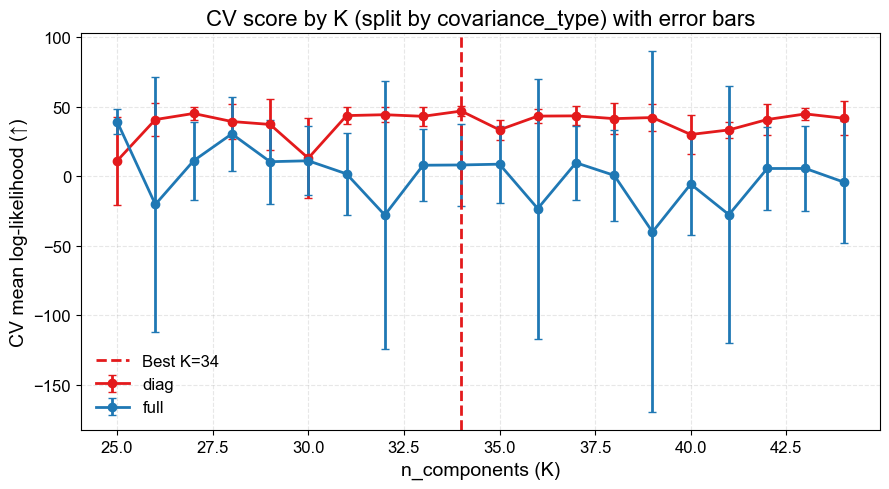

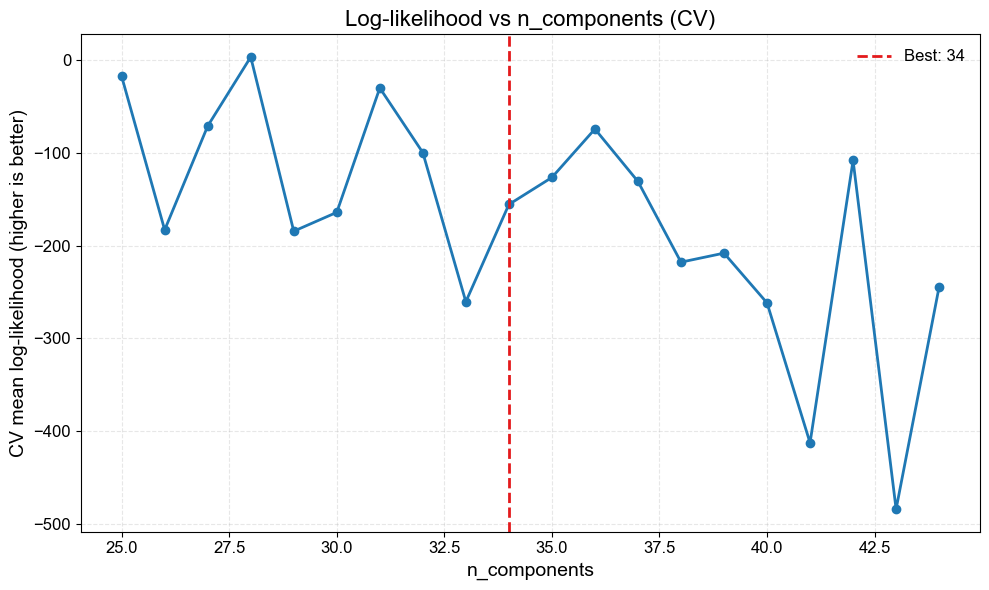


✅ 完整Pipeline已保存到: gmm_model_34c_fixed.pkl
✅ 修复版本GMM模型训练完成！

开始环境相似度评分...
✅ 环境相似度得分计算完成！
密度范围: [0.000000, 13741447255518889918622334976.000000]
环境分数范围: [0.000000, 0.957188]
标定来源: 未知
使用的标定均值: 49.254267
✅ Results saved: data/US_data/abandon_filtered_with_gmm_scores.csv
(Use merge_id to join with original data by index, or spatial join with lat/lon)

Running similarity diagnostics (log-density/PIT/PCA/MD²)...


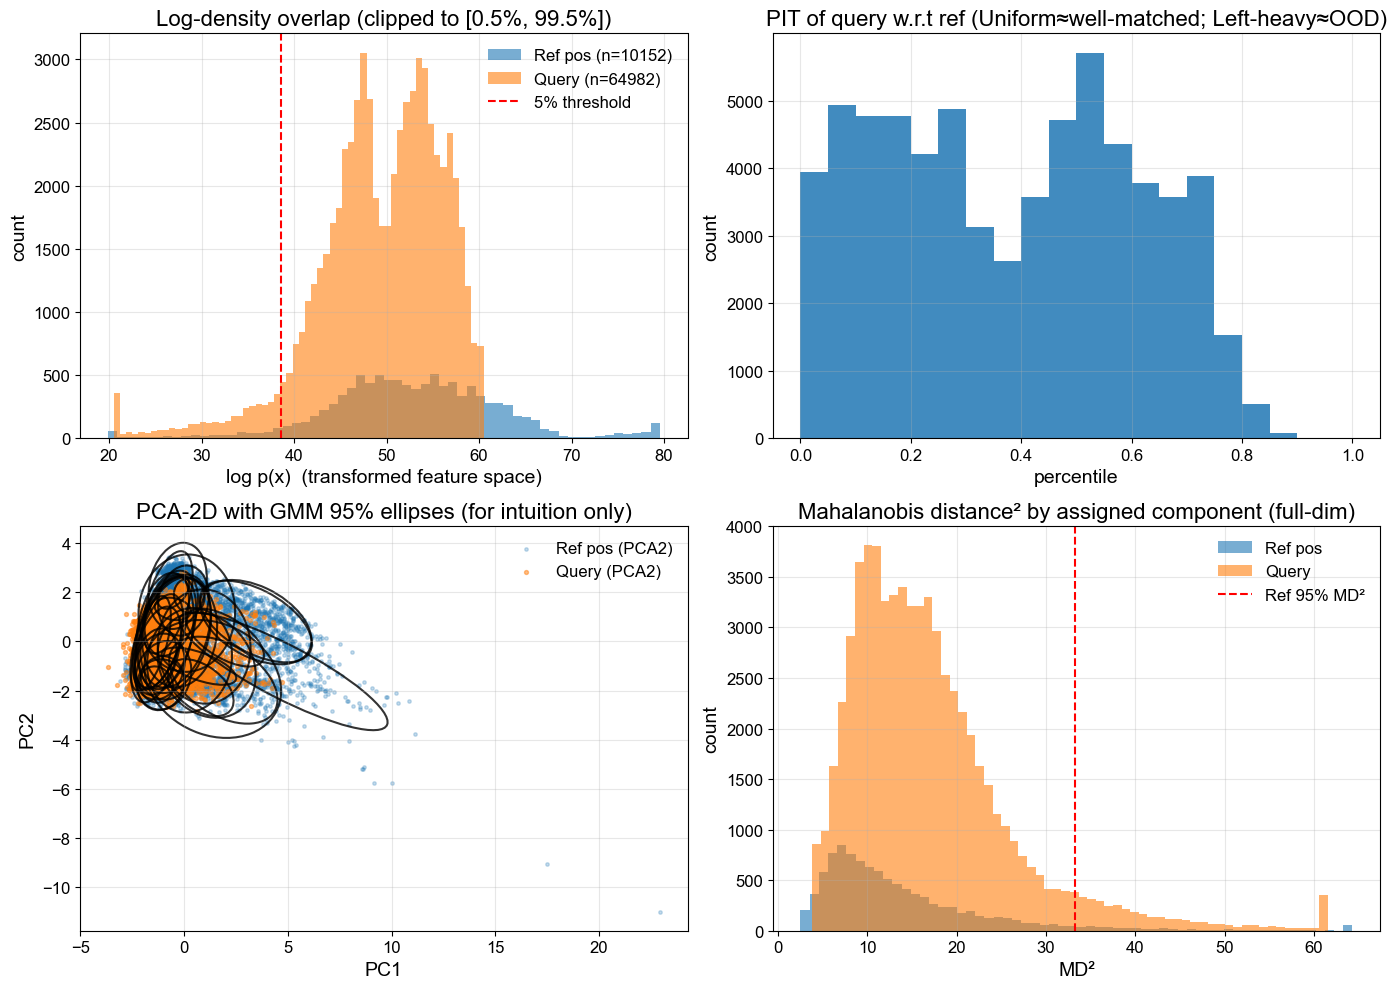


                    相似性诊断详细报告

📊 数据概览:
  参考正样本: 10,152 个
  查询样本: 64,982 个

🎯 基于Log-Density的相似性分层:
  🔥 极度相似 (>95%分位): 0 个 (0.0%)
  ✨ 高度相似 (75%-95%): 2,129 个 (3.3%)
  📈 中等相似 (25%-75%): 40,216 个 (61.9%)
  ⚠️ 低度相似 (5%-25%): 18,698 个 (28.8%)
  ❌ 异常值 (<5%分位): 3,939 个 (6.1%)

🎲 概率积分变换(PIT)分析:
  均匀性偏离度: 2847.160 (越小越好, <3249.1为良好)
  左偏重比例: 28.3% (高值表示查询样本偏离参考分布)
  右偏重比例: 0.9%
  PIT分布上下四分位数: Q1=0.179 ± 0.001 (95%CI: 0.177 ~ 0.181)
                      Q2/中位数=0.388 ± 0.001 (95%CI: 0.385 ~ 0.390)
                      Q3=0.566 ± 0.001 (95%CI: 0.564 ~ 0.569)
  PIT均值: 0.381 ± 0.001 (95%CI: 0.379 ~ 0.383)

📏 马氏距离统计:
  中位数以内: 28.3%
  90%分位以内: 87.3%
  95%分位以内: 94.0%
  异常值(>99%): 1.0%

🏆 综合相似性评分:
  Log-density得分: 61.2/100
  PIT均匀性得分: 56.2/100
  马氏距离得分: 87.3/100
  ⭐ 总体相似性: 67.6/100
  📝 解释: 🟡 良好 - 查询样本与参考分布较为一致

💡 实际应用意义:
  ✅ 93.9%的撂荒地具有与已建光伏高度相似的环境特征
  🎯 建议优先开发: 0个极度相似 + 2,129个高度相似地点
✅ Similarity diagnostics saved: data/US_data\similarity_diagnostics_20250813_071041.png
   5% 阈值(log p): 38.633968 | re

<Figure size 640x480 with 0 Axes>

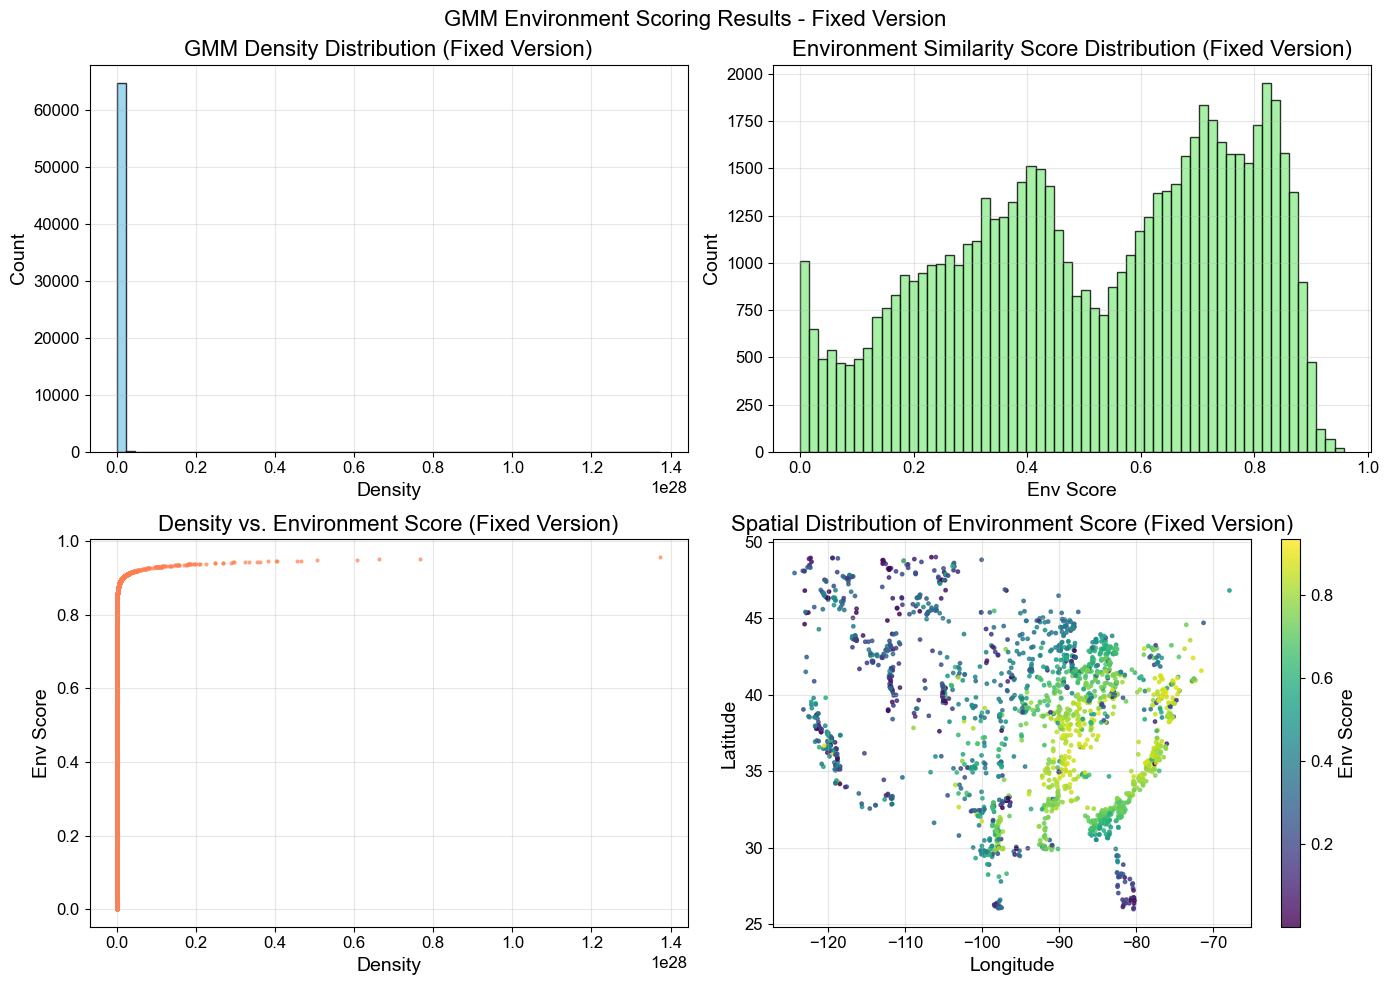

In [8]:
# -*- coding: utf-8 -*-
"""
Run GMM environment scoring on US mainland points.
- 使用第二次裁剪后的 df_embedding_fill[features_no_coords] 训练
- 对 df_abandon_filtered[features_no_coords] 打分
- 仅保存最终结果（含 merge_id 列，便于与原数据拼接）
- 输出关键性能图表（密度分布、得分分布、密度-得分散点）
"""

from function import *  # 需要包含: PATHS, load_abandon, load_embedding, fill_nonpositive_with_nearest,
                        # filter_duplicates, select_and_train_gmm, 
                        # NUMERIC_FEATURES, CAT_COLS
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import os
import json
from datetime import datetime


def clip_data_with_us_states(df, us_states_gdf, lon_col='lon', lat_col='lat'):
    """
    使用美国州界 shapefile 剪裁点数据；兼容不同版本的 geopandas 参数名
    """
    geometry = [Point(xy) for xy in zip(df[lon_col], df[lat_col])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')
    us_states_4326 = us_states_gdf.to_crs('EPSG:4326')

    try:
        clipped = gpd.sjoin(gdf, us_states_4326, how='inner', predicate='within')
    except TypeError:
        # 旧版本 geopandas 使用 op 参数
        clipped = gpd.sjoin(gdf, us_states_4326, how='inner', op='within')

    # 清理 shapefile 附加字段
    clipped = clipped.drop(columns=['geometry', 'index_right'], errors='ignore')
    for col in us_states_gdf.columns:
        if col in clipped.columns:
            clipped = clipped.drop(columns=[col], errors='ignore')
    return clipped


if __name__ == '__main__':
    np.random.seed(42)

    # ---------------------------
    # 0) 基础地理范围与底图
    # ---------------------------
    usa_bounds_main = dict(lon_min=-125, lon_max=-65, lat_min=25, lat_max=49)
    us_states = gpd.read_file(r'data\cb_2018_us_state_500k.shp')

    # ---------------------------
    # 1) 读取数据
    # ---------------------------
    df_abandon = load_abandon(PATHS['us_abandon'])
    df_embedding = load_embedding(PATHS['us_pv_embedding'])

    # 初步经纬度范围过滤
    df_embedding = df_embedding[
        (df_embedding['lon'] >= usa_bounds_main['lon_min']) &
        (df_embedding['lon'] <= usa_bounds_main['lon_max']) &
        (df_embedding['lat'] >= usa_bounds_main['lat_min']) &
        (df_embedding['lat'] <= usa_bounds_main['lat_max'])
    ]

    # 第二次用州界矢量更精确裁剪
    df_abandon = clip_data_with_us_states(df_abandon, us_states)
    df_embedding = clip_data_with_us_states(df_embedding, us_states)

    # ---------------------------
    # 2) 缺失值填充 + 去重
    # ---------------------------
    df_abandon_fill   = fill_nonpositive_with_nearest(df_abandon)
    df_embedding_fill = fill_nonpositive_with_nearest(df_embedding)

    df_abandon_filtered = filter_duplicates(df_abandon_fill, df_embedding_fill)

     # ---------------------------
    # 3) 特征选择（排除经纬度）
    # ---------------------------
    features_no_coords = [f for f in (NUMERIC_FEATURES + CAT_COLS) if f not in ['lat', 'lon']]

    # 为稳妥，取交集（防止列名不在 DataFrame 中导致 KeyError）
    features_no_coords = [c for c in features_no_coords if c in df_embedding_fill.columns]
    print(f"使用的特征数量: {len(features_no_coords)}")
    print(f"特征列表: {features_no_coords}")

    # ---------------------------
    # 4) 训练修复版本的GMM（解决数据泄露）
    # ---------------------------
    print("\n开始训练修复版本的GMM模型...")
    gmm_pipeline = select_and_train_gmm(df_embedding_fill[features_no_coords])

    print("✅ 修复版本GMM模型训练完成！")

    # # 训练完成后，计算并保存标定参数（测试一致性，慎用！！！）
    # print("\n计算并保存标定参数...")

    # X_train_processed = gmm_pipeline.named_steps['preprocessor'].transform(df_embedding_fill[features_no_coords])
    # gmm_trained = gmm_pipeline.named_steps['gmm']
    # logdens_train = gmm_trained.score_samples(X_train_processed)

    # # 保存标定参数到pipeline
    # calibration_stats = {
    #     'mu': float(logdens_train.mean()),
    #     'mean': float(logdens_train.mean()),
    #     'std': float(logdens_train.std()),
    #     'min': float(logdens_train.min()),
    #     'max': float(logdens_train.max()),
    #     'n_samples': len(logdens_train),
    #     'method': 'sigmoid',
    #     'sigmoid_alpha': 1.0
    # }

    # # 将标定参数附加到pipeline
    # gmm_pipeline.calibration_ = calibration_stats

    # print(f"✅ 标定参数已保存:")
    # print(f"   均值: {calibration_stats['mu']:.6f}")
    # print(f"   标准差: {calibration_stats['std']:.6f}")
    # print(f"   范围: [{calibration_stats['min']:.6f}, {calibration_stats['max']:.6f}]")

    # ---------------------------
    # 5) 使用修复版本进行环境评分
    # ---------------------------
    print("\n开始环境相似度评分...")

    # 使用你的 score_env函数
    dens, env_scores, stats = score_env(
        gmm_pipeline, 
        df_abandon_filtered[features_no_coords],
        method='sigmoid',
        sigmoid_alpha=0.2,
        reference_stats=None,  
        return_logdens=False
    )

    print("✅ 环境相似度得分计算完成！")
    print(f"密度范围: [{dens.min():.6f}, {dens.max():.6f}]")
    print(f"环境分数范围: [{env_scores.min():.6f}, {env_scores.max():.6f}]")
    print(f"标定来源: {stats.get('calibration_source', '未知')}")
    print(f"使用的标定均值: {stats['mu']:.6f}")

    # ---------------------------
    # 6) 一致性验证测试
    # ---------------------------
    # print("\n进行一致性验证测试...")

    # # 测试样本
    # test_sample = df_abandon_filtered[features_no_coords].head(1000)

    # # 第一次预测
    # dens1, scores1, stats1 = score_env(
    #     gmm_pipeline, 
    #     test_sample,
    #     method='sigmoid',
    #     sigmoid_alpha=1.0
    # )

    # # 第二次预测（应该完全一致）
    # dens2, scores2, stats2 = score_env(
    #     gmm_pipeline, 
    #     test_sample,
    #     method='sigmoid',
    #     sigmoid_alpha=1.0
    # )

    # # # 检查一致性
    # # dens_consistent = np.allclose(dens1, dens2, rtol=1e-10)
    # # scores_consistent = np.allclose(scores1, scores2, rtol=1e-10)

    # print(f"✅ 密度预测一致性: {dens_consistent}")
    # print(f"✅ 分数预测一致性: {scores_consistent}")

    # if dens_consistent and scores_consistent:
    #     print("🎉 完美！预测结果完全一致")
    # else:
    #     print("⚠️ 警告：预测结果不一致，请检查")

    # ---------------------------
    # 6) 保存最终结果（含 merge_id 便于回拼）
    # ---------------------------
    save_dir = "data/US_data"
    os.makedirs(save_dir, exist_ok=True)
    # 将环境分数和密度等结果与原始数据通过 'lat' 和 'lon' 两列组合 merge 合并输出
    # 构建结果DataFrame
    results = pd.DataFrame({
        'lon': df_abandon_filtered['lon'].values,
        'lat': df_abandon_filtered['lat'].values,
        'gmm_density': dens,
        'gmm_env_score': env_scores,
    })

    # 将results merge到df_abandon_filtered
    df_abandon_filtered = pd.merge(
        df_abandon_filtered,
        results[['lat', 'lon', 'gmm_density', 'gmm_env_score']],
        on=['lat', 'lon'],
        how='left'
    )

    # 输出合并后的结果
    df_abandon_filtered.to_csv('data/US_data/abandon_filtered_with_gmm_scores.csv', index=False)

    print(f"✅ Results saved: data/US_data/abandon_filtered_with_gmm_scores.csv")
    print("(Use merge_id to join with original data by index, or spatial join with lat/lon)")


    # ---------------------------
    # 7) 相似性可视化诊断（log-density / PIT / PCA / Mahalanobis）
    # ---------------------------
    print("\nRunning similarity diagnostics (log-density/PIT/PCA/MD²)...")
    try:
        # 以 df_embedding_fill 作为参考正样本；df_abandon_filtered 作为待评数据
        diag_out = visualize_similarity_diagnostics(
            gmm_pipeline,
            df_ref_pos=df_embedding_fill[features_no_coords],
            df_query=df_abandon_filtered[features_no_coords],
            q_cut=0.05,            # 参考集5%分位阈值（可改成0.10或0.01）
            max_points_pca=8000,   # PCA投影用于可视化的最大采样数
            random_state=42
        )

        # 立即保存当前生成的诊断图
        diag_ts = datetime.now().strftime("%Y%m%d_%H%M%S")
        diag_path = os.path.join(save_dir, f"similarity_diagnostics_{diag_ts}.png")
        plt.gcf().savefig(diag_path, dpi=300, bbox_inches='tight')
        print(f"✅ Similarity diagnostics saved: {diag_path}")
        print(f"   5% 阈值(log p): {diag_out['logp_threshold_value']:.6f} | "
              f"ref μ={diag_out['logp_ref_mean']:.6f}, σ={diag_out['logp_ref_std']:.6f}")

        # 可选：如果你不想重复显示，保存后可以关闭当前图
        # plt.close()

    except NameError as e:
        print("⚠️ 找不到 visualize_similarity_diagnostics，请确认该函数已在 function.py 或本文件中定义。")
        print(f"   详细信息: {e}")
    except Exception as e:
        print(f"⚠️ 相似性诊断绘图失败: {e}")



    # ---------------------------
    # 7) 测试模型加载和预测
    # ---------------------------
    # print("\n测试模型加载和预测...")
    
    # # 假设模型文件名（根据实际训练结果调整）
    # model_files = [f for f in os.listdir('.') if f.startswith('gmm_model_') and f.endswith('_fixed.pkl')]
    
    # if model_files:
    #     model_filename = model_files[0]  # 选择第一个匹配的文件
    #     print(f"找到保存的模型: {model_filename}")
        
    #     # 测试样本
    #     test_sample = df_abandon_filtered[features_no_coords].head(1000)

    #     print("\n方法1：使用 predict_with_saved_pipeline_v2")
    #     dens_loaded, scores_loaded, stats_loaded = predict_with_saved_pipeline_v2(
    #         test_sample, 
    #         model_filename, 
    #         method='sigmoid',
    #         sigmoid_alpha=1.0,
    #         return_stats=True
    #     )
        
    #     if dens_loaded is not None:
    #         print(f"✅ 模型加载测试成功！")
    #         print(f"测试样本预测密度范围: [{dens_loaded.min():.6f}, {dens_loaded.max():.6f}]")
    #         print(f"测试样本预测分数范围: [{scores_loaded.min():.6f}, {scores_loaded.max():.6f}]")
    #         print(f"标定来源: {stats_loaded.get('calibration_source', '未知')}")
            
    #         # 验证一致性（前1000个样本）
    #         original_dens = dens[:1000]
    #         original_scores = env_scores[:1000]
    #         consistency_dens = np.allclose(original_dens, dens_loaded, rtol=1e-6)
    #         consistency_scores = np.allclose(original_scores, scores_loaded, rtol=1e-6)
            
    #         print(f"密度预测一致性: {consistency_dens}")
    #         print(f"分数预测一致性: {consistency_scores}")
            
    #         if consistency_dens and consistency_scores:
    #             print("🎉 完美！预测结果完全一致")
    #         else:
    #             print("ℹ️ 注意：可能由于不同的标定参数导致轻微差异")
    #     else:
    #         print("⚠️ 模型加载测试失败")
    

    # ---------------------------
    # 8) 关键性能图表
    # ---------------------------
    print("\nGenerating key performance plots...")
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Density distribution
    axes[0, 0].hist(dens, bins=60, alpha=0.8, color='skyblue', edgecolor='black')
    axes[0, 0].set_title('GMM Density Distribution (Fixed Version)')
    axes[0, 0].set_xlabel('Density')
    axes[0, 0].set_ylabel('Count')
    axes[0, 0].grid(True, alpha=0.3)

    # Environment score distribution
    axes[0, 1].hist(env_scores, bins=60, alpha=0.8, color='lightgreen', edgecolor='black')
    axes[0, 1].set_title('Environment Similarity Score Distribution (Fixed Version)')
    axes[0, 1].set_xlabel('Env Score')
    axes[0, 1].set_ylabel('Count')
    axes[0, 1].grid(True, alpha=0.3)

    # Density vs. Score
    axes[1, 0].scatter(dens, env_scores, s=4, alpha=0.6, c='coral')
    axes[1, 0].set_title('Density vs. Environment Score (Fixed Version)')
    axes[1, 0].set_xlabel('Density')
    axes[1, 0].set_ylabel('Env Score')
    axes[1, 0].grid(True, alpha=0.3)

    # Spatial sampling visualization
    sample_n = min(2000, len(results))
    idx = np.random.choice(len(results), sample_n, replace=False)
    sc = axes[1, 1].scatter(results.loc[idx, 'lon'], results.loc[idx, 'lat'],
                            c=results.loc[idx, 'gmm_env_score'].values, s=6, alpha=0.8, cmap='viridis')
    axes[1, 1].set_title('Spatial Distribution of Environment Score (Fixed Version)')
    axes[1, 1].set_xlabel('Longitude')
    axes[1, 1].set_ylabel('Latitude')
    axes[1, 1].grid(True, alpha=0.3)
    plt.colorbar(sc, ax=axes[1, 1], label='Env Score')

    plt.suptitle('GMM Environment Scoring Results - Fixed Version', fontsize=16, y=0.98)
    plt.tight_layout()
    
    # 保存图表
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    fig_path = os.path.join(save_dir, f"gmm_env_key_plots_fixed_{timestamp}.png")
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    print(f"✅ Plots saved: {fig_path}")
    plt.show()

    # ---------------------------
    # 9) 模型信息总结
    # ---------------------------
    # print("\n" + "=" * 60)
    # print("模型信息总结:")
    # print("=" * 60)
    
    # if gmm_pipeline:
    #     # 获取预处理器信息
    #     preprocessor = gmm_pipeline.named_steps['preprocessor']
    #     feature_info = preprocessor.get_feature_info()
        
    #     # 获取GMM信息
    #     gmm = gmm_pipeline.named_steps['gmm']
        
    #     print(f"✅ 使用修复版本Pipeline，解决数据泄露问题")
    #     print(f"✅ GMM组件数: {gmm.n_components}")
    #     print(f"✅ 协方差类型: {gmm.covariance_type}")
    #     print(f"✅ 分类特征信息: {feature_info}")
    #     print(f"✅ 训练样本数: {len(df_embedding_fill)}")
    #     print(f"✅ 预测样本数: {len(df_abandon_filtered)}")
    #     print(f"✅ 特征数量: {len(features_no_coords)}")
        
        # if model_files:
        #     print(f"✅ 模型文件: {model_files[0]}")
        
    print("=" * 60)

In [9]:
df_abandon_filtered.gmm_env_score.describe()

count    6.498200e+04
mean     5.177997e-01
std      2.479391e-01
min      8.108895e-14
25%      3.222062e-01
50%      5.459391e-01
75%      7.353465e-01
max      9.571883e-01
Name: gmm_env_score, dtype: float64

## GMM估计输出数据检查

You want to predict the year: 2020.0
列 GDPpc 没有需要填充的非正值或NaN值
列 GURdist 没有需要填充的非正值或NaN值
列 GDPpc 没有需要填充的非正值或NaN值
列 GURdist 没有需要填充的非正值或NaN值

[载入模型] gmm_model_34c_fixed.pkl ...
✅ GMM pipeline loaded.
Running similarity diagnostics (log-density/PIT/PCA/MD²)...


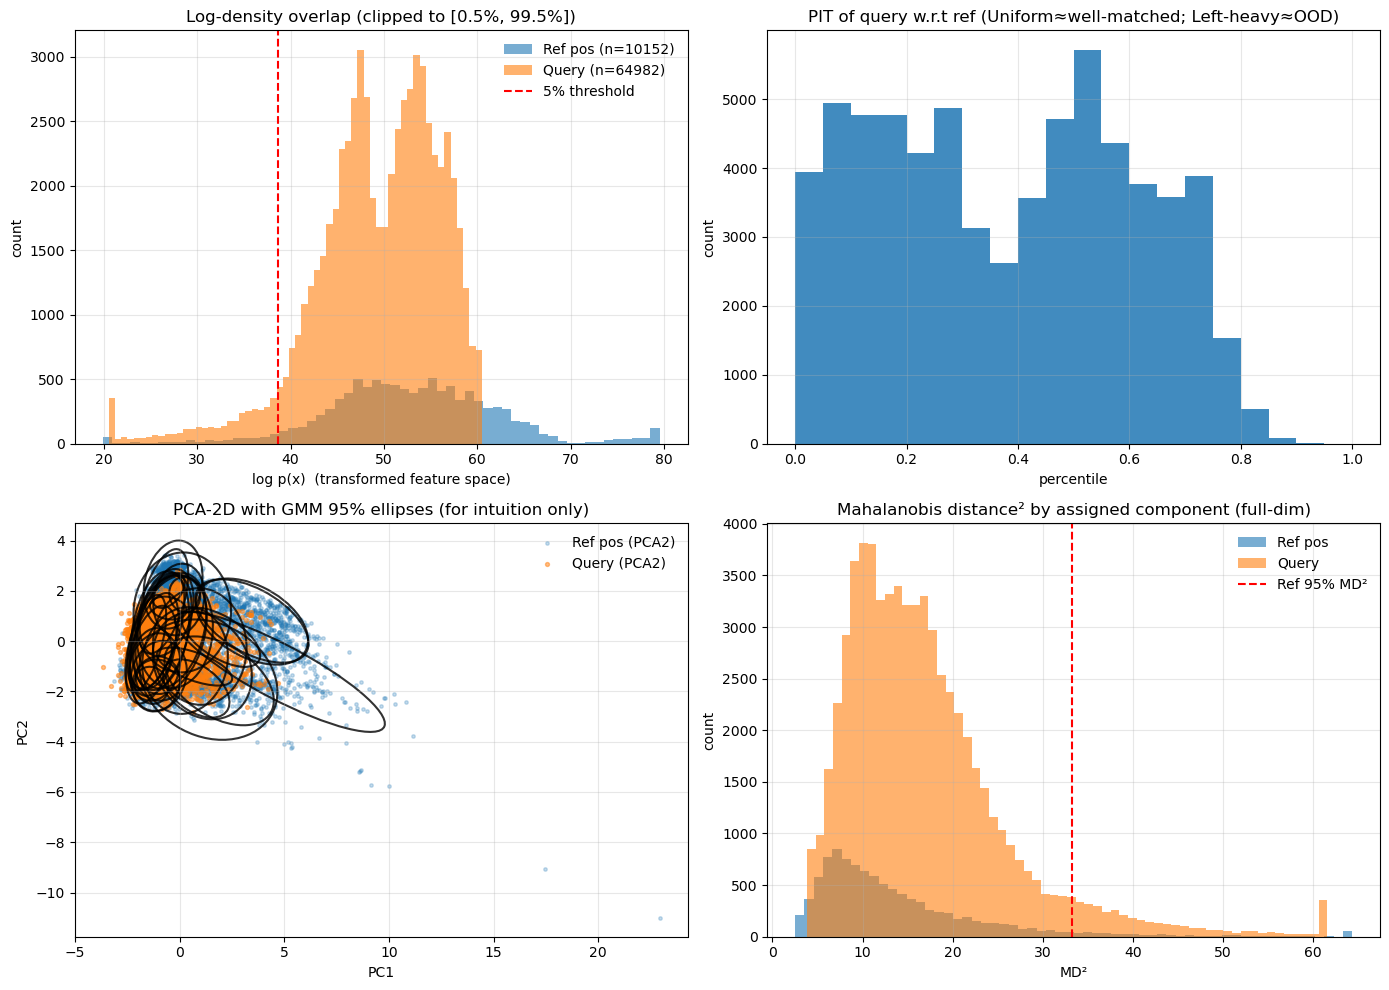


                    相似性诊断详细报告

📊 数据概览:
  参考正样本: 10,152 个
  查询样本: 64,982 个

🎯 基于Log-Density的相似性分层:
  🔥 极度相似 (>95%分位): 0 个 (0.0%)
  ✨ 高度相似 (75%-95%): 2,129 个 (3.3%)
  📈 中等相似 (25%-75%): 40,216 个 (61.9%)
  ⚠️ 低度相似 (5%-25%): 18,698 个 (28.8%)
  ❌ 异常值 (<5%分位): 3,939 个 (6.1%)

🎲 概率积分变换(PIT)分析:
  均匀性偏离度: 2847.160 (越小越好, <3249.1为良好)
  左偏重比例: 28.3% (高值表示查询样本偏离参考分布)
  右偏重比例: 0.9%
  PIT分布上下四分位数: Q1=0.179 ± 0.001 (95%CI: 0.177 ~ 0.181)
                      Q2/中位数=0.388 ± 0.001 (95%CI: 0.385 ~ 0.390)
                      Q3=0.566 ± 0.001 (95%CI: 0.564 ~ 0.569)
  PIT均值: 0.381 ± 0.001 (95%CI: 0.379 ~ 0.383)

📏 马氏距离统计:
  中位数以内: 28.3%
  90%分位以内: 87.3%
  95%分位以内: 94.0%
  异常值(>99%): 1.0%

🏆 综合相似性评分:
  Log-density得分: 61.2/100
  PIT均匀性得分: 56.2/100
  马氏距离得分: 87.3/100
  ⭐ 总体相似性: 67.6/100
  📝 解释: 🟡 良好 - 查询样本与参考分布较为一致

💡 实际应用意义:
  ✅ 93.9%的撂荒地具有与已建光伏高度相似的环境特征
  🎯 建议优先开发: 0个极度相似 + 2,129个高度相似地点
⚠️ 找不到 visualize_similarity_diagnostics，请确认该函数已在 function.py 或本文件中定义。
   详细信息: name 'save_dir' is not defined


In [20]:

import joblib
from function import *  
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import os
import json
from datetime import datetime


def clip_data_with_us_states(df, us_states_gdf, lon_col='lon', lat_col='lat'):
    """
    使用美国州界 shapefile 剪裁点数据；兼容不同版本的 geopandas 参数名
    """
    geometry = [Point(xy) for xy in zip(df[lon_col], df[lat_col])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')
    us_states_4326 = us_states_gdf.to_crs('EPSG:4326')

    try:
        clipped = gpd.sjoin(gdf, us_states_4326, how='inner', predicate='within')
    except TypeError:
        # 旧版本 geopandas 使用 op 参数
        clipped = gpd.sjoin(gdf, us_states_4326, how='inner', op='within')

    # 清理 shapefile 附加字段
    clipped = clipped.drop(columns=['geometry', 'index_right'], errors='ignore')
    for col in us_states_gdf.columns:
        if col in clipped.columns:
            clipped = clipped.drop(columns=[col], errors='ignore')
    return clipped



np.random.seed(42)

# ---------------------------
# 0) 基础地理范围与底图
# ---------------------------
usa_bounds_main = dict(lon_min=-125, lon_max=-65, lat_min=25, lat_max=49)
us_states = gpd.read_file(r'data\cb_2018_us_state_500k.shp')

# ---------------------------
# 1) 读取数据
# ---------------------------
df_abandon = load_abandon(PATHS['us_abandon'])
df_embedding = load_embedding(PATHS['us_pv_embedding'])

# 初步经纬度范围过滤
df_embedding = df_embedding[
    (df_embedding['lon'] >= usa_bounds_main['lon_min']) &
    (df_embedding['lon'] <= usa_bounds_main['lon_max']) &
    (df_embedding['lat'] >= usa_bounds_main['lat_min']) &
    (df_embedding['lat'] <= usa_bounds_main['lat_max'])
]

# 第二次用州界矢量更精确裁剪
df_abandon = clip_data_with_us_states(df_abandon, us_states)
df_embedding = clip_data_with_us_states(df_embedding, us_states)

# ---------------------------
# 2) 缺失值填充 + 去重
# ---------------------------
df_abandon_fill   = fill_nonpositive_with_nearest(df_abandon)
df_embedding_fill = fill_nonpositive_with_nearest(df_embedding)

df_abandon_filtered = filter_duplicates(df_abandon_fill, df_embedding_fill)

    # ---------------------------
# 3) 特征选择（排除经纬度）
# ---------------------------
features_no_coords = [f for f in (NUMERIC_FEATURES + CAT_COLS) if f not in ['lat', 'lon']]

# 为稳妥，取交集（防止列名不在 DataFrame 中导致 KeyError）
features_no_coords = [c for c in features_no_coords if c in df_embedding_fill.columns]
print("\n[载入模型] gmm_model_34c_fixed.pkl ...")
try:
    gmm_pipeline = joblib.load("gmm_model_34c_fixed.pkl")
    print("✅ GMM pipeline loaded.")
except Exception as e:
    print(f"❌ 加载模型失败: {e}")
    raise

print("Running similarity diagnostics (log-density/PIT/PCA/MD²)...")
try:
    diag_out = visualize_similarity_diagnostics(
        gmm_pipeline,
        df_ref_pos=df_embedding_fill[features_no_coords],
        df_query=df_abandon_filtered[features_no_coords],
        q_cut=0.05,
        max_points_pca=8000,
        random_state=42
    )
    diag_ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    diag_path = os.path.join(save_dir, f"similarity_diagnostics_{diag_ts}.png")
    plt.gcf().savefig(diag_path, dpi=300, bbox_inches='tight')
    print(f"✅ Similarity diagnostics saved: {diag_path}")
    print(f"   5% 阈值(log p): {diag_out['logp_threshold_value']:.6f} | "
          f"ref μ={diag_out['logp_ref_mean']:.6f}, σ={diag_out['logp_ref_std']:.6f}")
except NameError as e:
    print("⚠️ 找不到 visualize_similarity_diagnostics，请确认该函数已在 function.py 或本文件中定义。")
    print(f"   详细信息: {e}")
except Exception as e:
    print(f"⚠️ 相似性诊断绘图失败: {e}")

# Version 2（深度学习版本）

You want to predict the year: 2020.0
列 GDPpc 没有需要填充的非正值或NaN值
列 GURdist 没有需要填充的非正值或NaN值
列 GDPpc 没有需要填充的非正值或NaN值
列 GURdist 没有需要填充的非正值或NaN值
正确的训练管道：分层负样本采样的完整流程

步骤1: 加载或训练GMM模型用于环境相似度评估
🔍 发现已保存的GMM模型文件: gmm_model_34c_fixed.pkl
📂 尝试加载模型...
✅ 成功加载GMM模型: gmm_model_34c_fixed.pkl
   模型组件数: 34
   协方差类型: diag

步骤2: 分层负样本采样
基于已训练GMM + 参考分位校准的负样本采样（PIT 分层）
Using trained GMM model: 34 components, diag covariance
Computing log-density for reference set and prediction pool...
Reference set log-density: mean=52.869, std=9.537
Prediction pool log-density: mean=49.254, std=7.102
Building reference empirical distribution and computing PIT...
✅ Robust calibration parameters attached to pipeline
Computing sigmoid scores (for visualization only)...
Reference log-density quantiles: Q5=38.634, Q20=46.141, Q40=50.457
Prediction pool PIT quantiles: Q5=0.040, Q10=0.078, Q25=0.179, Q50=0.388, Q75=0.566

Sampling configuration:
  Number of positive samples: 10152
  Target negative samples: 2538 (ratio=0.25)
  PIT

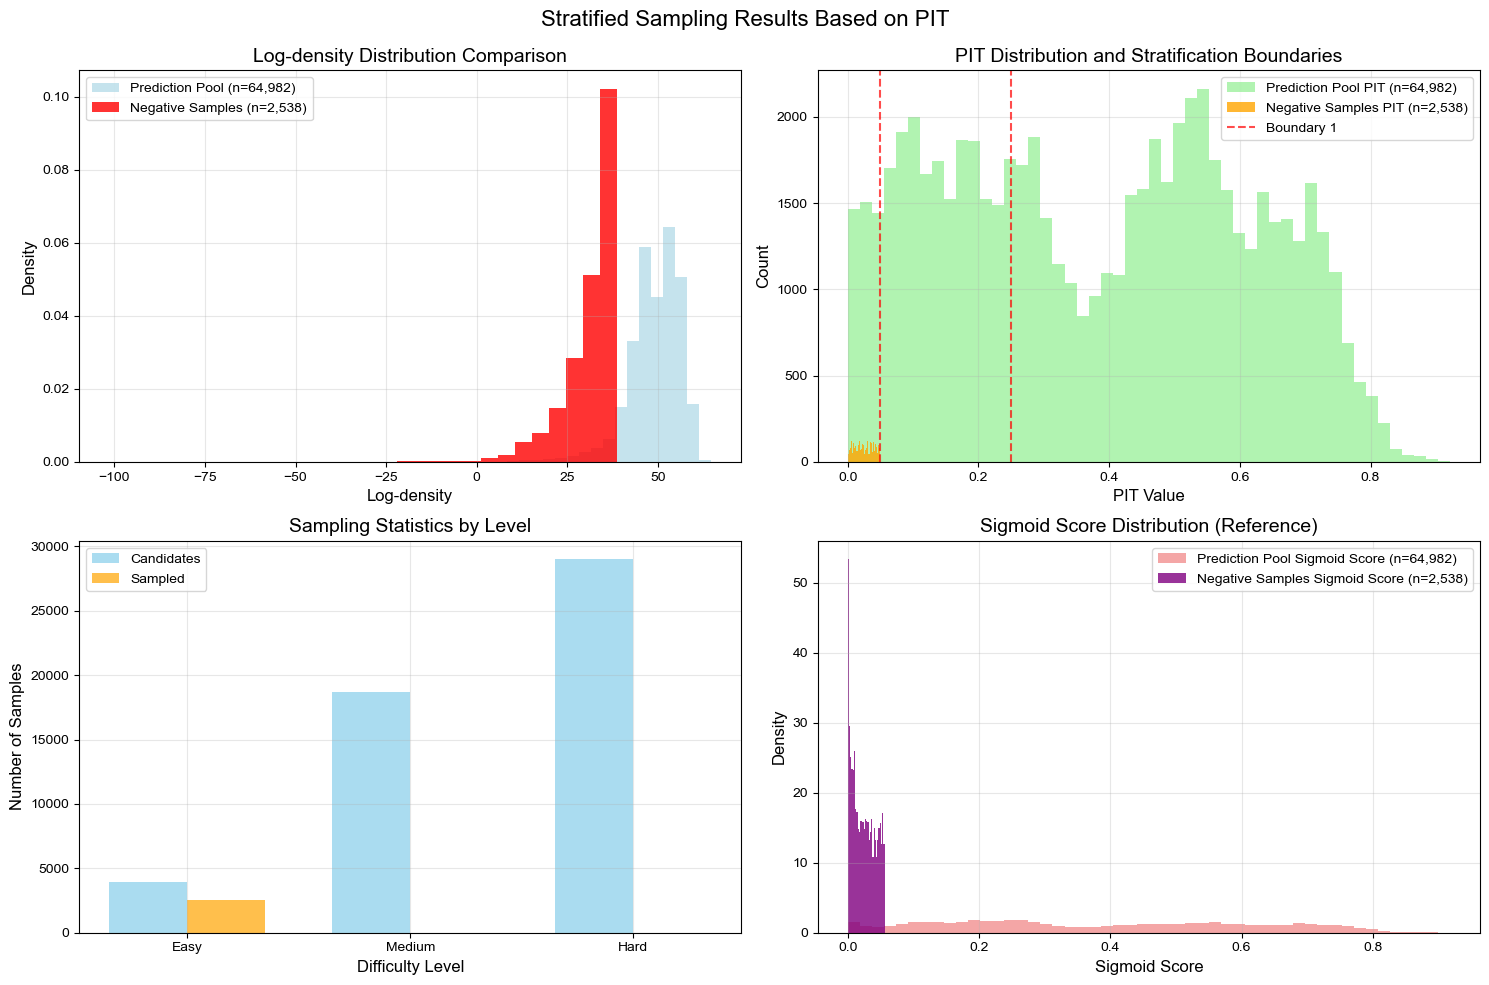


步骤3: 训练深度学习分类模型
训练深度学习分类器
✅ TensorFlow确定性模式已启用
准备原始数据...
原始特征: (12690, 15)
标签分布: 正样本=10152, 负样本=2538, 正样本比例=0.800
先划分原始数据...
原始数据划分完成:
  训练集: (7614, 15) (正样本比例: 0.800)
  验证集: (2538, 15) (正样本比例: 0.800)
  测试集: (2538, 15) (正样本比例: 0.800)
在训练集上重新拟合预处理器...
✅ 预处理器已在训练集上重新拟合（避免正样本偏差）

执行学习曲线分析（仅训练集，无泄露）...
生成神经网络学习曲线（增强版：含过拟合分析）
推断预处理后的特征维度...
✅ 推断的输入维度: 23
✅ 预期特征构成: 14个数值特征 + 9个landcover One-Hot = 23个总特征
开始学习曲线分析...
  数据集大小: 7614
  CV折数: 5
  训练大小: [0.2 0.4 0.6 0.8 1. ]
  输入特征维度: 23
Building deep learning model...
Input dim: 23 | Hidden: [128, 64, 32] | Params: 14,429
Building deep learning model...
Input dim: 23 | Hidden: [128, 64, 32] | Params: 14,429
Building deep learning model...
Input dim: 23 | Hidden: [128, 64, 32] | Params: 14,429
Building deep learning model...
Input dim: 23 | Hidden: [128, 64, 32] | Params: 14,429
Building deep learning model...
Input dim: 23 | Hidden: [128, 64, 32] | Params: 14,429
Building deep learning model...
Input dim: 23 | Hidden: [128, 64, 32] | Params: 14,4

C:\Users\zpy10\AppData\Local\Temp\ipykernel_9032\775921488.py:469: UserWarning: Glyph 26080 (\N{CJK UNIFIED IDEOGRAPH-65E0}) missing from current font.
  plt.tight_layout()
C:\Users\zpy10\AppData\Local\Temp\ipykernel_9032\775921488.py:469: UserWarning: Glyph 36807 (\N{CJK UNIFIED IDEOGRAPH-8FC7}) missing from current font.
  plt.tight_layout()
C:\Users\zpy10\AppData\Local\Temp\ipykernel_9032\775921488.py:469: UserWarning: Glyph 25311 (\N{CJK UNIFIED IDEOGRAPH-62DF}) missing from current font.
  plt.tight_layout()
C:\Users\zpy10\AppData\Local\Temp\ipykernel_9032\775921488.py:469: UserWarning: Glyph 21512 (\N{CJK UNIFIED IDEOGRAPH-5408}) missing from current font.
  plt.tight_layout()
c:\Users\zpy10\anaconda3\envs\geo\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26080 (\N{CJK UNIFIED IDEOGRAPH-65E0}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\zpy10\anaconda3\envs\geo\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: 

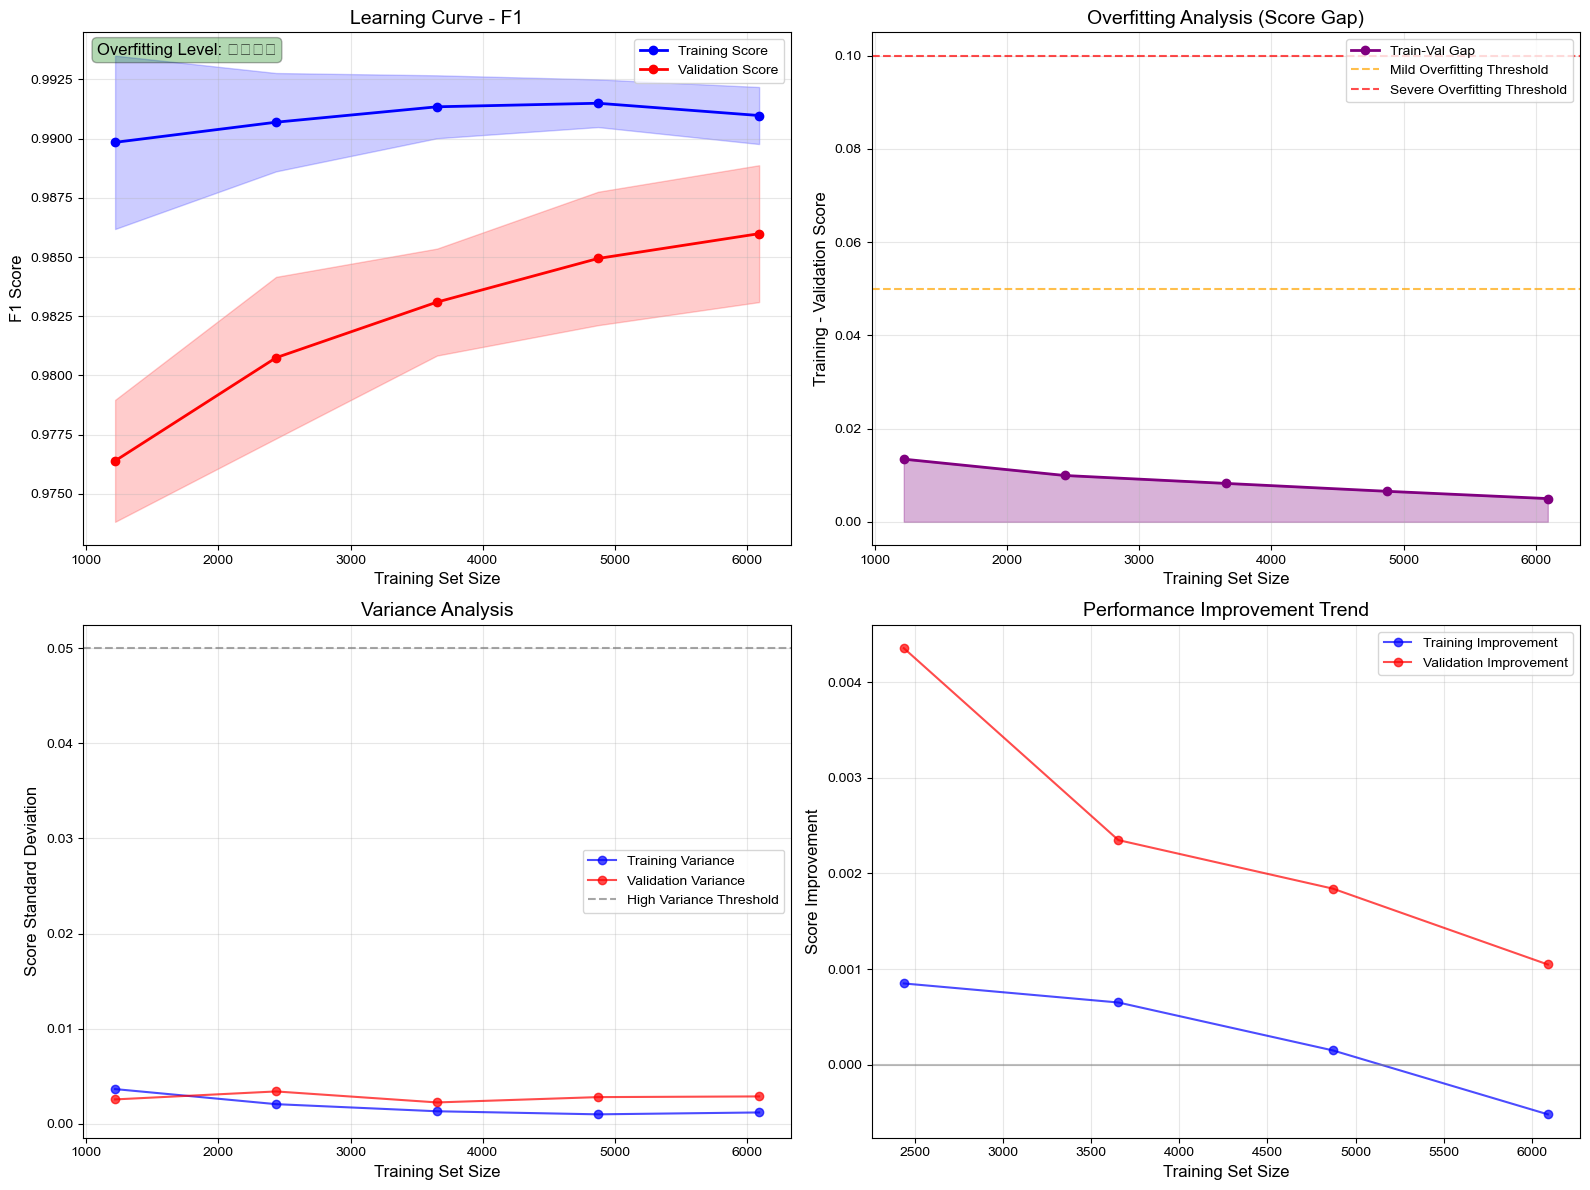


📊 详细学习曲线分析报告

🎯 基本性能指标:
  最终训练分数: 0.9910 (±0.0012)
  最终验证分数: 0.9860 (±0.0029)
  训练-验证差异: 0.0050

🔍 过拟合分析:
  过拟合程度: 无过拟合
  最大分数差异: 0.0134
  学习效率: 62.9%

📈 趋势分析:
  ✅ 验证性能持续改善
  📊 验证性能趋于稳定

📊 方差分析:
  训练方差: 0.0019
  验证方差: 0.0028
  ✅ 方差适中，模型相对稳定

✅ 模型表现良好，无需特殊调整

📋 总结:
  ✅ 模型拟合程度良好
  ✅ 模型方差适中

✅ 增强版学习曲线分析完成！
✅ 学习曲线分析完成
分别预处理三个数据集...
预处理后数据形状:
  训练集: (7614, 23)
  验证集: (2538, 23)
  测试集: (2538, 23)
构建深度学习模型...
Building deep learning model...
Input dim: 23 | Hidden: [128, 64, 32] | Params: 14,429
开始模型训练...
Epoch 1/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8038 - auc: 0.8785 - loss: 1.7782 - precision: 0.9391 - recall: 0.8071 - val_accuracy: 0.9338 - val_auc: 0.9902 - val_loss: 1.2269 - val_precision: 0.9278 - val_recall: 0.9946
Epoch 2/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9163 - auc: 0.9573 - loss: 1.0161 - precision: 0.9542 - recall: 0.9406 - val_accuracy: 0.9630 - val_auc: 0.9945 - val_loss: 0.7165 - val_precision: 0.9636 - val_recall: 0.9911
Epoch 3/50
2

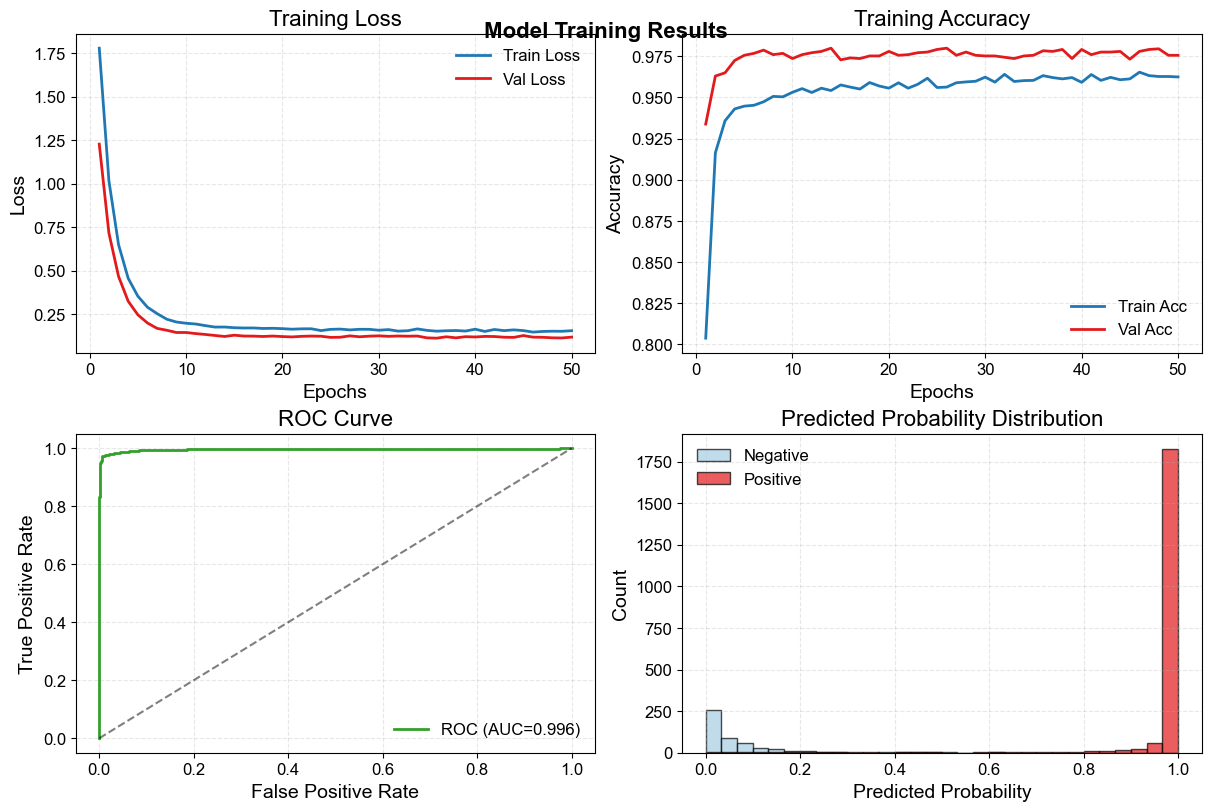

✅ 训练完成！已修复预处理偏差和随机种子问题

步骤4: 对剩余预测样本进行预测
剩余样本预测完成: 62444 个样本
预测为正类的数量: 48103
预测为正类的比例: 0.770
平均预测概率: 0.770

步骤5: 合并负样本和预测结果

检查GMM评分列:
  negative_results有gmm_score列: True
  prediction_results有gmm_score列: True
  final_results有gmm_score列: True
最终结果合并完成:
  负样本数量: 2538 (标签=0)
  预测样本数量: 62444
  总样本数量: 64982
  最终预测为正类的总数: 48103
  最终预测为正类的比例: 0.740

步骤6: SHAP特征重要性分析
Enhanced SHAP Analysis - 增强版因子贡献度分析
分析样本数: 2538
输入特征数量: 15
实际特征数量: 23
🔍 特征映射分析:
  - 预期数值特征: 14 个
  - 预期One-Hot特征: 9 个 (landcover)
  - 预期总特征数: 23 个
  - 实际特征数: 23 个
✅ 特征数量完全匹配，使用精确映射
✅ 智能特征映射完成，生成 23 个特征名
计算SHAP值...


c:\Users\zpy10\anaconda3\envs\geo\Lib\site-packages\shap\explainers\_deep\deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
c:\Users\zpy10\anaconda3\envs\geo\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_552
Received: inputs=['Tensor(shape=(50, 23))']
  warnings.warn(msg)
c:\Users\zpy10\anaconda3\envs\geo\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_552
Received: inputs=['Tensor(shape=(100, 23))']
  warnings.warn(msg)
c:\Users\zpy10\anaconda3

原始SHAP值形状: (2538, 23, 1)
修正后SHAP值形状: (2538, 23)
✅ SHAP值计算完成 (使用 DeepExplainer)

🔍 Landcover分类详细分析:
--------------------------------------------------
landcover_1 (类别1):
  样本数: 390 (15.4%)
  激活样本SHAP: 0.0429 ± 0.0005
  总体SHAP均值: -0.0006
  正向影响比例: 100.0%

landcover_2 (类别2):
  样本数: 489 (19.3%)
  激活样本SHAP: -0.0494 ± 0.0023
  总体SHAP均值: -0.0035
  正向影响比例: 5.3%

landcover_3 (类别3):
  样本数: 322 (12.7%)
  激活样本SHAP: -0.0297 ± 0.0026
  总体SHAP均值: 0.0054
  正向影响比例: 28.3%

landcover_4 (类别4):
  样本数: 421 (16.6%)
  激活样本SHAP: 0.0128 ± 0.0005
  总体SHAP均值: -0.0013
  正向影响比例: 100.0%

landcover_5 (类别5):
  样本数: 393 (15.5%)
  激活样本SHAP: -0.0062 ± 0.0017
  总体SHAP均值: -0.0019
  正向影响比例: 58.8%

landcover_6 (类别6):
  样本数: 171 (6.7%)
  激活样本SHAP: 0.0729 ± 0.0054
  总体SHAP均值: -0.0033
  正向影响比例: 99.4%

landcover_7 (类别7):
  样本数: 342 (13.5%)
  激活样本SHAP: 0.1160 ± 0.0038
  总体SHAP均值: 0.0009
  正向影响比例: 100.0%

landcover_8 (类别8):
  样本数: 8 (0.3%)
  激活样本SHAP: 0.1377 ± 0.0036
  总体SHAP均值: 0.0004
  正向影响比例: 100.0%

landcover_9 (类别9):
  样本数: 2

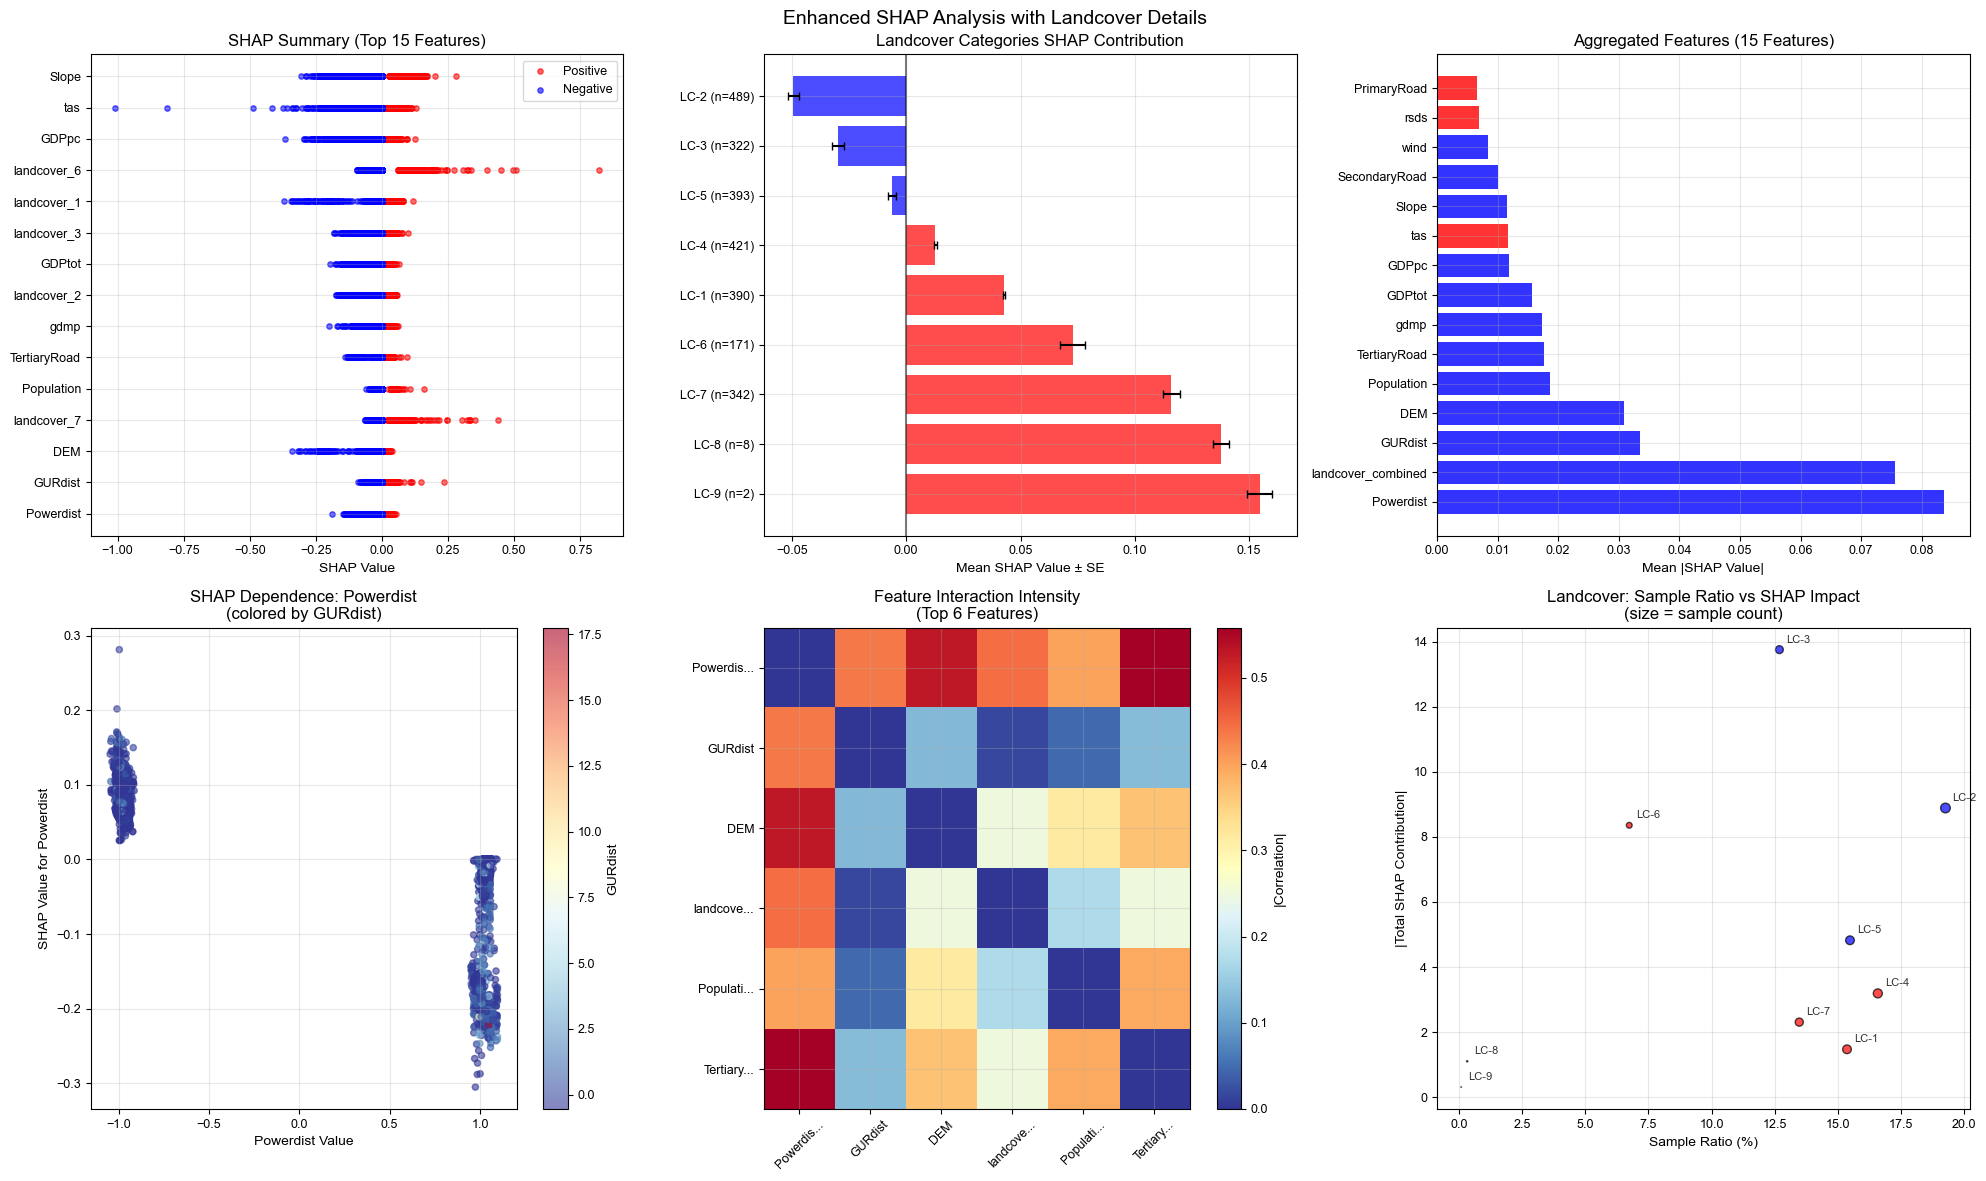


🔍 增强版SHAP分析详细报告

📊 原始特征统计 (23个特征):
Top 10 最重要特征 (原始特征):
     feature  mean_abs_shap  mean_shap  positive_ratio  positive_contribution  negative_contribution
   Powerdist         0.0837    -0.0043          0.5764               100.7893              -111.7249
     GURdist         0.0334    -0.0020          0.7427                39.8724               -45.0099
         DEM         0.0309    -0.0087          0.6438                28.1450               -50.2936
 landcover_7         0.0304     0.0009          0.1348                39.6850               -37.3785
  Population         0.0187    -0.0020          0.7782                21.1698               -26.2914
TertiaryRoad         0.0177    -0.0001          0.7636                22.2388               -22.5767
        gdmp         0.0174    -0.0042          0.7821                16.6634               -27.4215
 landcover_2         0.0162    -0.0035          0.7431                16.0623               -24.9521
      GDPtot         0.0157    -0.

C:\Users\zpy10\AppData\Local\Temp\ipykernel_9032\3578810522.py:962: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


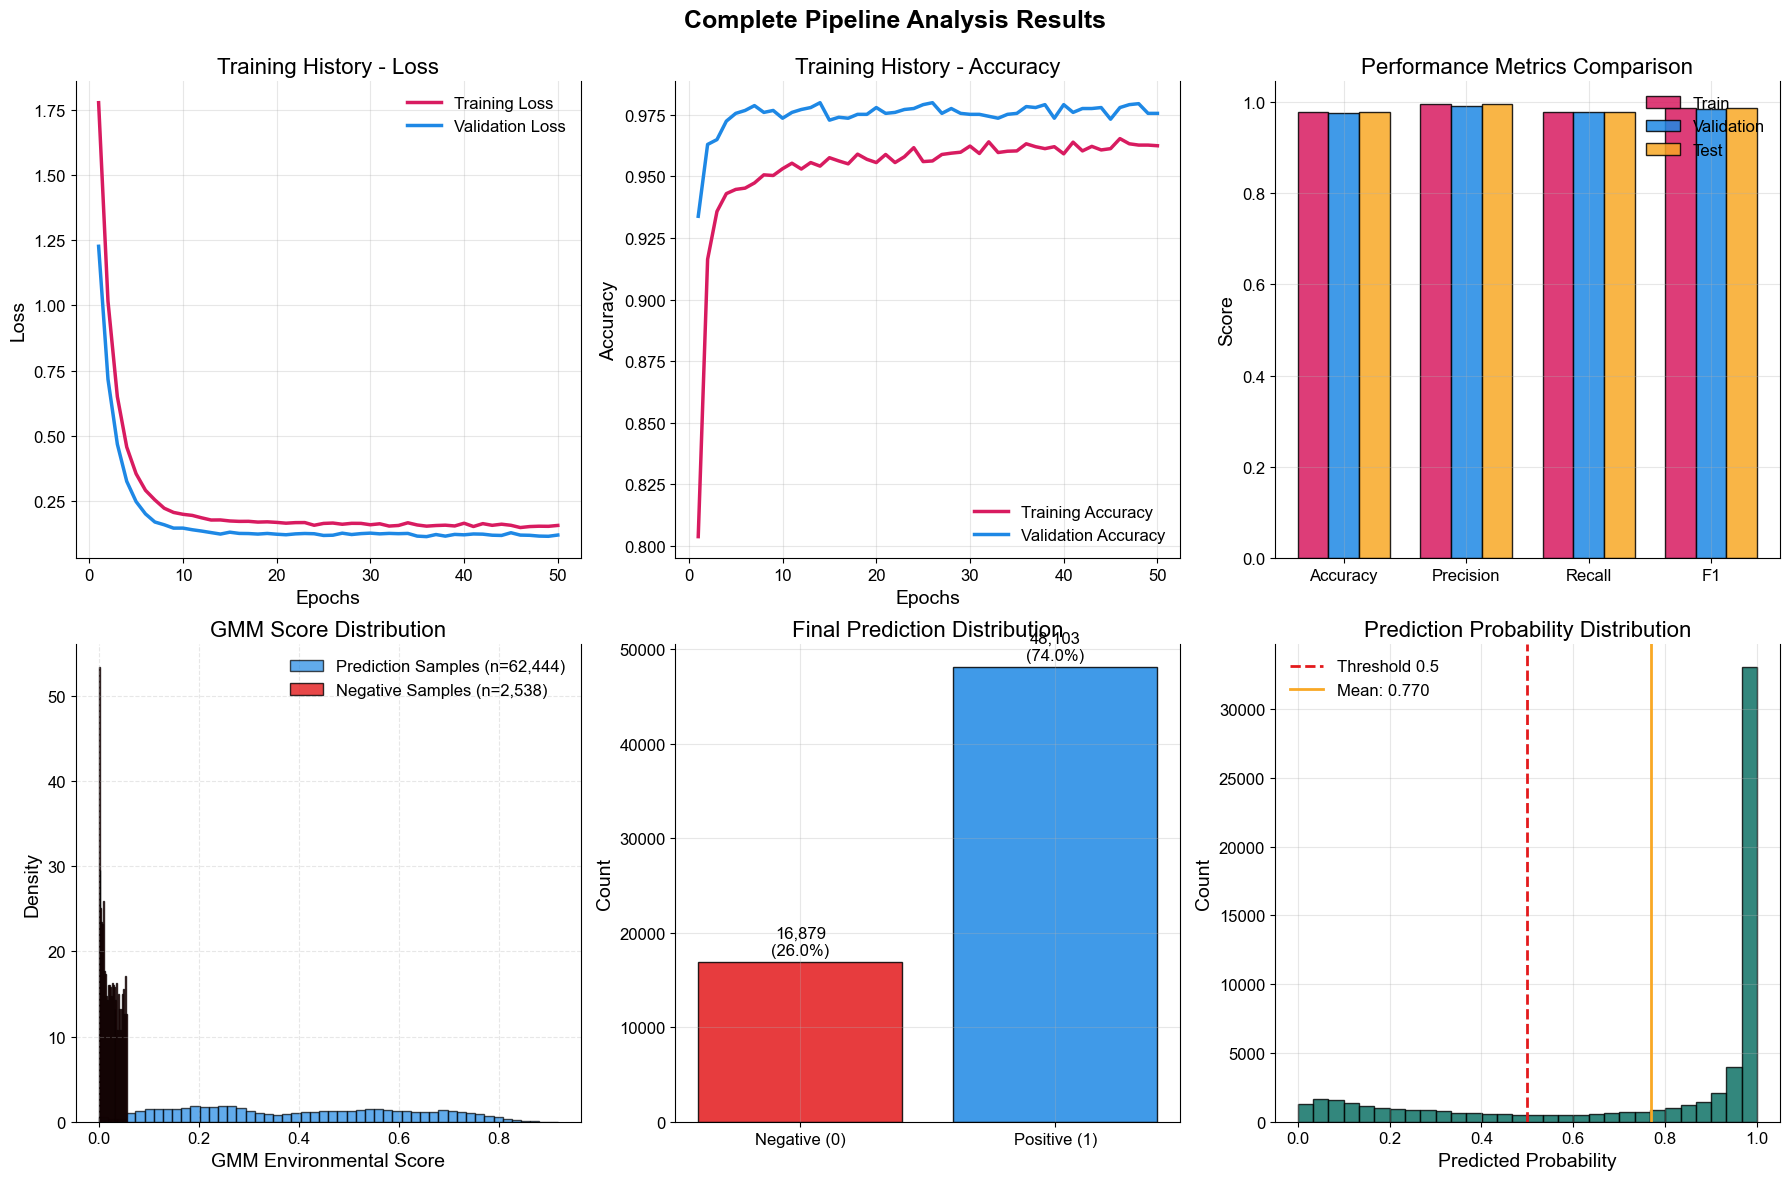


学习曲线分析总结:
✅ 模型拟合程度良好
✅ 模型方差适中
最终性能: 0.9860

✅ 分层负样本采样的训练管道执行完成！
📊 增强PU评估 - 考虑采样偏差和错分类代价:
   - 训练时负样本比例: 0.2 (正样本比例: 80.0%)
   - 测试集正样本: 2030
   - 测试集负样本: 508
   - 未标注样本: 62444
   - 错分类代价比 (FP:FN): 1.0:4.0
✅ 基于满足约束的PU-F1选择最佳阈值


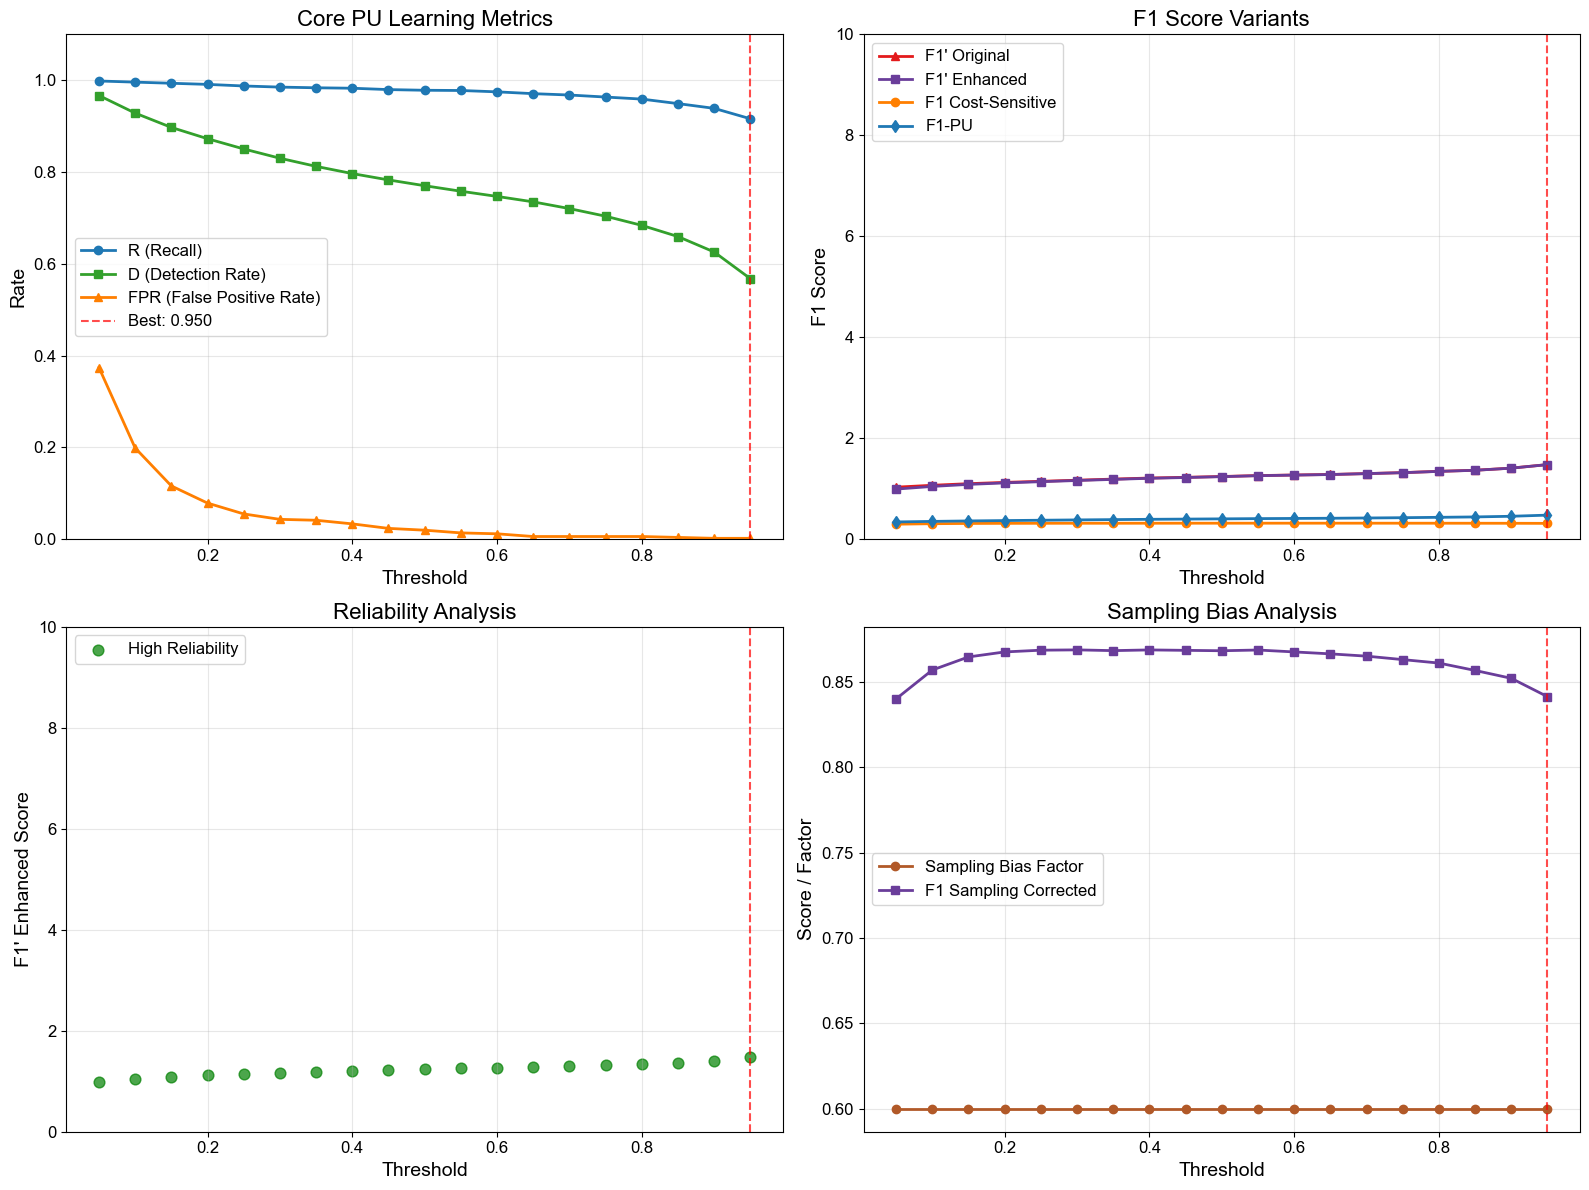


增强PU Learning评估摘要
最佳阈值: 0.950
召回率 (R): 0.916
检测率 (D): 0.568
误报率 (FPR): 0.002
F1' 原版: 1.478
F1' 增强版: 1.478
F1 代价敏感: 0.314
F1-PU: 0.477

配置信息:
负样本比例: 0.2
训练正样本比例: 80.0%
采样偏差因子: 0.600
错分类代价比 (FP:FN): 1.0:4.0

可靠性: High
建议: ✅ 推荐阈值 0.950 (覆盖率 56.8%，召回率 91.6%) | ✅ 误报率较低 (0.2%) | ⚠️ 训练样本比例偏差较大 (正样本80.0%)

🎯 最终推荐:
   最佳阈值: 0.950
   预期覆盖率: 56.8%
   预期误报率: 0.2%
   采样偏差程度: 0.600
✅ 完整模型保存成功:
  - 主文件: data/US_data\landuse_model_20251017_010357.pkl
  - GMM模型: data/US_data\landuse_model_20251017_010357_gmm.pkl
  - 深度学习模型: data/US_data\landuse_model_20251017_010357_dl.h5
  - 预处理器: data/US_data\landuse_model_20251017_010357_preprocessor.pkl
  - 测试数据: data/US_data\landuse_model_20251017_010357_test_data.npz
  - 配置文件: data/US_data\landuse_model_20251017_010357_config.json

✅ 结果已保存:

最终统计:
  - 总样本数: 64,982
  - 负样本数: 2,538
  - 预测样本数: 62,444
  - 预测为正类: 48,103
  - 正类比例: 74.025%


In [30]:
from function import *  
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import os
import json
from datetime import datetime


def clip_data_with_us_states(df, us_states_gdf, lon_col='lon', lat_col='lat'):
    """
    使用美国州界 shapefile 剪裁点数据；兼容不同版本的 geopandas 参数名
    """
    geometry = [Point(xy) for xy in zip(df[lon_col], df[lat_col])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')
    us_states_4326 = us_states_gdf.to_crs('EPSG:4326')

    try:
        clipped = gpd.sjoin(gdf, us_states_4326, how='inner', predicate='within')
    except TypeError:
        # 旧版本 geopandas 使用 op 参数
        clipped = gpd.sjoin(gdf, us_states_4326, how='inner', op='within')

    # 清理 shapefile 附加字段
    clipped = clipped.drop(columns=['geometry', 'index_right'], errors='ignore')
    for col in us_states_gdf.columns:
        if col in clipped.columns:
            clipped = clipped.drop(columns=[col], errors='ignore')
    return clipped


if __name__ == '__main__':

    # ---------------------------
    # 0) 基础地理范围与底图
    # ---------------------------
    usa_bounds_main = dict(lon_min=-125, lon_max=-65, lat_min=25, lat_max=49)
    us_states = gpd.read_file(r'data\cb_2018_us_state_500k.shp')

    # ---------------------------
    # 1) 读取数据
    # ---------------------------
    df_abandon = load_abandon(PATHS['us_abandon'])
    df_embedding = load_embedding(PATHS['us_pv_embedding'])

    # 初步经纬度范围过滤
    df_embedding = df_embedding[
        (df_embedding['lon'] >= usa_bounds_main['lon_min']) &
        (df_embedding['lon'] <= usa_bounds_main['lon_max']) &
        (df_embedding['lat'] >= usa_bounds_main['lat_min']) &
        (df_embedding['lat'] <= usa_bounds_main['lat_max'])
    ]

    # 第二次用州界矢量更精确裁剪
    df_abandon = clip_data_with_us_states(df_abandon, us_states)
    df_embedding = clip_data_with_us_states(df_embedding, us_states)

    # ---------------------------
    # 2) 缺失值填充 + 去重
    # ---------------------------
    df_abandon_fill   = fill_nonpositive_with_nearest(df_abandon)
    df_embedding_fill = fill_nonpositive_with_nearest(df_embedding)

    df_abandon_filtered = filter_duplicates(df_abandon_fill, df_embedding_fill)

    # ---------------------------
    # 3) 特征选择（排除经纬度）
    # ---------------------------
    features_no_coords = [f for f in (NUMERIC_FEATURES + CAT_COLS) if f not in ['lat', 'lon']]
    # 只保留在 df_embedding_fill 列中实际存在的特征（防止有些特征名在数据中不存）
    features_no_coords = [c for c in features_no_coords if c in df_embedding_fill.columns]

    
    complete_results = run_correct_training_pipeline(
            df_positive=df_embedding_fill,          # 正样本
            df_prediction_pool=df_abandon_filtered,  # 预测样本池
            features_no_coords=features_no_coords,
            negative_ratio=0.25,
            sampling_strategy="simple",
            difficulty_levels=3,
            test_size=0.2,
            val_size=0.2,
            epochs=50,
            batch_size=32,
            random_state=42,
            hidden_layers=[128, 64, 32],
            dropout_rate=0.3,
            learning_rate=0.001,
            run_shap=True
    )
    
    if complete_results is not None:

        evaluation_results = enhanced_model_evaluation_with_pu(
            complete_results, 
            pi_estimate=0.2,              
            traditional_metrics=True,       
            pu_metrics=True,              
            cost_fp=1.0,                   
            cost_fn=4.0                    
        )

        # 输出关键信息
        pu_summary = evaluation_results["pu_learning"]["summary"]
        print(f"\n🎯 最终推荐:")
        print(f"   最佳阈值: {pu_summary['best_threshold']:.3f}")
        print(f"   预期覆盖率: {pu_summary['best_detection_rate']:.1%}")
        print(f"   预期误报率: {pu_summary['best_fpr']:.1%}")
        print(f"   采样偏差程度: {pu_summary.get('sampling_bias_factor', 0):.3f}")

        # 保存结果
        save_dir = "data/US_data"
        os.makedirs(save_dir, exist_ok=True)
        
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        
        # 保存最终预测结果

        saved_model_path = save_complete_model_pipeline(
        gmm_pipeline=complete_results['gmm_pipeline'],
        dl_model=complete_results['training_results']['model'],
        features=features_no_coords,
        config=complete_results['config'],
        retrained_preprocessor=complete_results['training_results']['preprocessor'],
        training_results=complete_results['training_results'],  
        save_dir="data/US_data",
        model_name=f"landuse_model_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
        )

        final_results = complete_results['final_results']
        output_file = os.path.join(save_dir, f"correct_pipeline_results_{timestamp}.csv")
        final_results.to_csv(output_file, index=False)
        

        
        print(f"\n✅ 结果已保存:")
        print(f"\n最终统计:")
        print(f"  - 总样本数: {len(final_results):,}")
        print(f"  - 负样本数: {len(complete_results['negative_samples']):,}")
        print(f"  - 预测样本数: {len(complete_results['prediction_results']):,}")
        print(f"  - 预测为正类: {final_results['predicted_label'].sum():,}")
        print(f"  - 正类比例: {final_results['predicted_label'].mean():.3%}")
    
    else:
        print("❌ 训练管道执行失败")

In [26]:
# # 将env_scores匹配到原始样本的经纬度上并保存
# df_abandon_filtered['env_scores'] = env_scores
# # Try saving with different encoding
# df_abandon_filtered.to_csv('./data/abandon_filtered_with_scores.csv', index=False)# 绘制地图
# plt.figure(figsize=(10,6))

# # 绘制待预测点
# plt.scatter(df_abandon_filtered['lon'], df_abandon_filtered['lat'], 
#            c=df_abandon_filtered['env_scores'], cmap='viridis',
#            alpha=0.5, label='Prediction Points')

# # 叠加训练样本点
# plt.scatter(df_embedding_fill['lon'], df_embedding_fill['lat'],
#            color='red', alpha=0.5, s=20, label='Training Points')

# plt.colorbar(label='Environmental Scores')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.title('Spatial Distribution of Environmental Scores')
# plt.legend()
# plt.show()

In [27]:
df_abandon

,Unnamed: 0,time,lat,lon,abandonment_year,abandonment_duration,current_abandonment,landcover,DEM,GDPpc,...,Population,Powerdist,PrimaryRoad,SecondaryRoad,Slope,TertiaryRoad,gdmp,rsds,tas,wind
805,1897288,2020-01-01,31.320833,-105.929170,2014.0,10.0,1,2.0,1074.1250,19547.0,...,1.104119,622567.20,22.570979,0.000000,0.161280,109.755022,60.677334,21.335989,2934.915273,2.750262
807,1899788,2020-01-01,31.329166,-105.929170,2014.0,10.0,1,3.0,1074.8125,19547.0,...,1.104119,622567.20,22.570979,0.000000,0.142680,109.755022,45.031578,21.334290,2934.829175,2.751782
808,1902287,2020-01-01,31.337500,-105.937500,2014.0,10.0,1,3.0,1075.3750,32645.0,...,0.399327,622567.20,22.570979,0.000000,0.151240,109.755022,38.084999,21.337654,2934.583333,2.752204
809,1902288,2020-01-01,31.337500,-105.929170,2014.0,10.0,1,2.0,1074.9375,32645.0,...,3.593287,622567.20,22.570979,0.000000,0.134330,109.755022,26.303532,21.336290,2934.584702,2.758872
810,1904787,2020-01-01,31.345833,-105.937500,2014.0,10.0,1,2.0,1075.9375,32645.0,...,5.603361,622567.20,22.570979,0.000000,0.182301,109.755022,39.406666,21.343910,2934.581940,2.771071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70592,20192249,2020-01-01,46.937500,-67.920830,1998.0,26.0,1,2.0,199.3750,33949.0,...,218.050890,622564.50,4.273278,14.490743,1.000655,129.836817,74.197998,12.735363,2768.901404,3.429452
70601,20247244,2020-01-01,47.145832,-67.962500,2000.0,24.0,1,2.0,223.0000,33949.0,...,9.665760,622564.30,32.119901,0.000000,3.852393,92.798418,73.082001,12.262959,2766.375025,3.813229
70607,20271365,2020-01-01,47.237500,-68.620834,2000.0,24.0,1,2.0,181.2500,33949.0,...,141.555110,622564.00,3.471587,33.915221,1.910013,80.651057,54.858932,12.550031,2768.493367,3.047965
70608,20275797,2020-01-01,47.254166,-68.354164,2000.0,24.0,1,2.0,244.9375,33949.0,...,17.156588,622564.06,8.030265,0.061349,1.939035,91.262543,74.170227,12.486876,2765.084545,4.128394


# 1、Map for workflow

You want to predict the year: 2020.0
列 GDPpc 没有需要填充的非正值或NaN值
列 GURdist 没有需要填充的非正值或NaN值
列 GDPpc 没有需要填充的非正值或NaN值
列 GURdist 没有需要填充的非正值或NaN值

[载入模型] gmm_model_34c_fixed.pkl ...
✅ GMM pipeline loaded.
Running similarity diagnostics (log-density/PIT/PCA/MD²)...


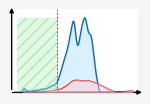


✅ 相似性分布图已保存到: figure\US_figure\similarity.png

Log-Density 相似性分析
📊 数据概览:
  参考正样本: 10,152 个
  查询样本: 64,982 个

🎯 参考集关键分位数:
  5%分位数: 38.634
  25%分位数: 47.225
  60%分位数: 55.123

负采样建议:
  5%分位数以下: 61,043 个 (93.9%)
  25%分位数以下: 42,345 个 (65.2%)
  60%分位数以下: 13,365 个 (20.6%)


In [49]:

import joblib
from function import *  
from function.global_varibles import PATHS
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import os
from datetime import datetime
from sklearn.pipeline import Pipeline
from sklearn.mixture import GaussianMixture
from scipy import stats

def visualize_similarity(gmm_pipeline: Pipeline,
                         df_ref_pos: pd.DataFrame,
                         df_query: pd.DataFrame,
                         q_cut: float = 0.05,
                         random_state: int = 42,
                         save_path: str = r'figure\US_figure\similarity.png'):
    """
    极简相似性诊断函数 - 仅显示log-density重叠直方图和3个分位数（5%, 25%, 60%）
    增加拟合曲线及与X轴围成的阴影，ref为绿色，query为#E28D8D，直方图无框线。
    分位数线带箭头水平线从Y轴指向分位数线，标签居中于两分位数线之间。
    支持图片保存到 save_path。
    """
    # ref淡绿色
    ref_color = '#FFCDD2'  # 淡红色
    ref_kde_color = '#C62828'  # 深红
    # query淡蓝色
    query_color = '#B3E5FC'  # 淡蓝色
    query_kde_color = '#1565C0'  # 深蓝

    pre = gmm_pipeline.named_steps['preprocessor']
    gmm: GaussianMixture = gmm_pipeline.named_steps['gmm']

    Xr = pre.transform(df_ref_pos)
    Xq = pre.transform(df_query)
    logp_ref = gmm.score_samples(Xr)
    logp_q = gmm.score_samples(Xq)

    quantiles = [0.05, 0.25, 0.60]
    quantile_vals = [float(np.quantile(logp_ref, q)) for q in quantiles]
    mu, std = float(np.mean(logp_ref)), float(np.std(logp_ref) + 1e-12)
    z_q = (logp_q - mu) / std

    fig, ax = plt.subplots(1, 1, figsize=(50/25.4, 35/25.4))
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['font.size'] = 6
    plt.rcParams['axes.labelcolor'] = 'black'
    plt.rcParams['xtick.labelcolor'] = 'black'
    plt.rcParams['ytick.labelcolor'] = 'black'

    ref_clip, bins_ref, _ = _hist_bins_clip(logp_ref)
    q_clip,   bins_q,   _ = _hist_bins_clip(logp_q)
    bins = max(bins_ref, bins_q)

    # 不显示样本数量
    n_ref, bins_ref_edges, _ = ax.hist(ref_clip, bins=bins, alpha=0.0, label=None, 
            color=ref_color, edgecolor='none', linewidth=0.0)
    n_q, bins_q_edges, _ = ax.hist(q_clip, bins=bins, alpha=0.0, label=None, 
            color=query_color, edgecolor='none', linewidth=0.0)

    x_min = min(np.min(ref_clip), np.min(q_clip))
    x_max = max(np.max(ref_clip), np.max(q_clip))
    x = np.linspace(x_min, x_max, 500)

    # ref绿色放在更上一层，先画query再画ref
    kde_q = stats.gaussian_kde(q_clip)
    y_q = kde_q(x)
    ax.plot(x, y_q * len(q_clip) * (bins_q_edges[1] - bins_q_edges[0]), color=query_kde_color, lw=1, label='Predicting sets')
    ax.fill_between(x, 0, y_q * len(q_clip) * (bins_q_edges[1] - bins_q_edges[0]), color=query_color, alpha=0.5)

    kde_ref = stats.gaussian_kde(ref_clip)
    y_ref = kde_ref(x)
    ax.plot(x, y_ref * len(ref_clip) * (bins_ref_edges[1] - bins_ref_edges[0]), color=ref_kde_color, lw=1, label='Training sets')
    ax.fill_between(x, 0, y_ref * len(ref_clip) * (bins_ref_edges[1] - bins_ref_edges[0]), color=ref_color, alpha=0.5, zorder=10)

    color = '#444444'
    labels = ['5%', '25%', '60%']
    y_max = ax.get_ylim()[1]
    y_arrow = y_max * 0.95

    # 只绘制第一个
    ax.axvline(quantile_vals[0], color=color, linestyle="--", linewidth=0.5, label=f"{labels[0]} quantile")

    # 修改：在0-5%之间添加阴影区域，并让fill_between和箭头的起始点一致
    prev_x = ax.get_xlim()[0]
    x_min_shadow = prev_x  
    x_max_shadow = quantile_vals[0]  
    y_max_shadow = ax.get_ylim()[1]
    
    # Use a light green color for the interval and add shading
    # 先绘制阴影区域
    # 使用斜线阴影 (hatch) 填充0-5%区间
    ax.fill_between([x_min_shadow, x_max_shadow], 0, y_max_shadow*0.9, 
                    color='#b2f2bb', alpha=0.4, zorder=5, hatch='///', edgecolor='#7bc47f', linewidth=0.0)

    # # 再绘制箭头，zorder设为更高，确保箭头在fill_between上方
    # ax.annotate(
    #     '', 
    #     xy=(quantile_vals[0], y_arrow), 
    #     xytext=(x_min_shadow, y_arrow), 
    #     arrowprops=dict(arrowstyle="->", color=color, lw=0.5, zorder=10),
    #     annotation_clip=False
    # )
    # 将整个画布背景设置为灰色
    fig = ax.get_figure()
    fig.patch.set_facecolor('#f5f5f5')
    # ax.set_facecolor('#f5f5f5')
    # 将画布和坐标轴铺满整个页面
    ax.set_position([0, 0, 1, 1])

    x0 = ax.get_xlim()[0]
    xpos = (x0 + quantile_vals[0]) / 2
    # ax.text(
    #     xpos*1.02, y_arrow*1.05, 
    #     f"{labels[0]} quantile", 
    #     color='black', fontsize=5, ha='center', va='bottom', fontweight='bold', zorder=6
    # )
    # ax.text(
    #     xpos*1.02, y_arrow*0.92, 
    #     f"{'low similarity'}", 
    #     color='black', fontsize=5, ha='center', va='bottom', fontweight='bold'
    # )

    ax.grid(False) 
    ax.tick_params(axis='both', which='major', width=0.5, length=2, labelsize=6, color='black')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # 修改：取消y轴显示
    ax.spines['left'].set_visible(False)
    ax.set_yticks([])  
    ax.set_xticks([])
    # ax.tick_params(axis='y', which='both', left=False, labelleft=False)  

    ax.annotate('', xy=(1.05, 0), xycoords='axes fraction', xytext=(0, 0),
            arrowprops=dict(arrowstyle='-|>', color='black', lw=1, fill=True))
    ax.annotate('', xy=(0, 1.05), xycoords='axes fraction', xytext=(0, 0),
                arrowprops=dict(arrowstyle='-|>', color='black', lw=1, fill=True))
    plt.tight_layout()



    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"\n✅ 相似性分布图已保存到: {save_path}")

    print("\n" + "="*60)
    print("Log-Density 相似性分析")
    print("="*60)
    print(f"📊 数据概览:")
    print(f"  参考正样本: {len(logp_ref):,} 个")
    print(f"  查询样本: {len(logp_q):,} 个")
    print(f"\n🎯 参考集关键分位数:")
    print(f"  5%分位数: {quantile_vals[0]:.3f}")
    print(f"  25%分位数: {quantile_vals[1]:.3f}")
    print(f"  60%分位数: {quantile_vals[2]:.3f}")

    below_5pct = np.sum(logp_q >= quantile_vals[0])
    below_25pct = np.sum(logp_q >= quantile_vals[1])
    below_60pct = np.sum(logp_q >= quantile_vals[2])
    print(f"\n负采样建议:")
    print(f"  5%分位数以下: {below_5pct:,} 个 ({100*below_5pct/len(logp_q):.1f}%)")
    print(f"  25%分位数以下: {below_25pct:,} 个 ({100*below_25pct/len(logp_q):.1f}%)")
    print(f"  60%分位数以下: {below_60pct:,} 个 ({100*below_60pct/len(logp_q):.1f}%)")
    print("="*60)

    return {
        "logp_ref_mean": mu, 
        "logp_ref_std": std,
        "logp_thresholds": dict(zip(labels, quantile_vals)),
        "z_query": z_q,
        "below_5pct_count": below_5pct,
        "below_25pct_count": below_25pct,
        "below_60pct_count": below_60pct
    }

def clip_data_with_us_states(df, us_states_gdf, lon_col='lon', lat_col='lat'):
    geometry = [Point(xy) for xy in zip(df[lon_col], df[lat_col])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')
    us_states_4326 = us_states_gdf.to_crs('EPSG:4326')
    try:
        clipped = gpd.sjoin(gdf, us_states_4326, how='inner', predicate='within')
    except TypeError:
        clipped = gpd.sjoin(gdf, us_states_4326, how='inner', op='within')
    clipped = clipped.drop(columns=['geometry', 'index_right'], errors='ignore')
    for col in us_states_gdf.columns:
        if col in clipped.columns:
            clipped = clipped.drop(columns=[col], errors='ignore')
    return clipped

np.random.seed(42)

usa_bounds_main = dict(lon_min=-125, lon_max=-65, lat_min=25, lat_max=49)
us_states = gpd.read_file(r'data\cb_2018_us_state_500k.shp')

df_abandon = load_abandon(PATHS['us_abandon'])
df_embedding = load_embedding(PATHS['us_pv_embedding'])

df_embedding = df_embedding[
    (df_embedding['lon'] >= usa_bounds_main['lon_min']) &
    (df_embedding['lon'] <= usa_bounds_main['lon_max']) &
    (df_embedding['lat'] >= usa_bounds_main['lat_min']) &
    (df_embedding['lat'] <= usa_bounds_main['lat_max'])
]

df_abandon = clip_data_with_us_states(df_abandon, us_states)
df_embedding = clip_data_with_us_states(df_embedding, us_states)

df_abandon_fill   = fill_nonpositive_with_nearest(df_abandon)
df_embedding_fill = fill_nonpositive_with_nearest(df_embedding)
df_abandon_filtered = filter_duplicates(df_abandon_fill, df_embedding_fill)

features_no_coords = [f for f in (NUMERIC_FEATURES + CAT_COLS) if f not in ['lat', 'lon']]
features_no_coords = [c for c in features_no_coords if c in df_embedding_fill.columns]
print("\n[载入模型] gmm_model_34c_fixed.pkl ...")
try:
    gmm_pipeline = joblib.load("gmm_model_34c_fixed.pkl")
    print("✅ GMM pipeline loaded.")
except Exception as e:
    print(f"❌ 加载模型失败: {e}")
    raise

print("Running similarity diagnostics (log-density/PIT/PCA/MD²)...")
try:
    diag_out = visualize_similarity(
        gmm_pipeline,
        df_ref_pos=df_embedding_fill[features_no_coords],
        df_query=df_abandon_filtered[features_no_coords],
        q_cut=0.05,
        random_state=42,
        save_path=r'figure\US_figure\similarity.png'
    )
except NameError as e:
    print("⚠️ 找不到 visualize_similarity，请确认该函数已在 function.py 或本文件中定义。")
    print(f"   详细信息: {e}")
except Exception as e:
    print(f"⚠️ 相似性诊断绘图失败: {e}")

# 2、Plot for Component-feature

请你检查select_and_train_gmm函数中的保存参数。我现在需要生成两幅图。

第一是Component–Feature 层，核心目的是用每个 component 的参数刻画特征组合（从PV训练中获取：给人呈现出光伏到底有怎么样的环境结构、有多少类型、哪个环境结构主导了PV部署）

数据输入：训练好的pkl模型（保存的具体参数请参考select_and_train_gmm保存内容）
（1）第 k 个成分的均值向量；
（2）协方差矩阵
（3）混合权重
（4）特征名称


图形输出：（由于我有15个特征、34个高斯组分，因此需要考虑哪个特征组合是真正的主导、占比更高）；各成分在 15 个特征上的标准化均值

(注意由于我对land-cover进行了one-hot编码，需要你对这个特征进行合成)




## 2.1 PV environmental combination

In [ ]:
import joblib
import numpy as np
import pandas as pd
import os
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import Pipeline
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist

def assign_gmm_components_and_hierarchical_clusters(
    model_path: str = "gmm_model_34c_fixed.pkl",
    df_embedding_fill: pd.DataFrame = None,
    features_no_coords: list = None,
    distance_threshold: float = 1.5,
    save_path: str = "data/US_data/df_pv_gmm.csv"
):
    """
    为df_embedding_fill分配GMM组件编号和层次聚类类别，保留计算去掉绘图。
    """
    # ========== 1. 加载模型和提取参数 ==========
    print(f"Loading model: {model_path}")
    gmm_pipeline = joblib.load(model_path)
    
    gmm: GaussianMixture = gmm_pipeline.named_steps['gmm']
    preprocessor = gmm_pipeline.named_steps['preprocessor']
    
    n_components = gmm.n_components
    means = gmm.means_
    weights = gmm.weights_
    covariances = gmm.covariances_
    
    print(f"\n=== GMM Parameter Information ===")
    print(f"Number of components: {n_components}")
    print(f"Sum of weights: {weights.sum():.6f}")
    print(f"Weight range: [{weights.min():.4f}, {weights.max():.4f}]")
    
    # ========== 2. 处理特征名称和landcover拆解 ==========
    numeric_features = preprocessor.numeric_features
    categorical_features = preprocessor.categorical_features
    n_numeric = len(numeric_features)
    
    # Landcover分类定义（基于ESA CCI重分类）
    landcover_to_pattern = {
        1: ['Socioeconomic'],
        2: ['Geographic'],
        3: ['Geographic'],
        4: ['Geographic'],
        5: ['Geographic'],
        6: ['Climatic'],
        7: ['Socioeconomic', 'Infrastructure'],
        8: ['Geographic'],
        9: ['Climatic'],
    }
    
    if categorical_features:
        landcover_means = means[:, n_numeric:]
        n_landcover_cats = landcover_means.shape[1]
        
        dominant_landcover_idx = np.argmax(landcover_means, axis=1)
        landcover_dominant_values = np.take_along_axis(
            landcover_means, 
            dominant_landcover_idx[:, np.newaxis], 
            axis=1
        ).squeeze()
        
        component_features_std = np.column_stack([
            means[:, :n_numeric],
            landcover_dominant_values[:, np.newaxis]
        ])
    else:
        component_features_std = means
        landcover_means = None
    
    all_features = numeric_features + categorical_features
    
    # ========== 3. 层次聚类分析 ==========
    print(f"\n=== Hierarchical Clustering Analysis ===")
    distance_matrix = pdist(component_features_std, metric='correlation')
    linkage_matrix = linkage(distance_matrix, method='ward')
    
    # 使用距离阈值进行聚类
    cluster_labels = fcluster(linkage_matrix, distance_threshold, criterion='distance')
    n_clusters = len(np.unique(cluster_labels))
    
    print(f"Distance threshold: {distance_threshold}")
    print(f"Number of clusters: {n_clusters}")
    
    # 统计每个聚类的组件分布
    cluster_component_map = {}
    for i in range(1, n_clusters + 1):
        components_in_cluster = np.where(cluster_labels == i)[0]
        cluster_component_map[i] = components_in_cluster.tolist()
        print(f"Cluster {i}: Components {components_in_cluster}")
    
    # ========== 4. 为df_embedding_fill分配GMM组件 ==========
    print(f"\n=== Assigning GMM Components to df_embedding_fill ===")
    
    # 预处理数据
    X_processed = preprocessor.transform(df_embedding_fill[features_no_coords])
    
    # 预测GMM组件
    gmm_components = gmm.predict(X_processed)
    
    # 计算概率分布
    gmm_probabilities = gmm.predict_proba(X_processed)
    max_probabilities = np.max(gmm_probabilities, axis=1)
    
    print(f"Data points assigned to GMM components:")
    print(f"Total data points: {len(df_embedding_fill)}")
    print(f"Component assignment range: [{gmm_components.min()}, {gmm_components.max()}]")
    
    # 统计每个组件的分配情况
    component_counts = pd.Series(gmm_components).value_counts().sort_index()
    print(f"\nComponent distribution:")
    for comp_id, count in component_counts.items():
        pct = count / len(gmm_components) * 100
        print(f"  Component {comp_id}: {count} points ({pct:.2f}%)")
    
    # ========== 5. 分配层次聚类类别 ==========
    print(f"\n=== Assigning Hierarchical Cluster Labels ===")
    
    # 将GMM组件映射到层次聚类类别
    hierarchical_clusters = np.zeros_like(gmm_components)
    for cluster_id, component_list in cluster_component_map.items():
        mask = np.isin(gmm_components, component_list)
        hierarchical_clusters[mask] = cluster_id
    
    # 统计层次聚类分布
    cluster_counts = pd.Series(hierarchical_clusters).value_counts().sort_index()
    print(f"\nHierarchical cluster distribution:")
    for cluster_id, count in cluster_counts.items():
        pct = count / len(hierarchical_clusters) * 100
        print(f"  Cluster {int(cluster_id)}: {count} points ({pct:.2f}%)")
    
    # ========== 6. 分析每个层次聚类的特征模式 ==========
    print(f"\n=== Cluster Feature Pattern Analysis ===")
    
    for cluster_id in range(1, n_clusters + 1):
        cluster_mask = hierarchical_clusters == cluster_id
        cluster_components = cluster_component_map[cluster_id]
        
        print(f"\nCluster {cluster_id} (Components: {cluster_components}):")
        print(f"  Data points: {cluster_mask.sum()}")
        
        # 分析该聚类的特征模式
        cluster_features = component_features_std[cluster_components, :]
        
        # 计算每个特征的平均z-score
        mean_z_scores = np.mean(cluster_features, axis=0)
        
        # 找出显著高于/低于平均的特征
        high_features = []
        low_features = []
        
        for i, feature in enumerate(all_features):
            z_score = mean_z_scores[i]
            if z_score > 0.5:  # 显著高于平均
                high_features.append((feature, z_score))
            elif z_score < -0.5:  # 显著低于平均
                low_features.append((feature, z_score))
        
        if high_features:
            print(f"  High features (z > 0.5):")
            for feature, z in sorted(high_features, key=lambda x: x[1], reverse=True):
                print(f"    {feature}: {z:.3f}")
        
        if low_features:
            print(f"  Low features (z < -0.5):")
            for feature, z in sorted(low_features, key=lambda x: x[1]):
                print(f"    {feature}: {z:.3f}")
    
    # ========== 7. 创建结果DataFrame ==========
    print(f"\n=== Creating Result DataFrame ===")
    
    # 确保df_embedding_fill包含lat和lon列
    if 'lat' not in df_embedding_fill.columns or 'lon' not in df_embedding_fill.columns:
        raise ValueError("df_embedding_fill must contain 'lat' and 'lon' columns")
    
    # 重置索引以确保索引连续
    df_embedding_fill_reset = df_embedding_fill.reset_index(drop=True)
    
    # 创建结果DataFrame
    df_result = df_embedding_fill_reset.copy()
    
    # 添加GMM相关信息
    df_result['gmm_component'] = gmm_components
    df_result['gmm_max_probability'] = max_probabilities
    df_result['hierarchical_cluster'] = hierarchical_clusters
    
    # 添加层次聚类的描述性信息
    cluster_descriptions = {}
    for cluster_id in range(1, n_clusters + 1):
        cluster_components = cluster_component_map[cluster_id]
        component_str = ','.join(map(str, cluster_components))
        cluster_descriptions[cluster_id] = f"Cluster_{cluster_id}_Components_{component_str}"
    
    df_result['cluster_description'] = df_result['hierarchical_cluster'].map(cluster_descriptions)
    
    print(f"Result DataFrame shape: {df_result.shape}")
    print(f"Columns added: gmm_component, gmm_max_probability, hierarchical_cluster, cluster_description")
    
    # ========== 8. 保存结果 ==========
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    df_result.to_csv(save_path, index=False)
    
    print(f"\n✅ Results saved to: {save_path}")
    
    # 去除所有可视化和绘图部分
    
    return df_result

# 使用示例
if __name__ == "__main__":
    # 假设df_embedding_fill和features_no_coords已经定义
    # 这些变量应该从之前的代码中获取
    
    # 示例用法（需要根据实际情况调整）
    df_result = assign_gmm_components_and_hierarchical_clusters(
        model_path="gmm_model_34c_fixed.pkl",
        df_embedding_fill=df_embedding_fill,  # 从之前代码获取
        features_no_coords=features_no_coords,  # 从之前代码获取
        distance_threshold=1.5,
        save_path="data/US_data/df_pv_gmm.csv"
    )
    
    print(f"\n✅ 完成！结果已保存到 data/US_data/df_pv_gmm.csv")
    print(f"DataFrame包含列: {list(df_result.columns)}")

Loading model: gmm_model_34c_fixed.pkl

=== GMM Parameter Information ===
Number of components: 34
Sum of weights: 1.000000
Weight range: [0.0004, 0.0803]

=== Hierarchical Clustering Analysis ===
Distance threshold: 1.5
Number of clusters: 4
Cluster 1: Components [ 2  4  8 10 18 21 22 23 27 33]
Cluster 2: Components [ 1  3  5  7 11 12 14 16 25 28 31 32]
Cluster 3: Components [ 9 13 17 19 24 26 29]
Cluster 4: Components [ 0  6 15 20 30]

=== Assigning GMM Components to df_embedding_fill ===
Data points assigned to GMM components:
Total data points: 10152
Component assignment range: [0, 33]

Component distribution:
  Component 0: 4 points (0.04%)
  Component 1: 219 points (2.16%)
  Component 2: 329 points (3.24%)
  Component 3: 203 points (2.00%)
  Component 4: 13 points (0.13%)
  Component 5: 511 points (5.03%)
  Component 6: 594 points (5.85%)
  Component 7: 30 points (0.30%)
  Component 8: 14 points (0.14%)
  Component 9: 214 points (2.11%)
  Component 10: 632 points (6.23%)
  Compon

Loading model: gmm_model_34c_fixed.pkl

=== GMM Parameter Information ===
Number of components: 34
Sum of weights: 1.000000 (should ≈1.0)
Weight range: [0.0004, 0.0803]

=== Pattern Type Distribution (Count-based) ===
Dominant: 10 components (29.4%)
Mixed-Dual: 7 components (20.6%)
Mixed-Triple: 12 components (35.3%)
Mixed-Quad: 5 components (14.7%)

=== Pattern Type Distribution (Weight-based) ===
Dominant: 0.1446 (14.5%) [10 components, avg_weight=0.0145]
Mixed-Dual: 0.2631 (26.3%) [7 components, avg_weight=0.0376]
  Sub-pattern breakdown:
    Infrastructure: 0.1597 (16.0%)
    Socioeconomic: 0.0785 (7.9%)
    Climatic: 0.0249 (2.5%)
Mixed-Triple: 0.4585 (45.9%) [12 components, avg_weight=0.0382]
  Sub-pattern breakdown:
    Infrastructure: 0.1523 (15.2%)
    Climatic: 0.1379 (13.8%)
    Geographic: 0.1340 (13.4%)
    Socioeconomic: 0.0344 (3.4%)
Mixed-Quad: 0.1338 (13.4%) [5 components, avg_weight=0.0268]
  Sub-pattern breakdown:
    Infrastructure: 0.0382 (3.8%)
    Climatic: 0.037

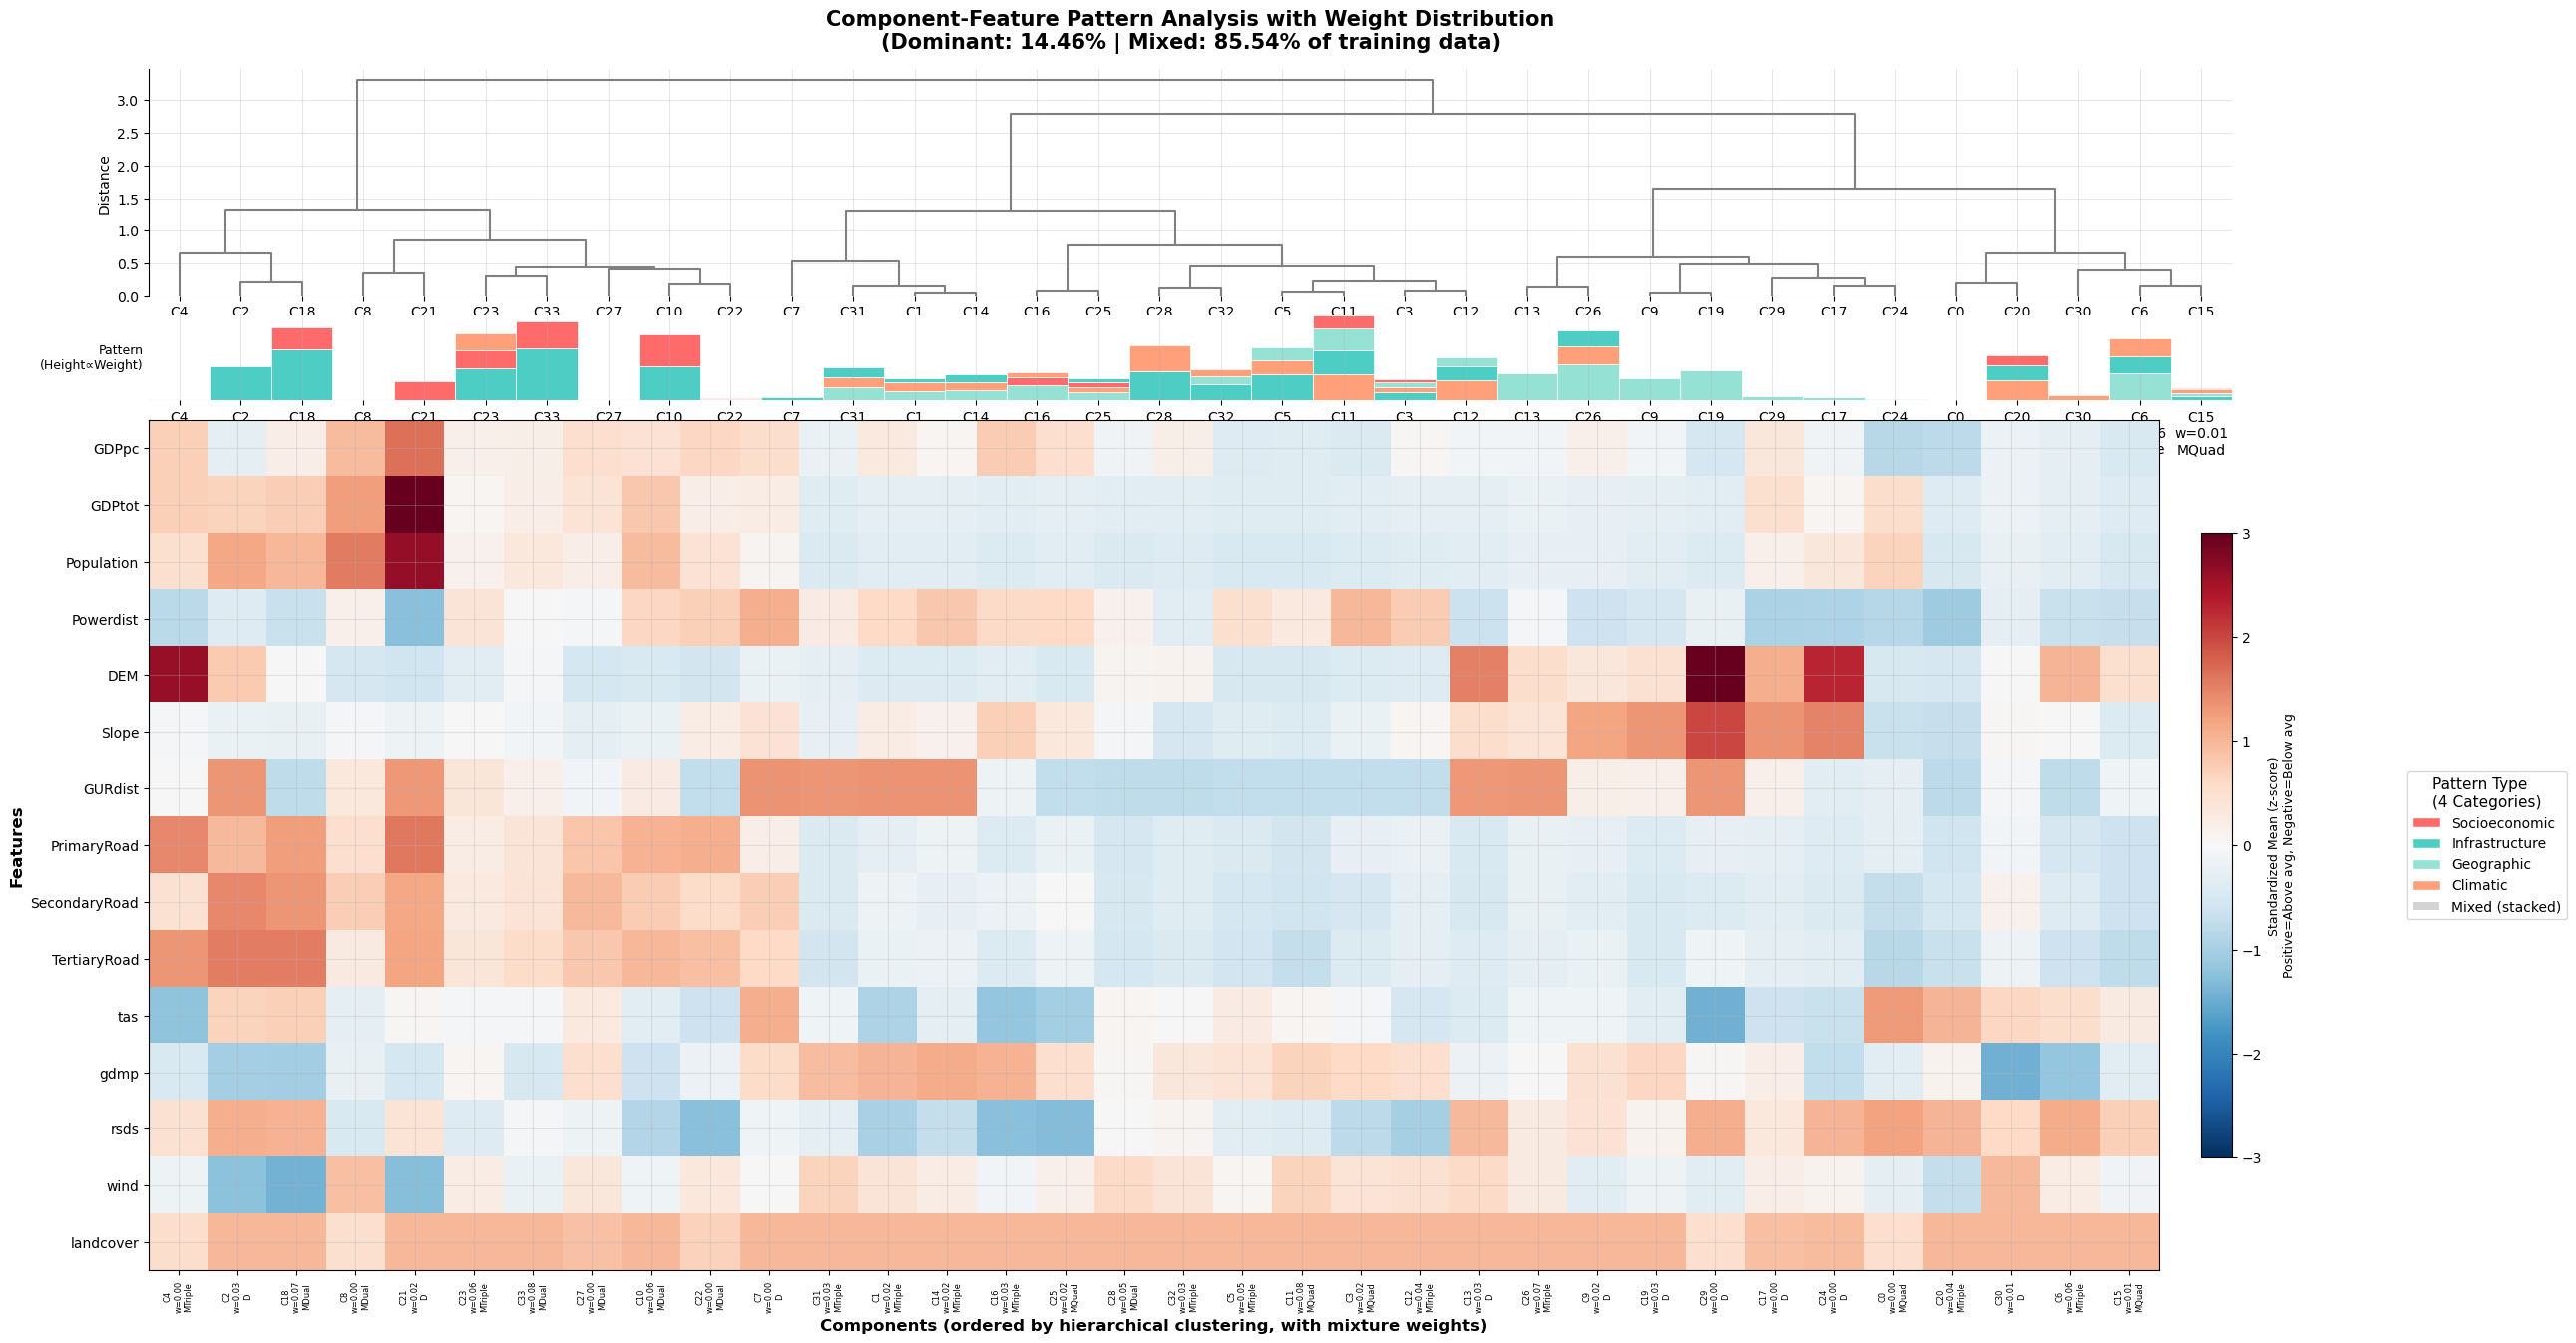

In [ ]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import Pipeline
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from matplotlib.patches import Rectangle, Patch
import matplotlib.gridspec as gridspec

'''
规则1: 主导型 (Dominant)
- 第一名 > 55%

规则2: 四重混合 (Mixed-Quad)  
- 四种模式都 > 12%
- 第一名 < 40%

规则3: 三重混合 (Mixed-Triple)
- 前三名都 > 15%
- 第一名 < 50%

规则4: 双重混合 (Mixed-Dual)
- 前两名都 > 20%
- 第一名 < 55%
'''

def classify_pattern_type(scores_dict):
    """
    分类component的模式类型（适用于4种模式）
    返回: (pattern_type, patterns_list, ratios_list)
    """
    sorted_scores = sorted(scores_dict.items(), key=lambda x: x[1], reverse=True)
    total = sum(scores_dict.values())
    
    if total < 1e-10:
        return 'Undefined', [None], [1.0]
    
    # 计算归一化得分
    norm_scores = [(name, score/total) for name, score in sorted_scores]
    
    # 获取前四名
    patterns = [norm_scores[i] if i < len(norm_scores) else (None, 0) for i in range(4)]
    
    first_name, first_ratio = patterns[0]
    second_name, second_ratio = patterns[1]
    third_name, third_ratio = patterns[2] if patterns[2][0] else (None, 0)
    fourth_name, fourth_ratio = patterns[3] if patterns[3][0] else (None, 0)
    
    # 规则1: 主导型 - 第一名 > 55%
    if first_ratio > 0.55:
        return 'Dominant', [first_name], [1.0]
    
    # 规则2: 四重混合 - 四种模式都 > 12%，第一名 < 40%
    if (fourth_ratio > 0.12 and first_ratio < 0.40):
        total_top4 = sum([first_ratio, second_ratio, third_ratio, fourth_ratio])
        return 'Mixed-Quad', \
               [first_name, second_name, third_name, fourth_name], \
               [first_ratio/total_top4, second_ratio/total_top4, 
                third_ratio/total_top4, fourth_ratio/total_top4]
    
    # 规则3: 三重混合 - 前三名都 > 15%，第一名 < 50%
    if (third_ratio > 0.15 and first_ratio < 0.50):
        total_top3 = sum([first_ratio, second_ratio, third_ratio])
        return 'Mixed-Triple', \
               [first_name, second_name, third_name], \
               [first_ratio/total_top3, second_ratio/total_top3, third_ratio/total_top3]
    
    # 规则4: 双重混合 - 前两名都 > 20%，第一名 < 55%
    if (second_ratio > 0.20 and first_ratio < 0.55):
        total_top2 = first_ratio + second_ratio
        return 'Mixed-Dual', \
               [first_name, second_name], \
               [first_ratio/total_top2, second_ratio/total_top2]
    
    # 默认：主导型
    return 'Dominant', [first_name], [1.0]


def plot_component_feature_analysis_enhanced_with_weights(
    model_path: str = "gmm_model_34c_fixed.pkl",
    figsize: tuple = (24, 14),
    save_path: str = None,
):
    """
    增强版Component-Feature分析，结合权重计算pattern_type的数据占比
    """
    
    # ========== 1. 加载模型和提取参数 ==========
    print(f"Loading model: {model_path}")
    gmm_pipeline = joblib.load(model_path)
    
    gmm: GaussianMixture = gmm_pipeline.named_steps['gmm']
    preprocessor = gmm_pipeline.named_steps['preprocessor']
    
    n_components = gmm.n_components
    means = gmm.means_
    weights = gmm.weights_
    covariances = gmm.covariances_
    
    print(f"\n=== GMM Parameter Information ===")
    print(f"Number of components: {n_components}")
    print(f"Sum of weights: {weights.sum():.6f} (should ≈1.0)")
    print(f"Weight range: [{weights.min():.4f}, {weights.max():.4f}]")
    
    # ========== 2. 处理特征名称和landcover拆解 ==========
    numeric_features = preprocessor.numeric_features
    categorical_features = preprocessor.categorical_features
    n_numeric = len(numeric_features)
    
    # Landcover分类定义（基于ESA CCI重分类）- 细分到4个模式
    landcover_to_pattern = {
        1: ['Socioeconomic'],                    # Cropland → 社会经济
        2: ['Geographic'],                       # Forest → 地理环境
        3: ['Geographic'],                       # Savanna → 地理环境
        4: ['Geographic'],                       # Shrub → 地理环境
        5: ['Geographic'],                       # Grassland → 地理环境
        6: ['Climatic'],                         # Wetland → 气候环境
        7: ['Socioeconomic', 'Infrastructure'],  # Built-up → 共享
        8: ['Geographic'],                       # Bare → 地理环境
        9: ['Climatic'],                         # Water → 气候环境
    }
    
    if categorical_features:
        landcover_means = means[:, n_numeric:]
        n_landcover_cats = landcover_means.shape[1]
        
        dominant_landcover_idx = np.argmax(landcover_means, axis=1)
        landcover_dominant_values = np.take_along_axis(
            landcover_means, 
            dominant_landcover_idx[:, np.newaxis], 
            axis=1
        ).squeeze()
        
        component_features_std = np.column_stack([
            means[:, :n_numeric],
            landcover_dominant_values[:, np.newaxis]
        ])
    else:
        component_features_std = means
        landcover_means = None
    
    all_features = numeric_features + categorical_features
    
    # ========== 3. 提取方差信息 ==========
    if gmm.covariance_type == 'full':
        variances = np.array([np.diag(covariances[k]) for k in range(n_components)])
    elif gmm.covariance_type == 'diag':
        variances = covariances
    else:
        variances = np.ones_like(means)
    
    if categorical_features:
        landcover_variances = variances[:, n_numeric:]
        variances_for_display = np.column_stack([
            variances[:, :n_numeric],
            landcover_variances.mean(axis=1, keepdims=True)
        ])
    else:
        variances_for_display = variances
    
    # ========== 4. 定义特征组（4种模式） ==========
    feature_groups = {
        'Socioeconomic': ['Population', 'GDPpc', 'GDPtot', 'GURdist'],
        'Infrastructure': ['Powerdist', 'PrimaryRoad', 'SecondaryRoad', 'TertiaryRoad'],
        'Geographic': ['DEM', 'Slope', 'gdmp'],      # 地理环境因素
        'Climatic': ['rsds', 'tas', 'wind'],         # 气候环境因素
    }
    
    # ========== 5. 计算模式得分（含landcover拆解） ==========
    def calculate_pattern_scores(comp_idx):
        scores = {name: 0.0 for name in feature_groups.keys()}
        
        # 数值特征贡献
        for pattern_name, features in feature_groups.items():
            indices = [all_features.index(f) for f in features if f in all_features]
            if indices:
                contrib = np.abs(component_features_std[comp_idx, indices]) * \
                         np.sqrt(variances_for_display[comp_idx, indices]) * \
                         weights[comp_idx]
                scores[pattern_name] += contrib.sum()
        
        # Landcover贡献拆解
        if landcover_means is not None:
            for lc_idx in range(n_landcover_cats):
                lc_class = lc_idx + 1
                if lc_class in landcover_to_pattern:
                    patterns = landcover_to_pattern[lc_class]
                    lc_value = landcover_means[comp_idx, lc_idx]
                    lc_var = landcover_variances[comp_idx, lc_idx]
                    
                    lc_contrib = np.abs(lc_value) * np.sqrt(lc_var) * weights[comp_idx]
                    
                    for pattern in patterns:
                        if pattern in scores:
                            scores[pattern] += lc_contrib / len(patterns)
        
        return scores
    
    # ========== 6. 计算模式得分并统计权重聚合 ==========
    pattern_scores = []
    pattern_types = []
    
    for k in range(n_components):
        scores = calculate_pattern_scores(k)
        pattern_scores.append(scores)
        ptype, patterns, ratios = classify_pattern_type(scores)
        pattern_types.append({
            'type': ptype,
            'patterns': patterns,
            'ratios': ratios,
            'component_weight': weights[k]  # 添加组件权重
        })
    
    pattern_df = pd.DataFrame(pattern_scores)
    
    # ========== 7. 权重聚合统计 ==========
    def calculate_weighted_pattern_distribution(pattern_types, weights):
        """
        计算各个pattern_type的权重聚合分布
        """
        pattern_weight_stats = {}
        
        # 按pattern_type分组
        for ptype in ['Dominant', 'Mixed-Dual', 'Mixed-Triple', 'Mixed-Quad', 'Undefined']:
            pattern_weight_stats[ptype] = {
                'total_weight': 0.0,
                'component_count': 0,
                'components': [],
                'pattern_breakdown': {}  # 对于混合类型，记录各子模式的权重
            }
        
        # 聚合权重
        for k, pt in enumerate(pattern_types):
            ptype = pt['type']
            component_weight = pt['component_weight']
            
            pattern_weight_stats[ptype]['total_weight'] += component_weight
            pattern_weight_stats[ptype]['component_count'] += 1
            pattern_weight_stats[ptype]['components'].append(k)
            
            # 对于混合类型，计算各子模式的权重贡献
            if 'Mixed' in ptype:
                for pattern, ratio in zip(pt['patterns'], pt['ratios']):
                    if pattern not in pattern_weight_stats[ptype]['pattern_breakdown']:
                        pattern_weight_stats[ptype]['pattern_breakdown'][pattern] = 0.0
                    pattern_weight_stats[ptype]['pattern_breakdown'][pattern] += component_weight * ratio
        
        return pattern_weight_stats
    
    # 计算权重分布
    weight_stats = calculate_weighted_pattern_distribution(pattern_types, weights)
    
    # ========== 8. 输出详细的权重统计 ==========
    print(f"\n=== Pattern Type Distribution (Count-based) ===")
    type_counts = {}
    for pt in pattern_types:
        ptype = pt['type']
        type_counts[ptype] = type_counts.get(ptype, 0) + 1
    
    for ptype in ['Dominant', 'Mixed-Dual', 'Mixed-Triple', 'Mixed-Quad', 'Undefined']:
        count = type_counts.get(ptype, 0)
        if count > 0:
            pct = count / n_components * 100
            print(f"{ptype}: {count} components ({pct:.1f}%)")
    
    print(f"\n=== Pattern Type Distribution (Weight-based) ===")
    total_weight = sum(ws['total_weight'] for ws in weight_stats.values())
    
    for ptype in ['Dominant', 'Mixed-Dual', 'Mixed-Triple', 'Mixed-Quad', 'Undefined']:
        ws = weight_stats[ptype]
        if ws['component_count'] > 0:
            weight_pct = ws['total_weight'] / total_weight * 100
            avg_weight = ws['total_weight'] / ws['component_count']
            print(f"{ptype}: {ws['total_weight']:.4f} ({weight_pct:.1f}%) "
                  f"[{ws['component_count']} components, avg_weight={avg_weight:.4f}]")
            
            # 对于混合类型，显示子模式权重分解
            if 'Mixed' in ptype and ws['pattern_breakdown']:
                print(f"  Sub-pattern breakdown:")
                for sub_pattern, sub_weight in sorted(ws['pattern_breakdown'].items(), 
                                                     key=lambda x: x[1], reverse=True):
                    sub_pct = sub_weight / total_weight * 100
                    print(f"    {sub_pattern}: {sub_weight:.4f} ({sub_pct:.1f}%)")
    
    # # ========== 9. 计算各pattern在训练样本中的实际占比 ==========
    # print(f"\n=== Training Sample Coverage Analysis ===")
    
    # 计算各pattern的实际数据占比
    pattern_coverage = {}
    for ptype, ws in weight_stats.items():
        if ws['component_count'] > 0:
            pattern_coverage[ptype] = ws['total_weight']
    
    # # 按权重排序
    sorted_patterns = sorted(pattern_coverage.items(), key=lambda x: x[1], reverse=True)
    
    # print("Pattern coverage in training data (by weight):")
    # for ptype, weight in sorted_patterns:
    #     pct = weight * 100
    #     print(f"  {ptype}: {weight:.4f} ({pct:.1f}% of training samples)")
    
    # # ========== 10. 混合模式的详细分析 ==========
    # print(f"\n=== Mixed Pattern Component Details ===")
    # for k, pt in enumerate(pattern_types):
    #     if 'Mixed' in pt['type']:
    #         scores = pattern_scores[k]
    #         total = sum(scores.values())
    #         details = []
    #         for p, r in zip(pt['patterns'], pt['ratios']):
    #             pct = scores[p] / total * 100 if total > 0 else 0
    #             details.append(f"{p}({pct:.1f}%)")
            
    #         print(f"Component {k} [weight={pt['component_weight']:.4f}]: "
    #               f"{' + '.join(details)} [{pt['type']}]")
    
    # ========== 11. 层次聚类 ==========
    distance_matrix = pdist(component_features_std, metric='correlation')
    linkage_matrix = linkage(distance_matrix, method='ward')
    
    # ========== 12. 可视化（融合dendrogram到热力图） ==========
    fig = plt.figure(figsize=figsize)
    
    # 创建网格：上部dendrogram，中部pattern bar，下部heatmap
    gs = gridspec.GridSpec(3, 1, height_ratios=[0.8, 0.3, 3], hspace=0.05, 
                          left=0.08, right=0.95, top=0.94, bottom=0.08)
    
    # --- 树状图（顶部，增强标题包含权重信息） ---
    ax_dendro = fig.add_subplot(gs[0])
    dendro = dendrogram(
        linkage_matrix,
        ax=ax_dendro,
        no_labels=True,
        color_threshold=0,
        above_threshold_color='gray'
    )
    
    # 增强标题，包含权重信息
    dominant_weight = weight_stats['Dominant']['total_weight'] * 100
    mixed_weight = sum(ws['total_weight'] for ptype, ws in weight_stats.items() 
                      if 'Mixed' in ptype) * 100
    
    ax_dendro.set_title(
        f'Component-Feature Pattern Analysis with Weight Distribution\n'
        f'(Dominant: {dominant_weight:.2f}% | Mixed: {mixed_weight:.2f}% of training data)', 
        fontsize=15, fontweight='bold', pad=15
    )
    ax_dendro.set_xticks([])
    ax_dendro.set_ylabel('Distance', fontsize=10)
    ax_dendro.spines['bottom'].set_visible(False)
    ax_dendro.spines['top'].set_visible(False)
    ax_dendro.spines['right'].set_visible(False)
    
    dendro_order = dendro['leaves']
    
    # --- 模式条（中部，高度反映权重） ---
    ax_pattern = fig.add_subplot(gs[1], sharex=ax_dendro)
    
    pattern_colors = {
        'Socioeconomic': '#FF6B6B',      # 红色
        'Infrastructure': '#4ECDC4',     # 青色
        'Geographic': '#95E1D3',         # 浅绿色（地理环境）
        'Climatic': '#FFA07A',           # 橙色（气候环境）
    }
    
    # 绘制堆叠色块，高度反映权重
    for i, comp_idx in enumerate(dendro_order):
        pt = pattern_types[comp_idx]
        weight = pt['component_weight']
        
        # 根据权重调整色块高度（权重越大，色块越高）
        height_factor = weight / weights.max()  # 归一化到[0,1]
        
        if pt['type'] == 'Dominant':
            color = pattern_colors.get(pt['patterns'][0], 'gray')
            ax_pattern.add_patch(Rectangle((i*10, 0), 10, height_factor, 
                                          facecolor=color, edgecolor='white', linewidth=0.5))
        else:
            cumulative_height = 0
            for pattern, ratio in zip(pt['patterns'], pt['ratios']):
                color = pattern_colors.get(pattern, 'gray')
                height = ratio * height_factor
                ax_pattern.add_patch(Rectangle((i*10, cumulative_height), 10, height, 
                                              facecolor=color, edgecolor='white', linewidth=0.5))
                cumulative_height += height
    
    ax_pattern.set_xlim(ax_dendro.get_xlim())
    ax_pattern.set_ylim(0, 1)
    ax_pattern.set_yticks([])
    ax_pattern.set_xticks([])
    ax_pattern.set_ylabel('Pattern\n(Height∝Weight)', fontsize=9, rotation=0, ha='right', va='center')
    ax_pattern.spines['top'].set_visible(False)
    ax_pattern.spines['bottom'].set_visible(False)
    ax_pattern.spines['left'].set_visible(False)
    ax_pattern.spines['right'].set_visible(False)
    
    # --- 热力图（底部，x轴标签包含权重和模式类型信息） ---
    ax_heatmap = fig.add_subplot(gs[2], sharex=ax_dendro)
    
    heatmap_data = component_features_std[dendro_order, :].T
    
    # 使用extent来对齐x轴
    extent = [ax_dendro.get_xlim()[0], ax_dendro.get_xlim()[1], 
              len(all_features), 0]
    
    im = ax_heatmap.imshow(heatmap_data, cmap='RdBu_r', aspect='auto', 
                           vmin=-3, vmax=3, interpolation='nearest',
                           extent=extent)
    
    # x轴标签包含权重和pattern类型信息
    x_positions = [(i + 0.5) * 10 for i in range(n_components)]
    labels = []
    for i in range(n_components):
        comp_idx = dendro_order[i]
        weight = weights[comp_idx]
        pt = pattern_types[comp_idx]
        ptype_short = pt['type'].replace('Mixed-', 'M').replace('Dominant', 'D')
        labels.append(f'C{comp_idx}\nw={weight:.2f}\n{ptype_short}')
    
    ax_heatmap.set_xticks(x_positions)
    ax_heatmap.set_xticklabels(labels, fontsize=6, rotation=90)
    
    # 设置y轴标签
    ax_heatmap.set_yticks(np.arange(len(all_features)) + 0.5)
    ax_heatmap.set_yticklabels(all_features, fontsize=10)
    
    ax_heatmap.set_xlabel('Components (ordered by hierarchical clustering, with mixture weights)', 
                          fontsize=12, fontweight='bold')
    ax_heatmap.set_ylabel('Features', fontsize=12, fontweight='bold')
    
    # Colorbar
    cbar = plt.colorbar(im, ax=ax_heatmap, fraction=0.015, pad=0.02)
    cbar.set_label('Standardized Mean (z-score)\nPositive=Above avg, Negative=Below avg', 
                   fontsize=9)
    
    # 图例（放在右侧）
    legend_elements = []
    for pattern, color in pattern_colors.items():
        legend_elements.append(Patch(facecolor=color, label=pattern, edgecolor='white'))
    legend_elements.append(Patch(facecolor='lightgray', edgecolor='white', 
                                 label='Mixed (stacked)', linewidth=1.5))
    
    # 将图例放在热力图右侧
    ax_heatmap.legend(handles=legend_elements, loc='center left', 
                     bbox_to_anchor=(1.12, 0.5), frameon=True, 
                     fontsize=10, title='Pattern Type\n(4 Categories)', title_fontsize=11)
    
    # ========== 13. 输出最终统计摘要 ==========
    print(f"\n=== Final Summary ===")
    print(f"Total components: {n_components}")
    print(f"Total weight sum: {weights.sum():.6f}")
    print(f"Pattern type coverage in training data:")
    for ptype, weight in sorted_patterns:
        pct = weight * 100
        count = weight_stats[ptype]['component_count']
        print(f"  {ptype}: {pct:.2f}% ({count} components)- Calculated by weights sum")
    
    # ========== 14. 输出其他统计信息 ==========
    print(f"\n=== Pattern Contribution (4-Pattern System) ===")
    total_contrib = pattern_df.sum(axis=0).sort_values(ascending=False)
    for pattern, contrib in total_contrib.items():
        pct = contrib / total_contrib.sum() * 100
        print(f"{pattern}: {contrib:.4f} ({pct:.2f}%)")
    
    # print(f"\n=== Landcover Decomposition Mapping ===")
    # print("Cropland (1) → Socioeconomic")
    # print("Forest/Savanna/Shrub/Grassland/Bare (2,3,4,5,8) → Geographic")
    # print("Wetland/Water (6,9) → Climatic")
    # print("Built-up (7) → Socioeconomic (50%) + Infrastructure (50%)")
    
    # print(f"\n=== Classification Rules (4-Pattern System) ===")
    # print("Dominant: First pattern > 55%")
    # print("Mixed-Dual: Top 2 patterns > 20%, first < 55%")
    # print("Mixed-Triple: Top 3 patterns > 15%, first < 50%")
    # print("Mixed-Quad: All 4 patterns > 12%, first < 40%")
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"\nFigure saved to: {save_path}")
    
    return fig, pattern_df, dendro_order, pattern_types, weight_stats


# 使用示例
if __name__ == "__main__":
    fig, pattern_df, order, ptypes, weights = plot_component_feature_analysis_enhanced_with_weights(
        model_path="gmm_model_34c_fixed.pkl",
        figsize=(24, 14),
        save_path="figure/US_figure/component_feature_weighted_analysis.png"
    )
    plt.show()

# 3、Plot for Abandoned cropland and components